In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tqdm import tqdm
from sklearn.utils import shuffle

print(os.cpu_count())

2023-12-11 19:52:50.681582: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 19:52:50.818680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 19:52:51.408740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 19:52:51.408801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 19:52:51.413454: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

20


In [2]:
!pip install --no-index --find-links /Escritorio/Proyecto final/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl pytorch-tabnet


Looking in links: /Escritorio/Proyecto
Processing ./final/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl
ERROR: Could not install packages due to an OSError: [Errno 2] No existe el archivo o el directorio: '/home/alumno/Escritorio/Proyecto final/final/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl'



In [3]:
base_path = './'
train_historic_merge = pd.read_csv(base_path + 'train_historic')

In [4]:
train_historic_merge

,county,is_business,datetime,data_block_id,prediction_unit_id,day_of_week,month,year,hour_of_day,product_type_0,product_type_1,product_type_2,product_type_3,consumption,production,temperature,snowfall,cloudcover_mid,direct_solar_radiation
0,0.0,0,2021-09-01 00:00:00,0,0,2,9,2021,0,0,1,0,0,-0.301387,-0.195957,0.65897,0.0,0.0,0.0
1,0.0,0,2021-09-01 00:00:00,0,1,2,9,2021,0,0,0,1,0,-0.302171,-0.283132,0.65897,0.0,0.0,0.0
2,0.0,0,2021-09-01 00:00:00,0,2,2,9,2021,0,0,0,0,1,-0.298978,0.420135,0.65897,0.0,0.0,0.0
3,0.0,1,2021-09-01 00:00:00,0,3,2,9,2021,0,1,0,0,0,-0.302171,-0.237292,0.65897,0.0,0.0,0.0
4,0.0,1,2021-09-01 00:00:00,0,4,2,9,2021,0,0,1,0,0,-0.302171,0.249582,0.65897,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009171,15.0,0,2023-05-31 23:00:00,637,57,2,5,2023,23,0,1,0,0,-0.302167,-0.255545,NaN,NaN,NaN,NaN
1009172,15.0,0,2023-05-31 23:00:00,637,58,2,5,2023,23,0,0,0,1,-0.299656,-0.173148,NaN,NaN,NaN,NaN
1009173,15.0,1,2023-05-31 23:00:00,637,64,2,5,2023,23,1,0,0,0,-0.302171,-0.085286,NaN,NaN,NaN,NaN
1009174,15.0,1,2023-05-31 23:00:00,637,59,2,5,2023,23,0,1,0,0,-0.302171,-0.270937,NaN,NaN,NaN,NaN


In [5]:
# Agrupa por prediction_unit_id
grouped_data = train_historic_merge.sort_values(by=['prediction_unit_id','datetime'])

grouped_data

,county,is_business,datetime,data_block_id,prediction_unit_id,day_of_week,month,year,hour_of_day,product_type_0,product_type_1,product_type_2,product_type_3,consumption,production,temperature,snowfall,cloudcover_mid,direct_solar_radiation
0,0.0,0,2021-09-01 00:00:00,0,0,2,9,2021,0,0,1,0,0,-0.301387,-0.195957,0.658970,0.0,0.0,0.0
61,0.0,0,2021-09-01 01:00:00,0,0,2,9,2021,1,0,1,0,0,-0.300926,-0.216739,0.660746,0.0,0.0,0.0
122,0.0,0,2021-09-01 02:00:00,0,0,2,9,2021,2,0,1,0,0,-0.301632,-0.201451,0.657194,0.0,0.0,0.0
183,0.0,0,2021-09-01 03:00:00,0,0,2,9,2021,3,0,1,0,0,-0.301626,-0.205452,0.648313,0.0,0.0,0.0
244,0.0,0,2021-09-01 04:00:00,0,0,2,9,2021,4,0,1,0,0,-0.302007,-0.205201,0.641208,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008909,14.0,1,2023-05-31 19:00:00,637,68,2,5,2023,19,0,0,1,0,-0.263655,-0.301888,NaN,NaN,NaN,NaN
1008974,14.0,1,2023-05-31 20:00:00,637,68,2,5,2023,20,0,0,1,0,-0.285823,-0.299995,NaN,NaN,NaN,NaN
1009039,14.0,1,2023-05-31 21:00:00,637,68,2,5,2023,21,0,0,1,0,-0.300120,-0.294571,NaN,NaN,NaN,NaN
1009104,14.0,1,2023-05-31 22:00:00,637,68,2,5,2023,22,0,0,1,0,-0.302152,-0.290734,NaN,NaN,NaN,NaN


In [7]:
a = train_historic_merge.isna().sum() / train_historic_merge.shape[0] #identifico las conlumnas con Nans 
a.sort_values(ascending = False) #Organizo por las columnas que vas tienen NANS para no tenerlas en cuenta

direct_solar_radiation    0.002383
cloudcover_mid            0.002383
snowfall                  0.002383
temperature               0.002383
product_type_1            0.000000
production                0.000000
consumption               0.000000
product_type_3            0.000000
product_type_2            0.000000
county                    0.000000
is_business               0.000000
hour_of_day               0.000000
year                      0.000000
month                     0.000000
day_of_week               0.000000
prediction_unit_id        0.000000
data_block_id             0.000000
datetime                  0.000000
product_type_0            0.000000
dtype: float64

In [8]:
train_historic_merge.dropna(inplace = True) #Elimina las filas con valores vacios
train_historic_merge.shape

(1006771, 19)

In [7]:
columns_to_drop = ['production', 'data_block_id']
train_historic_merge = train_historic_merge.drop(columns=columns_to_drop, axis=1)

In [8]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [9]:
train_historic_merge.set_index('datetime', inplace=True)

In [10]:
def split_dataframe_by_column(df, column_name):
    grouped = df.groupby(column_name)
    dataframes_dict = {name: group for name, group in grouped}
    return dataframes_dict

# Split the DataFrame by the 'Category' column
result_dataframes = split_dataframe_by_column(train_historic_merge, 'prediction_unit_id')

In [11]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [12]:
#Definimos la Y 
y = train_historic_merge[['consumption']]
y.shape

(1006771, 1)

In [13]:
y

,consumption
datetime,
2021-09-01 00:00:00,-0.301387
2021-09-01 00:00:00,-0.302171
2021-09-01 00:00:00,-0.298978
2021-09-01 00:00:00,-0.302171
2021-09-01 00:00:00,-0.302171
...,...
2023-05-30 10:00:00,-0.149293
2023-05-30 10:00:00,0.390786
2023-05-30 10:00:00,-0.207383


In [14]:
# convertimos los datos a un formato entendible por la RNN
import numpy as np

def create_dataset(dataset, look_back_memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory, 0])
        dataY.append(dataset[i+look_back_memory, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
y_array = y.values

# Now, you can use array-style indexing on y_array
train_size = int(len(y_array) * 0.67)
train = y_array[0:train_size, :]
test = y_array[train_size:len(y_array), :]

In [16]:
# transformamos los datos para crearnos N registros con T timestamps cada uno
# (uno por cada instante temporal hasta completar el tamaño de la ventana) y
# las V variables de las que disponga nuestro dataset. En este caso, vamos a
# escoger una ventana con un único timestamp T=10 y solo tendremos una variable,
# con lo que V=1 (número de pasajeros).
look_back_memory = 10
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)


(674525, 10) (674525,)
(332224, 10) (332224,)


In [17]:
#Nos aseguramos de que las dimensiones de las entradas son las correctas:
# (número de ventanas de T elementos, los T elementos de cada ventana, las V variables de cada timestamp)
variables = 1 # (trainX.shape[1])
trainX = np.reshape(trainX, (trainX.shape[0], look_back_memory, variables))
testX = np.reshape(testX, (testX.shape[0], look_back_memory, variables))
print(trainX.shape)
print(testX.shape)

(674525, 10, 1)
(332224, 10, 1)


In [18]:
trainX

array([[[-0.30138695],
        [-0.302171  ],
        [-0.29897765],
        ...,
        [-0.30207533],
        [-0.302171  ],
        [-0.302171  ]],

       [[-0.302171  ],
        [-0.29897765],
        [-0.302171  ],
        ...,
        [-0.302171  ],
        [-0.302171  ],
        [-0.302171  ]],

       [[-0.29897765],
        [-0.302171  ],
        [-0.302171  ],
        ...,
        [-0.302171  ],
        [-0.302171  ],
        [-0.302171  ]],

       ...,

       [[-0.302171  ],
        [-0.302171  ],
        [-0.302171  ],
        ...,
        [-0.302171  ],
        [-0.302171  ],
        [-0.302171  ]],

       [[-0.302171  ],
        [-0.302171  ],
        [-0.302171  ],
        ...,
        [-0.302171  ],
        [-0.302171  ],
        [-0.302171  ]],

       [[-0.302171  ],
        [-0.302171  ],
        [-0.29651887],
        ...,
        [-0.302171  ],
        [-0.302171  ],
        [-0.302171  ]]])

In [55]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.keras' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [56]:
# creamos el modelo y lo entrenamos
model = Sequential() #initialize model
model.add(SimpleRNN(10, input_shape=(look_back_memory, variables)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
early_stoping = EarlyStopping(monitor = 'val_mean_squared_error', patience = 5, restore_best_weights=True)

model.fit(trainX, trainY, epochs=50, batch_size=50, verbose=1, callbacks = [early_stoping])

Epoch 1/50
13491/13491 [==============================] - 32s 2ms/step - loss: 0.0231
Epoch 2/50
13491/13491 [==============================] - 29s 2ms/step - loss: 0.0219
Epoch 3/50
13491/13491 [==============================] - 31s 2ms/step - loss: 0.0214
Epoch 4/50
13491/13491 [==============================] - 31s 2ms/step - loss: 0.0209
Epoch 5/50
13491/13491 [==============================] - 29s 2ms/step - loss: 0.0204
Epoch 6/50
13491/13491 [==============================] - 31s 2ms/step - loss: 0.0199
Epoch 7/50
13491/13491 [==============================] - 28s 2ms/step - loss: 0.0196
Epoch 8/50
13491/13491 [==============================] - 28s 2ms/step - loss: 0.0195
Epoch 9/50
13491/13491 [==============================] - 27s 2ms/step - loss: 0.0194
Epoch 10/50
13491/13491 [==============================] - 28s 2ms/step - loss: 0.0191
Epoch 11/50
13491/13491 [==============================] - 30s 2ms/step - loss: 0.0192
Epoch 12/50
13491/13491 [===========================

13491/13491 [==============================] - 28s 2ms/step - loss: 0.0184
Epoch 30/50
13491/13491 [==============================] - 29s 2ms/step - loss: 0.0183
Epoch 31/50
13491/13491 [==============================] - 29s 2ms/step - loss: 0.0183
Epoch 32/50
13491/13491 [==============================] - 31s 2ms/step - loss: 0.0183
Epoch 33/50
13491/13491 [==============================] - 29s 2ms/step - loss: 0.0183
Epoch 34/50
13491/13491 [==============================] - 30s 2ms/step - loss: 0.0183
Epoch 35/50
13491/13491 [==============================] - 30s 2ms/step - loss: 0.0182
Epoch 36/50
13491/13491 [==============================] - 28s 2ms/step - loss: 0.0182
Epoch 37/50
13491/13491 [==============================] - 30s 2ms/step - loss: 0.0182
Epoch 38/50
13491/13491 [==============================] - 30s 2ms/step - loss: 0.0182
Epoch 39/50
13491/13491 [==============================] - 29s 2ms/step - loss: 0.0181
Epoch 40/50
13491/13491 [==============================

In [101]:
# vamos a ver qué tal funciona nuestro modelo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


10382/10382 [==============================] - 8s 742us/step


In [102]:
scaler = StandardScaler()

In [103]:
# Ajusta el escalador a los datos de entrenamiento
scaler.fit(trainPredict)

# Desnormaliza los datos de entrenamiento
trainPredict = scaler.inverse_transform(trainPredict)

# Ajusta el escalador a los datos de entrenamiento Y
scaler.fit([trainY])
trainY_orig = scaler.inverse_transform([trainY])

# Ajusta el escalador a los datos de prueba
scaler.fit(testPredict)

# Desnormaliza los datos de prueba
testPredict = scaler.inverse_transform(testPredict)

# Ajusta el escalador a los datos de prueba Y
scaler.fit([testY])
testY_orig = scaler.inverse_transform([testY])



In [104]:
# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.63 RMSE
Test Score: 0.94 RMSE


In [112]:
# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = np.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory, :] = trainPredict

In [113]:
# y lo mismo para el test
testPredictPlot = np.empty_like(y)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(y)-1, :] = testPredict

In [111]:
# Transforma los datos de 'y'
scaler.fit(y)
y_transformed = scaler.transform(y)

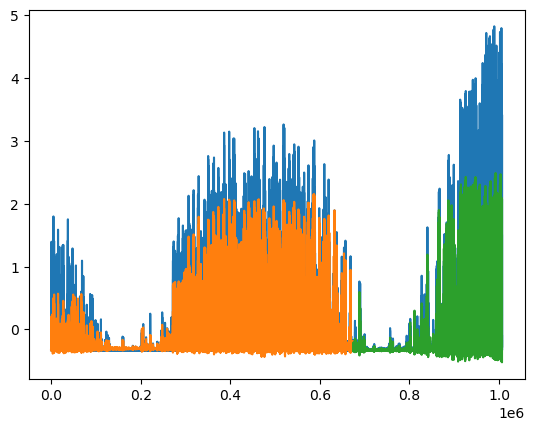

In [114]:
# Muestra los datos originales, la predicción en training y la predicción en test
plt.plot(scaler.inverse_transform(y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# RNN 2

In [130]:
#creamos el modelo y lo entrenamos
model_RNN2 = Sequential() #initialize model
model_RNN2.add(SimpleRNN(10, input_shape=(look_back_memory, variables)))
model_RNN2.add(Dense(1, activation='linear'))
model_RNN2.compile(loss='mean_squared_error', optimizer='adam')
model_RNN2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [134]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.keras' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [138]:
for i in result_dataframes.values():
   
    WINDOW_SIZE = 10
    X1, y1 = df_to_X_y(i['consumption'], WINDOW_SIZE)
    
    X_train1, y_train1 = X1[:X1.shape[0]*80//100], y1[:X1.shape[0]*80//100]
    X_val1, y_val1 = X1[X1.shape[0]*80//100:X1.shape[0]*95//100], y1[X1.shape[0]*80//100:X1.shape[0]*95//100]
    X_test1, y_test1 = X1[X1.shape[0]*95//100:], y1[X1.shape[0]*95//100:]
    X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape
    
    model_RNN2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[early_stoping])

Epoch 1/50
380/382 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0115
Epoch 2/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0114
Epoch 3/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0046WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0120
Epoch 4/50
373/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0119
Epoch 5/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0046WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0123
Epoch 6/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0046WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0122
Epoch 7/50
332/382 [=========================>....] - ETA: 0s - loss: 0.0046WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0115
Epoch 8/50
371/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0115
Epoch 9/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0116
Epoch 10/50
379/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0115
Epoch 11/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0046WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0113
Epoch 12/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0046WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0117
Epoch 13/50
381/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0119
Epoch 14/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0046WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0110
Epoch 15/50
378/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0123
Epoch 16/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0046WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0112
Epoch 17/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0113
Epoch 18/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0044WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0114
Epoch 19/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0116
Epoch 20/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0044WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 972us/step - loss: 0.0045 - val_loss: 0.0114
Epoch 21/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0125
Epoch 22/50
374/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0112
Epoch 23/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0116
Epoch 24/50
380/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0116
Epoch 25/50
380/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0112
Epoch 26/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0044WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0116
Epoch 27/50
376/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0113
Epoch 28/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0111
Epoch 29/50
377/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0114
Epoch 30/50
381/382 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0044 - val_loss: 0.0109
Epoch 31/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0111
Epoch 32/50
382/382 [==============================] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0112
Epoch 33/50
373/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0118
Epoch 34/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0111
Epoch 35/50
371/382 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0113
Epoch 36/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0127
Epoch 37/50
340/382 [=========================>....] - ETA: 0s - loss: 0.0044WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0126
Epoch 38/50
342/382 [=========================>....] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 991us/step - loss: 0.0045 - val_loss: 0.0115
Epoch 39/50
370/382 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0115
Epoch 40/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0115
Epoch 41/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0117
Epoch 42/50
375/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0114
Epoch 43/50
372/382 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0110
Epoch 44/50
381/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0116
Epoch 45/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0118
Epoch 46/50
373/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0110
Epoch 47/50
375/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0111
Epoch 48/50
378/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0112
Epoch 49/50
371/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0111
Epoch 50/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0115
Epoch 1/50
380/382 [============================>.] - ETA: 0s - loss: 4.3844e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3803e-05 - val_loss: 1.1554e-05
Epoch 2/50
359/382 [===========================>..] - ETA: 0s - loss: 2.9666e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9714e-05 - val_loss: 9.9363e-06
Epoch 3/50
371/382 [============================>.] - ETA: 0s - loss: 2.8621e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8609e-05 - val_loss: 1.1250e-05
Epoch 4/50
340/382 [=========================>....] - ETA: 0s - loss: 2.7245e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8258e-05 - val_loss: 1.3164e-05
Epoch 5/50
375/382 [============================>.] - ETA: 0s - loss: 2.8721e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8678e-05 - val_loss: 9.3128e-06
Epoch 6/50
354/382 [==========================>...] - ETA: 0s - loss: 2.8028e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.8891e-05 - val_loss: 9.9176e-06
Epoch 7/50
369/382 [===========================>..] - ETA: 0s - loss: 2.8859e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.8909e-05 - val_loss: 9.9504e-06
Epoch 8/50
364/382 [===========================>..] - ETA: 0s - loss: 2.8072e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.8577e-05 - val_loss: 1.1663e-05
Epoch 9/50
374/382 [============================>.] - ETA: 0s - loss: 2.9023e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.9102e-05 - val_loss: 9.1521e-06
Epoch 10/50
372/382 [============================>.] - ETA: 0s - loss: 2.8892e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.8954e-05 - val_loss: 1.0071e-05
Epoch 11/50
379/382 [============================>.] - ETA: 0s - loss: 2.8892e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8883e-05 - val_loss: 9.5235e-06
Epoch 12/50
337/382 [=========================>....] - ETA: 0s - loss: 2.8934e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8700e-05 - val_loss: 1.2678e-05
Epoch 13/50
372/382 [============================>.] - ETA: 0s - loss: 2.9494e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9637e-05 - val_loss: 1.3035e-05
Epoch 14/50
331/382 [========================>.....] - ETA: 0s - loss: 2.9283e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9044e-05 - val_loss: 2.5971e-05
Epoch 15/50
360/382 [===========================>..] - ETA: 0s - loss: 2.9985e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9475e-05 - val_loss: 8.7735e-06
Epoch 16/50
374/382 [============================>.] - ETA: 0s - loss: 3.0046e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.0124e-05 - val_loss: 8.6684e-06
Epoch 17/50
373/382 [============================>.] - ETA: 0s - loss: 3.0091e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9989e-05 - val_loss: 1.0168e-05
Epoch 18/50
372/382 [============================>.] - ETA: 0s - loss: 2.7608e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.7711e-05 - val_loss: 1.3213e-05
Epoch 19/50
364/382 [===========================>..] - ETA: 0s - loss: 2.9956e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.0100e-05 - val_loss: 9.9680e-06
Epoch 20/50
350/382 [==========================>...] - ETA: 0s - loss: 2.8822e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.8480e-05 - val_loss: 8.3309e-06
Epoch 21/50
381/382 [============================>.] - ETA: 0s - loss: 2.9864e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.9956e-05 - val_loss: 1.1565e-05
Epoch 22/50
366/382 [===========================>..] - ETA: 0s - loss: 2.9829e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.9861e-05 - val_loss: 1.1612e-05
Epoch 23/50
369/382 [===========================>..] - ETA: 0s - loss: 2.8830e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8761e-05 - val_loss: 8.4824e-06
Epoch 24/50
361/382 [===========================>..] - ETA: 0s - loss: 2.8703e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8974e-05 - val_loss: 9.4945e-06
Epoch 25/50
355/382 [==========================>...] - ETA: 0s - loss: 2.7763e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 974us/step - loss: 2.7921e-05 - val_loss: 1.9144e-05
Epoch 26/50
381/382 [============================>.] - ETA: 0s - loss: 2.9580e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9604e-05 - val_loss: 1.4784e-05
Epoch 27/50
337/382 [=========================>....] - ETA: 0s - loss: 2.9964e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 997us/step - loss: 2.9664e-05 - val_loss: 1.5878e-05
Epoch 28/50
379/382 [============================>.] - ETA: 0s - loss: 2.9586e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9531e-05 - val_loss: 9.2971e-06
Epoch 29/50
366/382 [===========================>..] - ETA: 0s - loss: 2.9245e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9336e-05 - val_loss: 9.8685e-06
Epoch 30/50
381/382 [============================>.] - ETA: 0s - loss: 2.7797e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.7783e-05 - val_loss: 1.4321e-05
Epoch 31/50
340/382 [=========================>....] - ETA: 0s - loss: 2.8236e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8164e-05 - val_loss: 1.0888e-05
Epoch 32/50
356/382 [==========================>...] - ETA: 0s - loss: 3.0708e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.0781e-05 - val_loss: 9.7996e-06
Epoch 33/50
377/382 [============================>.] - ETA: 0s - loss: 2.9290e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9277e-05 - val_loss: 1.0378e-05
Epoch 34/50
378/382 [============================>.] - ETA: 0s - loss: 2.8650e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8602e-05 - val_loss: 1.2038e-05
Epoch 35/50
369/382 [===========================>..] - ETA: 0s - loss: 2.8539e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8499e-05 - val_loss: 1.0626e-05
Epoch 36/50
365/382 [===========================>..] - ETA: 0s - loss: 2.8710e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.8788e-05 - val_loss: 1.8505e-05
Epoch 37/50
376/382 [============================>.] - ETA: 0s - loss: 2.9320e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9209e-05 - val_loss: 9.5357e-06
Epoch 38/50
376/382 [============================>.] - ETA: 0s - loss: 2.9122e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9024e-05 - val_loss: 9.5965e-06
Epoch 39/50
371/382 [============================>.] - ETA: 0s - loss: 2.8754e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.8883e-05 - val_loss: 1.3169e-05
Epoch 40/50
360/382 [===========================>..] - ETA: 0s - loss: 2.9571e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9034e-05 - val_loss: 1.3118e-05
Epoch 41/50
375/382 [============================>.] - ETA: 0s - loss: 2.7787e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.7898e-05 - val_loss: 1.2279e-05
Epoch 42/50
382/382 [==============================] - ETA: 0s - loss: 2.8498e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.8498e-05 - val_loss: 1.6242e-05
Epoch 43/50
376/382 [============================>.] - ETA: 0s - loss: 2.8930e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8861e-05 - val_loss: 8.8667e-06
Epoch 44/50
382/382 [==============================] - ETA: 0s - loss: 2.9207e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9207e-05 - val_loss: 9.8426e-06
Epoch 45/50
373/382 [============================>.] - ETA: 0s - loss: 2.7331e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 936us/step - loss: 2.7349e-05 - val_loss: 8.1315e-06
Epoch 46/50
379/382 [============================>.] - ETA: 0s - loss: 2.9993e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.9973e-05 - val_loss: 1.9538e-05
Epoch 47/50
362/382 [===========================>..] - ETA: 0s - loss: 2.8059e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.7814e-05 - val_loss: 9.8155e-06
Epoch 48/50
368/382 [===========================>..] - ETA: 0s - loss: 2.8675e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8833e-05 - val_loss: 1.6396e-05
Epoch 49/50
374/382 [============================>.] - ETA: 0s - loss: 2.8026e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8230e-05 - val_loss: 8.5119e-06
Epoch 50/50
373/382 [============================>.] - ETA: 0s - loss: 2.9456e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.9225e-05 - val_loss: 1.1482e-05
Epoch 1/50
377/382 [============================>.] - ETA: 0s - loss: 0.0774WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0770 - val_loss: 0.3978
Epoch 2/50
372/382 [============================>.] - ETA: 0s - loss: 0.0578WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0583 - val_loss: 0.3267
Epoch 3/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0559WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0557 - val_loss: 0.3001
Epoch 4/50
371/382 [============================>.] - ETA: 0s - loss: 0.0547WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0547 - val_loss: 0.2851
Epoch 5/50
370/382 [============================>.] - ETA: 0s - loss: 0.0541WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0542 - val_loss: 0.2749
Epoch 6/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0540WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0536 - val_loss: 0.2619
Epoch 7/50
379/382 [============================>.] - ETA: 0s - loss: 0.0536WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0536 - val_loss: 0.2562
Epoch 8/50
380/382 [============================>.] - ETA: 0s - loss: 0.0535WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0535 - val_loss: 0.2472
Epoch 9/50
378/382 [============================>.] - ETA: 0s - loss: 0.0532WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0532 - val_loss: 0.2397
Epoch 10/50
377/382 [============================>.] - ETA: 0s - loss: 0.0530WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0530 - val_loss: 0.2357
Epoch 11/50
373/382 [============================>.] - ETA: 0s - loss: 0.0526WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0528 - val_loss: 0.2368
Epoch 12/50
371/382 [============================>.] - ETA: 0s - loss: 0.0535WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0533 - val_loss: 0.2361
Epoch 13/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0531WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.2318
Epoch 14/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0528WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.2245
Epoch 15/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0526WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0527 - val_loss: 0.2224
Epoch 16/50
329/382 [========================>.....] - ETA: 0s - loss: 0.0541WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0524 - val_loss: 0.2205
Epoch 17/50
376/382 [============================>.] - ETA: 0s - loss: 0.0526WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0526 - val_loss: 0.2271
Epoch 18/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0527WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0525 - val_loss: 0.2240
Epoch 19/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0527WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0525 - val_loss: 0.2192
Epoch 20/50
378/382 [============================>.] - ETA: 0s - loss: 0.0526WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0525 - val_loss: 0.2155
Epoch 21/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0527WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0523 - val_loss: 0.2156
Epoch 22/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0517WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0521 - val_loss: 0.2125
Epoch 23/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0511WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0520 - val_loss: 0.2201
Epoch 24/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0533WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0522 - val_loss: 0.2130
Epoch 25/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0514WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0519 - val_loss: 0.2124
Epoch 26/50
379/382 [============================>.] - ETA: 0s - loss: 0.0518WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0519 - val_loss: 0.2091
Epoch 27/50
376/382 [============================>.] - ETA: 0s - loss: 0.0523WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0520 - val_loss: 0.2141
Epoch 28/50
380/382 [============================>.] - ETA: 0s - loss: 0.0520WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0520 - val_loss: 0.2120
Epoch 29/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0515WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0519 - val_loss: 0.2076
Epoch 30/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0513WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0515 - val_loss: 0.2084
Epoch 31/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0505WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0515 - val_loss: 0.2038
Epoch 32/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0520WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0520 - val_loss: 0.2046
Epoch 33/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0518WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0517 - val_loss: 0.2054
Epoch 34/50
370/382 [============================>.] - ETA: 0s - loss: 0.0520WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 953us/step - loss: 0.0516 - val_loss: 0.2012
Epoch 35/50
375/382 [============================>.] - ETA: 0s - loss: 0.0513WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0516 - val_loss: 0.2000
Epoch 36/50
381/382 [============================>.] - ETA: 0s - loss: 0.0520WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0520 - val_loss: 0.2019
Epoch 37/50
374/382 [============================>.] - ETA: 0s - loss: 0.0517WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0516 - val_loss: 0.2102
Epoch 38/50
382/382 [==============================] - ETA: 0s - loss: 0.0511WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0511 - val_loss: 0.2025
Epoch 39/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0513WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0515 - val_loss: 0.2031
Epoch 40/50
372/382 [============================>.] - ETA: 0s - loss: 0.0512WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0517 - val_loss: 0.2017
Epoch 41/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0511WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0515 - val_loss: 0.2047
Epoch 42/50
377/382 [============================>.] - ETA: 0s - loss: 0.0520WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0516 - val_loss: 0.2076
Epoch 43/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0515WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0515 - val_loss: 0.2011
Epoch 44/50
374/382 [============================>.] - ETA: 0s - loss: 0.0512WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0513 - val_loss: 0.2007
Epoch 45/50
381/382 [============================>.] - ETA: 0s - loss: 0.0512WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0512 - val_loss: 0.2012
Epoch 46/50
374/382 [============================>.] - ETA: 0s - loss: 0.0504WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0510 - val_loss: 0.2093
Epoch 47/50
380/382 [============================>.] - ETA: 0s - loss: 0.0510WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0510 - val_loss: 0.1995
Epoch 48/50
341/382 [=========================>....] - ETA: 0s - loss: 0.0495WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0511 - val_loss: 0.2023
Epoch 49/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0512WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0512 - val_loss: 0.2103
Epoch 50/50
377/382 [============================>.] - ETA: 0s - loss: 0.0506WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0511 - val_loss: 0.2048
Epoch 1/50
357/382 [===========================>..] - ETA: 0s - loss: 7.8701e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.7954e-04 - val_loss: 4.6050e-04
Epoch 2/50
346/382 [==========================>...] - ETA: 0s - loss: 5.2856e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 990us/step - loss: 5.2469e-04 - val_loss: 4.1868e-04
Epoch 3/50
372/382 [============================>.] - ETA: 0s - loss: 4.8121e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.8359e-04 - val_loss: 4.1361e-04
Epoch 4/50
369/382 [===========================>..] - ETA: 0s - loss: 4.6970e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.6971e-04 - val_loss: 4.1504e-04
Epoch 5/50
374/382 [============================>.] - ETA: 0s - loss: 4.6193e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.5976e-04 - val_loss: 4.1237e-04
Epoch 6/50
377/382 [============================>.] - ETA: 0s - loss: 4.4988e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.5250e-04 - val_loss: 4.0405e-04
Epoch 7/50
376/382 [============================>.] - ETA: 0s - loss: 4.4680e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.4652e-04 - val_loss: 3.9949e-04
Epoch 8/50
375/382 [============================>.] - ETA: 0s - loss: 4.3823e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3655e-04 - val_loss: 3.9740e-04
Epoch 9/50
366/382 [===========================>..] - ETA: 0s - loss: 4.2937e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3248e-04 - val_loss: 3.9812e-04
Epoch 10/50
369/382 [===========================>..] - ETA: 0s - loss: 4.3063e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.2603e-04 - val_loss: 4.1478e-04
Epoch 11/50
380/382 [============================>.] - ETA: 0s - loss: 4.2827e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.2703e-04 - val_loss: 3.9515e-04
Epoch 12/50
363/382 [===========================>..] - ETA: 0s - loss: 4.3145e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3054e-04 - val_loss: 4.0195e-04
Epoch 13/50
381/382 [============================>.] - ETA: 0s - loss: 4.1506e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.1554e-04 - val_loss: 4.0047e-04
Epoch 14/50
381/382 [============================>.] - ETA: 0s - loss: 4.2096e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.2037e-04 - val_loss: 3.9364e-04
Epoch 15/50
358/382 [===========================>..] - ETA: 0s - loss: 4.2031e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.2248e-04 - val_loss: 3.9371e-04
Epoch 16/50
369/382 [===========================>..] - ETA: 0s - loss: 4.1222e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1342e-04 - val_loss: 4.7504e-04
Epoch 17/50
353/382 [==========================>...] - ETA: 0s - loss: 4.1490e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.1575e-04 - val_loss: 4.0306e-04
Epoch 18/50
326/382 [========================>.....] - ETA: 0s - loss: 4.1840e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.1722e-04 - val_loss: 3.9651e-04
Epoch 19/50
377/382 [============================>.] - ETA: 0s - loss: 4.1572e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1339e-04 - val_loss: 4.0990e-04
Epoch 20/50
348/382 [==========================>...] - ETA: 0s - loss: 4.2060e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.1543e-04 - val_loss: 3.9261e-04
Epoch 21/50
365/382 [===========================>..] - ETA: 0s - loss: 4.1613e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 986us/step - loss: 4.1674e-04 - val_loss: 4.1646e-04
Epoch 22/50
377/382 [============================>.] - ETA: 0s - loss: 4.1043e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.1123e-04 - val_loss: 4.3323e-04
Epoch 23/50
382/382 [==============================] - ETA: 0s - loss: 4.1846e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.1846e-04 - val_loss: 4.4714e-04
Epoch 24/50
361/382 [===========================>..] - ETA: 0s - loss: 4.2592e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.2799e-04 - val_loss: 4.0395e-04
Epoch 25/50
373/382 [============================>.] - ETA: 0s - loss: 4.1692e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.1571e-04 - val_loss: 3.9427e-04
Epoch 26/50
373/382 [============================>.] - ETA: 0s - loss: 4.1815e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.1627e-04 - val_loss: 4.0778e-04
Epoch 27/50
356/382 [==========================>...] - ETA: 0s - loss: 4.2003e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1617e-04 - val_loss: 4.1579e-04
Epoch 28/50
377/382 [============================>.] - ETA: 0s - loss: 4.1362e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1147e-04 - val_loss: 4.0249e-04
Epoch 29/50
373/382 [============================>.] - ETA: 0s - loss: 4.1535e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.1484e-04 - val_loss: 4.0525e-04
Epoch 30/50
377/382 [============================>.] - ETA: 0s - loss: 4.0978e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.1095e-04 - val_loss: 5.2604e-04
Epoch 31/50
351/382 [==========================>...] - ETA: 0s - loss: 4.2293e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1967e-04 - val_loss: 4.1771e-04
Epoch 32/50
378/382 [============================>.] - ETA: 0s - loss: 4.1299e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.1214e-04 - val_loss: 4.0731e-04
Epoch 33/50
346/382 [==========================>...] - ETA: 0s - loss: 4.1214e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0941e-04 - val_loss: 4.2177e-04
Epoch 34/50
365/382 [===========================>..] - ETA: 0s - loss: 4.2011e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1905e-04 - val_loss: 4.0176e-04
Epoch 35/50
381/382 [============================>.] - ETA: 0s - loss: 4.0960e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0958e-04 - val_loss: 4.2185e-04
Epoch 36/50
334/382 [=========================>....] - ETA: 0s - loss: 4.1772e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1208e-04 - val_loss: 4.0102e-04
Epoch 37/50
382/382 [==============================] - ETA: 0s - loss: 4.1638e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1638e-04 - val_loss: 4.7009e-04
Epoch 38/50
339/382 [=========================>....] - ETA: 0s - loss: 4.0761e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0835e-04 - val_loss: 4.8672e-04
Epoch 39/50
374/382 [============================>.] - ETA: 0s - loss: 4.0758e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 932us/step - loss: 4.0632e-04 - val_loss: 3.9251e-04
Epoch 40/50
376/382 [============================>.] - ETA: 0s - loss: 4.1539e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1745e-04 - val_loss: 4.4977e-04
Epoch 41/50
382/382 [==============================] - ETA: 0s - loss: 4.0209e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0209e-04 - val_loss: 4.1360e-04
Epoch 42/50
379/382 [============================>.] - ETA: 0s - loss: 4.0811e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0741e-04 - val_loss: 4.2336e-04
Epoch 43/50
373/382 [============================>.] - ETA: 0s - loss: 4.1176e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.0964e-04 - val_loss: 4.1973e-04
Epoch 44/50
374/382 [============================>.] - ETA: 0s - loss: 4.1012e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.0944e-04 - val_loss: 4.0360e-04
Epoch 45/50
371/382 [============================>.] - ETA: 0s - loss: 4.1591e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1880e-04 - val_loss: 4.6880e-04
Epoch 46/50
351/382 [==========================>...] - ETA: 0s - loss: 4.0602e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0674e-04 - val_loss: 4.1766e-04
Epoch 47/50
373/382 [============================>.] - ETA: 0s - loss: 4.0865e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0491e-04 - val_loss: 4.2936e-04
Epoch 48/50
360/382 [===========================>..] - ETA: 0s - loss: 4.0490e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0597e-04 - val_loss: 4.8386e-04
Epoch 49/50
370/382 [============================>.] - ETA: 0s - loss: 4.0799e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0876e-04 - val_loss: 3.9945e-04
Epoch 50/50
371/382 [============================>.] - ETA: 0s - loss: 4.1362e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.1691e-04 - val_loss: 4.3536e-04
Epoch 1/50
338/382 [=========================>....] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 2/50
375/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 3/50
373/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 4/50
381/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 5/50
378/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 6/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/50
337/382 [=========================>....] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1000us/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 9/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 10/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 11/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 12/50
380/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 13/50
377/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 14/50
378/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 15/50
370/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 16/50
375/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 17/50
373/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 18/50
379/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 19/50
379/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 20/50
378/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 21/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 22/50
375/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 23/50
376/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 24/50
371/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 25/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 26/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 27/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 28/50
373/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 29/50
381/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 30/50
375/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 31/50
381/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 32/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 33/50
379/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 34/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 35/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 36/50
375/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 37/50
370/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 38/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 39/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 40/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 41/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 42/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 43/50
373/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 44/50
344/382 [==========================>...] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 45/50
330/382 [========================>.....] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 46/50
370/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 47/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 48/50
380/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 49/50
371/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 50/50
376/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 1/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0930WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0927 - val_loss: 0.1459
Epoch 2/50
374/382 [============================>.] - ETA: 0s - loss: 0.0803WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0820 - val_loss: 0.1293
Epoch 3/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0809WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0803 - val_loss: 0.1317
Epoch 4/50
373/382 [============================>.] - ETA: 0s - loss: 0.0798WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0800 - val_loss: 0.1300
Epoch 5/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0792WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0795 - val_loss: 0.1276
Epoch 6/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0790WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0792 - val_loss: 0.1208
Epoch 7/50
375/382 [============================>.] - ETA: 0s - loss: 0.0790WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0789 - val_loss: 0.1206
Epoch 8/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0782WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0784 - val_loss: 0.1216
Epoch 9/50
377/382 [============================>.] - ETA: 0s - loss: 0.0792WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0787 - val_loss: 0.1178
Epoch 10/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0777WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0780 - val_loss: 0.1192
Epoch 11/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0777WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0776 - val_loss: 0.1200
Epoch 12/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0776WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0776 - val_loss: 0.1144
Epoch 13/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0786WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0774 - val_loss: 0.1103
Epoch 14/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0771WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0779 - val_loss: 0.1176
Epoch 15/50
342/382 [=========================>....] - ETA: 0s - loss: 0.0787WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0780 - val_loss: 0.1138
Epoch 16/50
341/382 [=========================>....] - ETA: 0s - loss: 0.0778WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0772 - val_loss: 0.1146
Epoch 17/50
371/382 [============================>.] - ETA: 0s - loss: 0.0771WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0768 - val_loss: 0.1185
Epoch 18/50
373/382 [============================>.] - ETA: 0s - loss: 0.0775WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0770 - val_loss: 0.1200
Epoch 19/50
376/382 [============================>.] - ETA: 0s - loss: 0.0773WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0769 - val_loss: 0.1184
Epoch 20/50
373/382 [============================>.] - ETA: 0s - loss: 0.0774WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0770 - val_loss: 0.1176
Epoch 21/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0781WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0769 - val_loss: 0.1105
Epoch 22/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0748WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0765 - val_loss: 0.1186
Epoch 23/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0767WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0766 - val_loss: 0.1175
Epoch 24/50
373/382 [============================>.] - ETA: 0s - loss: 0.0763WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0768 - val_loss: 0.1090
Epoch 25/50
380/382 [============================>.] - ETA: 0s - loss: 0.0756WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0762 - val_loss: 0.1151
Epoch 26/50
373/382 [============================>.] - ETA: 0s - loss: 0.0766WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0765 - val_loss: 0.1150
Epoch 27/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0754WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0761 - val_loss: 0.1132
Epoch 28/50
373/382 [============================>.] - ETA: 0s - loss: 0.0766WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0764 - val_loss: 0.1139
Epoch 29/50
320/382 [========================>.....] - ETA: 0s - loss: 0.0758WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0760 - val_loss: 0.1116
Epoch 30/50
370/382 [============================>.] - ETA: 0s - loss: 0.0765WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0765 - val_loss: 0.1115
Epoch 31/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0762WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0757 - val_loss: 0.1129
Epoch 32/50
373/382 [============================>.] - ETA: 0s - loss: 0.0763WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0759 - val_loss: 0.1117
Epoch 33/50
338/382 [=========================>....] - ETA: 0s - loss: 0.0775WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0759 - val_loss: 0.1060
Epoch 34/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0758WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 984us/step - loss: 0.0762 - val_loss: 0.1175
Epoch 35/50
381/382 [============================>.] - ETA: 0s - loss: 0.0747WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0758 - val_loss: 0.1087
Epoch 36/50
378/382 [============================>.] - ETA: 0s - loss: 0.0757WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0758 - val_loss: 0.1143
Epoch 37/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0760WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0760 - val_loss: 0.1107
Epoch 38/50
371/382 [============================>.] - ETA: 0s - loss: 0.0766WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0761 - val_loss: 0.1098
Epoch 39/50
375/382 [============================>.] - ETA: 0s - loss: 0.0757WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0756 - val_loss: 0.1105
Epoch 40/50
380/382 [============================>.] - ETA: 0s - loss: 0.0734WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0755 - val_loss: 0.1068
Epoch 41/50
328/382 [========================>.....] - ETA: 0s - loss: 0.0748WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0754 - val_loss: 0.1132
Epoch 42/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0749WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0753 - val_loss: 0.1189
Epoch 43/50
374/382 [============================>.] - ETA: 0s - loss: 0.0756WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0759 - val_loss: 0.1134
Epoch 44/50
375/382 [============================>.] - ETA: 0s - loss: 0.0757WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0757 - val_loss: 0.1102
Epoch 45/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0765WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0752 - val_loss: 0.1119
Epoch 46/50
373/382 [============================>.] - ETA: 0s - loss: 0.0756WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0755 - val_loss: 0.1074
Epoch 47/50
373/382 [============================>.] - ETA: 0s - loss: 0.0754WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0754 - val_loss: 0.1127
Epoch 48/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0735WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0751 - val_loss: 0.1096
Epoch 49/50
376/382 [============================>.] - ETA: 0s - loss: 0.0758WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0756 - val_loss: 0.1082
Epoch 50/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0750WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0750 - val_loss: 0.1086
Epoch 1/50
382/382 [==============================] - ETA: 0s - loss: 2.0443e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.0443e-04 - val_loss: 3.0045e-04
Epoch 2/50
373/382 [============================>.] - ETA: 0s - loss: 1.3454e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3528e-04 - val_loss: 2.2914e-04
Epoch 3/50
351/382 [==========================>...] - ETA: 0s - loss: 1.0517e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.0395e-04 - val_loss: 1.8998e-04
Epoch 4/50
382/382 [==============================] - ETA: 0s - loss: 8.4525e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.4525e-05 - val_loss: 1.5167e-04
Epoch 5/50
376/382 [============================>.] - ETA: 0s - loss: 7.0428e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.0534e-05 - val_loss: 1.2333e-04
Epoch 6/50
341/382 [=========================>....] - ETA: 0s - loss: 6.0092e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9939e-05 - val_loss: 9.7424e-05
Epoch 7/50
382/382 [==============================] - ETA: 0s - loss: 5.1133e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.1133e-05 - val_loss: 8.1783e-05
Epoch 8/50
350/382 [==========================>...] - ETA: 0s - loss: 4.3427e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4149e-05 - val_loss: 7.5770e-05
Epoch 9/50
379/382 [============================>.] - ETA: 0s - loss: 3.8810e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.8669e-05 - val_loss: 6.3143e-05
Epoch 10/50
382/382 [==============================] - ETA: 0s - loss: 3.4760e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.4760e-05 - val_loss: 6.0625e-05
Epoch 11/50
380/382 [============================>.] - ETA: 0s - loss: 3.2591e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.2609e-05 - val_loss: 5.8169e-05
Epoch 12/50
366/382 [===========================>..] - ETA: 0s - loss: 3.0534e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.0297e-05 - val_loss: 5.5072e-05
Epoch 13/50
368/382 [===========================>..] - ETA: 0s - loss: 2.9417e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.9250e-05 - val_loss: 5.3657e-05
Epoch 14/50
372/382 [============================>.] - ETA: 0s - loss: 2.7960e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.7752e-05 - val_loss: 4.9602e-05
Epoch 15/50
368/382 [===========================>..] - ETA: 0s - loss: 2.7205e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.7104e-05 - val_loss: 4.6837e-05
Epoch 16/50
360/382 [===========================>..] - ETA: 0s - loss: 2.6313e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.7367e-05 - val_loss: 4.5348e-05
Epoch 17/50
361/382 [===========================>..] - ETA: 0s - loss: 2.8692e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8479e-05 - val_loss: 4.3421e-05
Epoch 18/50
365/382 [===========================>..] - ETA: 0s - loss: 2.8280e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.8433e-05 - val_loss: 4.5729e-05
Epoch 19/50
319/382 [========================>.....] - ETA: 0s - loss: 2.7630e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.7487e-05 - val_loss: 4.5556e-05
Epoch 20/50
375/382 [============================>.] - ETA: 0s - loss: 2.8398e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.8359e-05 - val_loss: 4.2937e-05
Epoch 21/50
352/382 [==========================>...] - ETA: 0s - loss: 2.9224e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8856e-05 - val_loss: 4.2497e-05
Epoch 22/50
338/382 [=========================>....] - ETA: 0s - loss: 2.7275e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.7207e-05 - val_loss: 4.1575e-05
Epoch 23/50
364/382 [===========================>..] - ETA: 0s - loss: 2.8145e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 955us/step - loss: 2.8032e-05 - val_loss: 4.4809e-05
Epoch 24/50
377/382 [============================>.] - ETA: 0s - loss: 2.8327e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8341e-05 - val_loss: 4.4413e-05
Epoch 25/50
376/382 [============================>.] - ETA: 0s - loss: 2.6350e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.6509e-05 - val_loss: 4.2801e-05
Epoch 26/50
381/382 [============================>.] - ETA: 0s - loss: 2.6906e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.6896e-05 - val_loss: 4.5275e-05
Epoch 27/50
375/382 [============================>.] - ETA: 0s - loss: 2.8636e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8373e-05 - val_loss: 4.0468e-05
Epoch 28/50
373/382 [============================>.] - ETA: 0s - loss: 2.6550e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.6371e-05 - val_loss: 4.0011e-05
Epoch 29/50
370/382 [============================>.] - ETA: 0s - loss: 2.6605e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.6864e-05 - val_loss: 4.3837e-05
Epoch 30/50
379/382 [============================>.] - ETA: 0s - loss: 2.6701e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.6753e-05 - val_loss: 6.9025e-05
Epoch 31/50
368/382 [===========================>..] - ETA: 0s - loss: 2.8161e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.7960e-05 - val_loss: 4.0670e-05
Epoch 32/50
350/382 [==========================>...] - ETA: 0s - loss: 2.4586e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.5185e-05 - val_loss: 4.0687e-05
Epoch 33/50
364/382 [===========================>..] - ETA: 0s - loss: 2.6405e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.6391e-05 - val_loss: 4.1282e-05
Epoch 34/50
374/382 [============================>.] - ETA: 0s - loss: 2.5729e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5714e-05 - val_loss: 4.3284e-05
Epoch 35/50
379/382 [============================>.] - ETA: 0s - loss: 2.8106e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.8152e-05 - val_loss: 4.4105e-05
Epoch 36/50
358/382 [===========================>..] - ETA: 0s - loss: 2.6298e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.6197e-05 - val_loss: 5.1077e-05
Epoch 37/50
372/382 [============================>.] - ETA: 0s - loss: 2.6299e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.6338e-05 - val_loss: 4.0381e-05
Epoch 38/50
366/382 [===========================>..] - ETA: 0s - loss: 2.5515e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.5530e-05 - val_loss: 3.9765e-05
Epoch 39/50
378/382 [============================>.] - ETA: 0s - loss: 2.5029e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5109e-05 - val_loss: 4.5868e-05
Epoch 40/50
347/382 [==========================>...] - ETA: 0s - loss: 2.5571e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5815e-05 - val_loss: 3.9757e-05
Epoch 41/50
334/382 [=========================>....] - ETA: 0s - loss: 2.5618e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.5423e-05 - val_loss: 4.0238e-05
Epoch 42/50
377/382 [============================>.] - ETA: 0s - loss: 2.7203e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.7224e-05 - val_loss: 4.4604e-05
Epoch 43/50
372/382 [============================>.] - ETA: 0s - loss: 2.6616e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.6627e-05 - val_loss: 4.7749e-05
Epoch 44/50
380/382 [============================>.] - ETA: 0s - loss: 2.5826e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.5792e-05 - val_loss: 5.9584e-05
Epoch 45/50
382/382 [==============================] - ETA: 0s - loss: 2.5603e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5603e-05 - val_loss: 4.4389e-05
Epoch 46/50
377/382 [============================>.] - ETA: 0s - loss: 2.7055e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.7135e-05 - val_loss: 3.9721e-05
Epoch 47/50
376/382 [============================>.] - ETA: 0s - loss: 2.5596e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5454e-05 - val_loss: 4.0191e-05
Epoch 48/50
380/382 [============================>.] - ETA: 0s - loss: 2.5882e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 2.5904e-05 - val_loss: 5.8723e-05
Epoch 49/50
373/382 [============================>.] - ETA: 0s - loss: 2.5524e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5635e-05 - val_loss: 4.1954e-05
Epoch 50/50
368/382 [===========================>..] - ETA: 0s - loss: 2.6343e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.6212e-05 - val_loss: 5.0953e-05
Epoch 1/50
373/382 [============================>.] - ETA: 0s - loss: 5.0087e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.9821e-04 - val_loss: 4.5230e-04
Epoch 2/50
382/382 [==============================] - ETA: 0s - loss: 4.7447e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.7447e-04 - val_loss: 5.4757e-04
Epoch 3/50
355/382 [==========================>...] - ETA: 0s - loss: 4.7928e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.8150e-04 - val_loss: 4.3394e-04
Epoch 4/50
378/382 [============================>.] - ETA: 0s - loss: 4.7317e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.7222e-04 - val_loss: 4.3057e-04
Epoch 5/50
374/382 [============================>.] - ETA: 0s - loss: 4.7165e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.6940e-04 - val_loss: 4.2455e-04
Epoch 6/50
364/382 [===========================>..] - ETA: 0s - loss: 4.6556e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.6041e-04 - val_loss: 4.6859e-04
Epoch 7/50
366/382 [===========================>..] - ETA: 0s - loss: 4.5492e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.6182e-04 - val_loss: 4.6507e-04
Epoch 8/50
344/382 [==========================>...] - ETA: 0s - loss: 4.6908e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.5954e-04 - val_loss: 4.5864e-04
Epoch 9/50
344/382 [==========================>...] - ETA: 0s - loss: 4.7839e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1000us/step - loss: 4.7808e-04 - val_loss: 4.3357e-04
Epoch 10/50
367/382 [===========================>..] - ETA: 0s - loss: 4.5636e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.5523e-04 - val_loss: 4.2117e-04
Epoch 11/50
373/382 [============================>.] - ETA: 0s - loss: 4.7569e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.7367e-04 - val_loss: 4.2218e-04
Epoch 12/50
376/382 [============================>.] - ETA: 0s - loss: 4.5596e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.5386e-04 - val_loss: 4.4104e-04
Epoch 13/50
376/382 [============================>.] - ETA: 0s - loss: 4.4896e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.5312e-04 - val_loss: 4.1738e-04
Epoch 14/50
369/382 [===========================>..] - ETA: 0s - loss: 4.4571e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4779e-04 - val_loss: 4.0937e-04
Epoch 15/50
365/382 [===========================>..] - ETA: 0s - loss: 4.5528e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.5607e-04 - val_loss: 4.4148e-04
Epoch 16/50
378/382 [============================>.] - ETA: 0s - loss: 4.4968e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.5041e-04 - val_loss: 4.7785e-04
Epoch 17/50
363/382 [===========================>..] - ETA: 0s - loss: 4.5111e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.5624e-04 - val_loss: 4.2909e-04
Epoch 18/50
340/382 [=========================>....] - ETA: 0s - loss: 4.5041e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4951e-04 - val_loss: 4.1805e-04
Epoch 19/50
382/382 [==============================] - ETA: 0s - loss: 4.4899e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4899e-04 - val_loss: 4.3414e-04
Epoch 20/50
376/382 [============================>.] - ETA: 0s - loss: 4.4798e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.5170e-04 - val_loss: 4.3157e-04
Epoch 21/50
370/382 [============================>.] - ETA: 0s - loss: 4.4239e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4420e-04 - val_loss: 4.2695e-04
Epoch 22/50
375/382 [============================>.] - ETA: 0s - loss: 4.4195e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.4359e-04 - val_loss: 4.2911e-04
Epoch 23/50
379/382 [============================>.] - ETA: 0s - loss: 4.4128e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.4304e-04 - val_loss: 4.1303e-04
Epoch 24/50
375/382 [============================>.] - ETA: 0s - loss: 4.4689e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.4792e-04 - val_loss: 4.0504e-04
Epoch 25/50
360/382 [===========================>..] - ETA: 0s - loss: 4.6570e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.6262e-04 - val_loss: 4.0509e-04
Epoch 26/50
380/382 [============================>.] - ETA: 0s - loss: 4.4133e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4287e-04 - val_loss: 4.1689e-04
Epoch 27/50
345/382 [==========================>...] - ETA: 0s - loss: 4.4508e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4393e-04 - val_loss: 4.1843e-04
Epoch 28/50
370/382 [============================>.] - ETA: 0s - loss: 4.3605e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 971us/step - loss: 4.3609e-04 - val_loss: 4.4993e-04
Epoch 29/50
379/382 [============================>.] - ETA: 0s - loss: 4.3946e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.3968e-04 - val_loss: 4.0442e-04
Epoch 30/50
378/382 [============================>.] - ETA: 0s - loss: 4.3990e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3906e-04 - val_loss: 4.1785e-04
Epoch 31/50
365/382 [===========================>..] - ETA: 0s - loss: 4.3741e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.4122e-04 - val_loss: 4.7497e-04
Epoch 32/50
366/382 [===========================>..] - ETA: 0s - loss: 4.4888e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4951e-04 - val_loss: 4.5188e-04
Epoch 33/50
378/382 [============================>.] - ETA: 0s - loss: 4.4554e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.4638e-04 - val_loss: 3.9420e-04
Epoch 34/50
349/382 [==========================>...] - ETA: 0s - loss: 4.3592e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4515e-04 - val_loss: 4.4592e-04
Epoch 35/50
371/382 [============================>.] - ETA: 0s - loss: 4.3978e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4127e-04 - val_loss: 3.9755e-04
Epoch 36/50
380/382 [============================>.] - ETA: 0s - loss: 4.4453e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.4434e-04 - val_loss: 4.2880e-04
Epoch 37/50
365/382 [===========================>..] - ETA: 0s - loss: 4.3845e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3788e-04 - val_loss: 4.0545e-04
Epoch 38/50
376/382 [============================>.] - ETA: 0s - loss: 4.3989e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3995e-04 - val_loss: 4.0414e-04
Epoch 39/50
373/382 [============================>.] - ETA: 0s - loss: 4.3223e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3523e-04 - val_loss: 5.3571e-04
Epoch 40/50
380/382 [============================>.] - ETA: 0s - loss: 4.3895e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3841e-04 - val_loss: 4.0866e-04
Epoch 41/50
379/382 [============================>.] - ETA: 0s - loss: 4.3465e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3290e-04 - val_loss: 3.9159e-04
Epoch 42/50
368/382 [===========================>..] - ETA: 0s - loss: 4.4397e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3819e-04 - val_loss: 4.0485e-04
Epoch 43/50
370/382 [============================>.] - ETA: 0s - loss: 4.4108e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.3972e-04 - val_loss: 4.0940e-04
Epoch 44/50
376/382 [============================>.] - ETA: 0s - loss: 4.4277e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4453e-04 - val_loss: 4.5213e-04
Epoch 45/50
372/382 [============================>.] - ETA: 0s - loss: 4.3982e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.3851e-04 - val_loss: 4.2029e-04
Epoch 46/50
330/382 [========================>.....] - ETA: 0s - loss: 4.4352e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.3523e-04 - val_loss: 3.9748e-04
Epoch 47/50
369/382 [===========================>..] - ETA: 0s - loss: 4.4330e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 946us/step - loss: 4.4293e-04 - val_loss: 3.8919e-04
Epoch 48/50
365/382 [===========================>..] - ETA: 0s - loss: 4.3576e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3421e-04 - val_loss: 4.4162e-04
Epoch 49/50
376/382 [============================>.] - ETA: 0s - loss: 4.3780e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3671e-04 - val_loss: 4.3510e-04
Epoch 50/50
380/382 [============================>.] - ETA: 0s - loss: 4.3619e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3612e-04 - val_loss: 4.3611e-04
Epoch 1/50
362/382 [===========================>..] - ETA: 0s - loss: 1.4491e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4517e-04 - val_loss: 1.6189e-04
Epoch 2/50
377/382 [============================>.] - ETA: 0s - loss: 1.4354e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4383e-04 - val_loss: 1.5840e-04
Epoch 3/50
371/382 [============================>.] - ETA: 0s - loss: 1.4799e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4714e-04 - val_loss: 1.6013e-04
Epoch 4/50
329/382 [========================>.....] - ETA: 0s - loss: 1.4821e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4858e-04 - val_loss: 1.5827e-04
Epoch 5/50
349/382 [==========================>...] - ETA: 0s - loss: 1.4497e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4693e-04 - val_loss: 1.5598e-04
Epoch 6/50
375/382 [============================>.] - ETA: 0s - loss: 1.4917e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4902e-04 - val_loss: 1.5559e-04
Epoch 7/50
373/382 [============================>.] - ETA: 0s - loss: 1.4674e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4919e-04 - val_loss: 1.6784e-04
Epoch 8/50
381/382 [============================>.] - ETA: 0s - loss: 1.5095e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5093e-04 - val_loss: 1.7301e-04
Epoch 9/50
378/382 [============================>.] - ETA: 0s - loss: 1.4697e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4644e-04 - val_loss: 1.5366e-04
Epoch 10/50
372/382 [============================>.] - ETA: 0s - loss: 1.5168e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5073e-04 - val_loss: 1.5512e-04
Epoch 11/50
380/382 [============================>.] - ETA: 0s - loss: 1.4457e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4429e-04 - val_loss: 1.5999e-04
Epoch 12/50
378/382 [============================>.] - ETA: 0s - loss: 1.4670e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4748e-04 - val_loss: 1.6631e-04
Epoch 13/50
363/382 [===========================>..] - ETA: 0s - loss: 1.4653e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4682e-04 - val_loss: 1.6514e-04
Epoch 14/50
379/382 [============================>.] - ETA: 0s - loss: 1.4662e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4721e-04 - val_loss: 1.6129e-04
Epoch 15/50
382/382 [==============================] - ETA: 0s - loss: 1.4749e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4749e-04 - val_loss: 1.6326e-04
Epoch 16/50
343/382 [=========================>....] - ETA: 0s - loss: 1.4388e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.4581e-04 - val_loss: 1.5433e-04
Epoch 17/50
337/382 [=========================>....] - ETA: 0s - loss: 1.4467e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.4618e-04 - val_loss: 1.6015e-04
Epoch 18/50
348/382 [==========================>...] - ETA: 0s - loss: 1.5198e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4962e-04 - val_loss: 1.5635e-04
Epoch 19/50
342/382 [=========================>....] - ETA: 0s - loss: 1.4610e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4851e-04 - val_loss: 1.9922e-04
Epoch 20/50
371/382 [============================>.] - ETA: 0s - loss: 1.4828e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4915e-04 - val_loss: 1.6223e-04
Epoch 21/50
372/382 [============================>.] - ETA: 0s - loss: 1.4497e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4592e-04 - val_loss: 1.6288e-04
Epoch 22/50
353/382 [==========================>...] - ETA: 0s - loss: 1.5039e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4800e-04 - val_loss: 1.6284e-04
Epoch 23/50
360/382 [===========================>..] - ETA: 0s - loss: 1.4822e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4715e-04 - val_loss: 1.6892e-04
Epoch 24/50
380/382 [============================>.] - ETA: 0s - loss: 1.5476e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5447e-04 - val_loss: 1.5654e-04
Epoch 25/50
382/382 [==============================] - ETA: 0s - loss: 1.4655e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4655e-04 - val_loss: 1.6003e-04
Epoch 26/50
371/382 [============================>.] - ETA: 0s - loss: 1.5268e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5353e-04 - val_loss: 1.6791e-04
Epoch 27/50
363/382 [===========================>..] - ETA: 0s - loss: 1.4337e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4471e-04 - val_loss: 1.7489e-04
Epoch 28/50
372/382 [============================>.] - ETA: 0s - loss: 1.4630e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4481e-04 - val_loss: 1.6949e-04
Epoch 29/50
374/382 [============================>.] - ETA: 0s - loss: 1.4662e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4707e-04 - val_loss: 1.9385e-04
Epoch 30/50
361/382 [===========================>..] - ETA: 0s - loss: 1.4676e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4522e-04 - val_loss: 1.6354e-04
Epoch 31/50
381/382 [============================>.] - ETA: 0s - loss: 1.4481e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4466e-04 - val_loss: 1.5619e-04
Epoch 32/50
380/382 [============================>.] - ETA: 0s - loss: 1.4851e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4861e-04 - val_loss: 1.6104e-04
Epoch 33/50
373/382 [============================>.] - ETA: 0s - loss: 1.5275e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.5120e-04 - val_loss: 1.6598e-04
Epoch 34/50
365/382 [===========================>..] - ETA: 0s - loss: 1.4753e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4670e-04 - val_loss: 1.5617e-04
Epoch 35/50
338/382 [=========================>....] - ETA: 0s - loss: 1.5169e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.4941e-04 - val_loss: 1.6204e-04
Epoch 36/50
381/382 [============================>.] - ETA: 0s - loss: 1.4717e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4744e-04 - val_loss: 1.5756e-04
Epoch 37/50
378/382 [============================>.] - ETA: 0s - loss: 1.4484e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4411e-04 - val_loss: 1.6289e-04
Epoch 38/50
372/382 [============================>.] - ETA: 0s - loss: 1.4655e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4665e-04 - val_loss: 1.5518e-04
Epoch 39/50
367/382 [===========================>..] - ETA: 0s - loss: 1.4475e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4437e-04 - val_loss: 1.5554e-04
Epoch 40/50
374/382 [============================>.] - ETA: 0s - loss: 1.4774e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4738e-04 - val_loss: 1.5779e-04
Epoch 41/50
370/382 [============================>.] - ETA: 0s - loss: 1.4699e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4687e-04 - val_loss: 1.6362e-04
Epoch 42/50
377/382 [============================>.] - ETA: 0s - loss: 1.4462e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4459e-04 - val_loss: 1.6675e-04
Epoch 43/50
374/382 [============================>.] - ETA: 0s - loss: 1.4721e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4634e-04 - val_loss: 1.6367e-04
Epoch 44/50
371/382 [============================>.] - ETA: 0s - loss: 1.4571e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4665e-04 - val_loss: 1.6698e-04
Epoch 45/50
368/382 [===========================>..] - ETA: 0s - loss: 1.4630e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4522e-04 - val_loss: 1.5492e-04
Epoch 46/50
359/382 [===========================>..] - ETA: 0s - loss: 1.4778e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4823e-04 - val_loss: 1.5762e-04
Epoch 47/50
375/382 [============================>.] - ETA: 0s - loss: 1.4784e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4765e-04 - val_loss: 1.5707e-04
Epoch 48/50
377/382 [============================>.] - ETA: 0s - loss: 1.5166e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5111e-04 - val_loss: 1.6866e-04
Epoch 49/50
361/382 [===========================>..] - ETA: 0s - loss: 1.4366e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4405e-04 - val_loss: 1.6097e-04
Epoch 50/50
371/382 [============================>.] - ETA: 0s - loss: 1.4590e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4778e-04 - val_loss: 1.9569e-04
Epoch 1/50
366/382 [===========================>..] - ETA: 0s - loss: 3.7829e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.7732e-04 - val_loss: 7.7948e-04
Epoch 2/50
375/382 [============================>.] - ETA: 0s - loss: 3.6757e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.7060e-04 - val_loss: 8.7453e-04
Epoch 3/50
356/382 [==========================>...] - ETA: 0s - loss: 3.5914e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6781e-04 - val_loss: 7.3691e-04
Epoch 4/50
377/382 [============================>.] - ETA: 0s - loss: 3.6466e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.6425e-04 - val_loss: 7.9062e-04
Epoch 5/50
373/382 [============================>.] - ETA: 0s - loss: 3.6865e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6937e-04 - val_loss: 7.9726e-04
Epoch 6/50
362/382 [===========================>..] - ETA: 0s - loss: 3.7123e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6780e-04 - val_loss: 7.4174e-04
Epoch 7/50
371/382 [============================>.] - ETA: 0s - loss: 3.6109e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.6438e-04 - val_loss: 7.7907e-04
Epoch 8/50
382/382 [==============================] - ETA: 0s - loss: 3.6711e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6711e-04 - val_loss: 7.5120e-04
Epoch 9/50
367/382 [===========================>..] - ETA: 0s - loss: 3.6282e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.6178e-04 - val_loss: 8.0641e-04
Epoch 10/50
373/382 [============================>.] - ETA: 0s - loss: 3.6399e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6289e-04 - val_loss: 7.8840e-04
Epoch 11/50
380/382 [============================>.] - ETA: 0s - loss: 3.6299e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6266e-04 - val_loss: 7.4969e-04
Epoch 12/50
374/382 [============================>.] - ETA: 0s - loss: 3.6938e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.6876e-04 - val_loss: 8.0251e-04
Epoch 13/50
347/382 [==========================>...] - ETA: 0s - loss: 3.6457e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.6565e-04 - val_loss: 7.5092e-04
Epoch 14/50
373/382 [============================>.] - ETA: 0s - loss: 3.6715e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6509e-04 - val_loss: 8.7181e-04
Epoch 15/50
379/382 [============================>.] - ETA: 0s - loss: 3.6156e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6034e-04 - val_loss: 7.6269e-04
Epoch 16/50
359/382 [===========================>..] - ETA: 0s - loss: 3.5935e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6304e-04 - val_loss: 9.0507e-04
Epoch 17/50
364/382 [===========================>..] - ETA: 0s - loss: 3.6053e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5833e-04 - val_loss: 8.2839e-04
Epoch 18/50
368/382 [===========================>..] - ETA: 0s - loss: 3.6226e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6312e-04 - val_loss: 8.1839e-04
Epoch 19/50
380/382 [============================>.] - ETA: 0s - loss: 3.6473e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.6508e-04 - val_loss: 8.8965e-04
Epoch 20/50
377/382 [============================>.] - ETA: 0s - loss: 3.5931e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5924e-04 - val_loss: 8.3909e-04
Epoch 21/50
369/382 [===========================>..] - ETA: 0s - loss: 3.5966e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.5773e-04 - val_loss: 7.6174e-04
Epoch 22/50
349/382 [==========================>...] - ETA: 0s - loss: 3.7276e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6870e-04 - val_loss: 8.1705e-04
Epoch 23/50
343/382 [=========================>....] - ETA: 0s - loss: 3.6124e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.6005e-04 - val_loss: 7.4667e-04
Epoch 24/50
352/382 [==========================>...] - ETA: 0s - loss: 3.6064e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5848e-04 - val_loss: 7.7654e-04
Epoch 25/50
381/382 [============================>.] - ETA: 0s - loss: 3.5995e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5954e-04 - val_loss: 7.9035e-04
Epoch 26/50
375/382 [============================>.] - ETA: 0s - loss: 3.5518e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.5764e-04 - val_loss: 7.2886e-04
Epoch 27/50
378/382 [============================>.] - ETA: 0s - loss: 3.6170e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6089e-04 - val_loss: 8.1488e-04
Epoch 28/50
375/382 [============================>.] - ETA: 0s - loss: 3.6767e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6562e-04 - val_loss: 8.0269e-04
Epoch 29/50
369/382 [===========================>..] - ETA: 0s - loss: 3.5961e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.5928e-04 - val_loss: 7.4978e-04
Epoch 30/50
375/382 [============================>.] - ETA: 0s - loss: 3.5829e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5709e-04 - val_loss: 7.6712e-04
Epoch 31/50
366/382 [===========================>..] - ETA: 0s - loss: 3.6317e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6068e-04 - val_loss: 7.5837e-04
Epoch 32/50
376/382 [============================>.] - ETA: 0s - loss: 3.6163e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.6132e-04 - val_loss: 7.4226e-04
Epoch 33/50
370/382 [============================>.] - ETA: 0s - loss: 3.5545e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5671e-04 - val_loss: 8.3652e-04
Epoch 34/50
368/382 [===========================>..] - ETA: 0s - loss: 3.5018e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5631e-04 - val_loss: 8.8071e-04
Epoch 35/50
340/382 [=========================>....] - ETA: 0s - loss: 3.6462e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6583e-04 - val_loss: 8.3691e-04
Epoch 36/50
373/382 [============================>.] - ETA: 0s - loss: 3.5978e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5639e-04 - val_loss: 7.8026e-04
Epoch 37/50
382/382 [==============================] - ETA: 0s - loss: 3.6353e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6353e-04 - val_loss: 7.2996e-04
Epoch 38/50
349/382 [==========================>...] - ETA: 0s - loss: 3.5826e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5884e-04 - val_loss: 8.5455e-04
Epoch 39/50
368/382 [===========================>..] - ETA: 0s - loss: 3.5446e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5483e-04 - val_loss: 7.8918e-04
Epoch 40/50
380/382 [============================>.] - ETA: 0s - loss: 3.6061e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5998e-04 - val_loss: 7.9316e-04
Epoch 41/50
377/382 [============================>.] - ETA: 0s - loss: 3.5441e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5474e-04 - val_loss: 7.9415e-04
Epoch 42/50
353/382 [==========================>...] - ETA: 0s - loss: 3.5748e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 988us/step - loss: 3.5801e-04 - val_loss: 7.4038e-04
Epoch 43/50
343/382 [=========================>....] - ETA: 0s - loss: 3.5592e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5903e-04 - val_loss: 7.9385e-04
Epoch 44/50
362/382 [===========================>..] - ETA: 0s - loss: 3.5534e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.5691e-04 - val_loss: 8.6409e-04
Epoch 45/50
376/382 [============================>.] - ETA: 0s - loss: 3.5099e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5900e-04 - val_loss: 8.3300e-04
Epoch 46/50
358/382 [===========================>..] - ETA: 0s - loss: 3.5163e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5894e-04 - val_loss: 9.0921e-04
Epoch 47/50
372/382 [============================>.] - ETA: 0s - loss: 3.6150e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5975e-04 - val_loss: 8.4453e-04
Epoch 48/50
376/382 [============================>.] - ETA: 0s - loss: 3.5969e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.6010e-04 - val_loss: 9.0132e-04
Epoch 49/50
377/382 [============================>.] - ETA: 0s - loss: 3.5993e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5869e-04 - val_loss: 7.7431e-04
Epoch 50/50
373/382 [============================>.] - ETA: 0s - loss: 3.5273e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5481e-04 - val_loss: 8.3137e-04
Epoch 1/50
348/382 [==========================>...] - ETA: 0s - loss: 9.9802e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2/50
373/382 [============================>.] - ETA: 0s - loss: 9.6673e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.6530e-04 - val_loss: 0.0011
Epoch 3/50
357/382 [===========================>..] - ETA: 0s - loss: 9.6349e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.5034e-04 - val_loss: 0.0011
Epoch 4/50
373/382 [============================>.] - ETA: 0s - loss: 9.4504e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.4207e-04 - val_loss: 0.0012
Epoch 5/50
372/382 [============================>.] - ETA: 0s - loss: 9.2540e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.3280e-04 - val_loss: 0.0012
Epoch 6/50
380/382 [============================>.] - ETA: 0s - loss: 9.4153e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.3986e-04 - val_loss: 0.0011
Epoch 7/50
358/382 [===========================>..] - ETA: 0s - loss: 9.3070e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.2028e-04 - val_loss: 0.0011
Epoch 8/50
362/382 [===========================>..] - ETA: 0s - loss: 9.3749e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.3378e-04 - val_loss: 0.0011
Epoch 9/50
358/382 [===========================>..] - ETA: 0s - loss: 9.2912e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.2437e-04 - val_loss: 0.0011
Epoch 10/50
354/382 [==========================>...] - ETA: 0s - loss: 9.2094e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.2024e-04 - val_loss: 0.0012
Epoch 11/50
377/382 [============================>.] - ETA: 0s - loss: 9.2908e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 9.3207e-04 - val_loss: 0.0011
Epoch 12/50
355/382 [==========================>...] - ETA: 0s - loss: 9.3330e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 989us/step - loss: 9.2499e-04 - val_loss: 0.0011
Epoch 13/50
330/382 [========================>.....] - ETA: 0s - loss: 9.3176e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1922e-04 - val_loss: 0.0012
Epoch 14/50
353/382 [==========================>...] - ETA: 0s - loss: 9.1345e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1293e-04 - val_loss: 0.0011
Epoch 15/50
366/382 [===========================>..] - ETA: 0s - loss: 9.1910e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.1551e-04 - val_loss: 0.0011
Epoch 16/50
377/382 [============================>.] - ETA: 0s - loss: 9.0700e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0938e-04 - val_loss: 0.0011
Epoch 17/50
367/382 [===========================>..] - ETA: 0s - loss: 9.1525e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1349e-04 - val_loss: 0.0012
Epoch 18/50
339/382 [=========================>....] - ETA: 0s - loss: 9.2761e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.2284e-04 - val_loss: 0.0011
Epoch 19/50
363/382 [===========================>..] - ETA: 0s - loss: 9.1207e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1645e-04 - val_loss: 0.0011
Epoch 20/50
359/382 [===========================>..] - ETA: 0s - loss: 9.2647e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1854e-04 - val_loss: 0.0011
Epoch 21/50
380/382 [============================>.] - ETA: 0s - loss: 9.2080e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 9.2044e-04 - val_loss: 0.0011
Epoch 22/50
369/382 [===========================>..] - ETA: 0s - loss: 9.2862e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.2972e-04 - val_loss: 0.0011
Epoch 23/50
381/382 [============================>.] - ETA: 0s - loss: 9.0762e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0777e-04 - val_loss: 0.0012
Epoch 24/50
361/382 [===========================>..] - ETA: 0s - loss: 9.0596e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.1193e-04 - val_loss: 0.0011
Epoch 25/50
377/382 [============================>.] - ETA: 0s - loss: 9.0772e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.0957e-04 - val_loss: 0.0012
Epoch 26/50
365/382 [===========================>..] - ETA: 0s - loss: 9.1864e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1440e-04 - val_loss: 0.0011
Epoch 27/50
344/382 [==========================>...] - ETA: 0s - loss: 9.0476e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0839e-04 - val_loss: 0.0011
Epoch 28/50
381/382 [============================>.] - ETA: 0s - loss: 9.0543e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.0539e-04 - val_loss: 0.0012
Epoch 29/50
380/382 [============================>.] - ETA: 0s - loss: 9.0996e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1062e-04 - val_loss: 0.0011
Epoch 30/50
368/382 [===========================>..] - ETA: 0s - loss: 9.2372e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.2166e-04 - val_loss: 0.0011
Epoch 31/50
371/382 [============================>.] - ETA: 0s - loss: 9.0627e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1355e-04 - val_loss: 0.0011
Epoch 32/50
356/382 [==========================>...] - ETA: 0s - loss: 9.1405e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 9.1048e-04 - val_loss: 0.0012
Epoch 33/50
342/382 [=========================>....] - ETA: 0s - loss: 9.3495e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 9.2830e-04 - val_loss: 0.0011
Epoch 34/50
352/382 [==========================>...] - ETA: 0s - loss: 9.1330e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1488e-04 - val_loss: 0.0011
Epoch 35/50
382/382 [==============================] - ETA: 0s - loss: 9.0842e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0842e-04 - val_loss: 0.0011
Epoch 36/50
376/382 [============================>.] - ETA: 0s - loss: 9.1295e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0873e-04 - val_loss: 0.0011
Epoch 37/50
353/382 [==========================>...] - ETA: 0s - loss: 9.0977e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1392e-04 - val_loss: 0.0011
Epoch 38/50
374/382 [============================>.] - ETA: 0s - loss: 9.0955e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0957e-04 - val_loss: 0.0011
Epoch 39/50
374/382 [============================>.] - ETA: 0s - loss: 9.1218e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0993e-04 - val_loss: 0.0011
Epoch 40/50
375/382 [============================>.] - ETA: 0s - loss: 9.0723e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1324e-04 - val_loss: 0.0011
Epoch 41/50
352/382 [==========================>...] - ETA: 0s - loss: 9.1554e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 9.1591e-04 - val_loss: 0.0010
Epoch 42/50
366/382 [===========================>..] - ETA: 0s - loss: 9.0464e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.0334e-04 - val_loss: 0.0011
Epoch 43/50
376/382 [============================>.] - ETA: 0s - loss: 9.0146e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 8.9875e-04 - val_loss: 0.0012
Epoch 44/50
375/382 [============================>.] - ETA: 0s - loss: 9.0192e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.0560e-04 - val_loss: 0.0011
Epoch 45/50
358/382 [===========================>..] - ETA: 0s - loss: 9.2076e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1521e-04 - val_loss: 0.0011
Epoch 46/50
370/382 [============================>.] - ETA: 0s - loss: 9.1360e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.0648e-04 - val_loss: 0.0011
Epoch 47/50
368/382 [===========================>..] - ETA: 0s - loss: 9.2230e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1119e-04 - val_loss: 0.0011
Epoch 48/50
375/382 [============================>.] - ETA: 0s - loss: 9.0644e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0317e-04 - val_loss: 0.0011
Epoch 49/50
378/382 [============================>.] - ETA: 0s - loss: 9.1582e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1668e-04 - val_loss: 0.0011
Epoch 50/50
379/382 [============================>.] - ETA: 0s - loss: 9.0334e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0321e-04 - val_loss: 0.0011
Epoch 1/50
370/382 [============================>.] - ETA: 0s - loss: 1.2302e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2327e-04 - val_loss: 2.7889e-04
Epoch 2/50
367/382 [===========================>..] - ETA: 0s - loss: 1.2068e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 952us/step - loss: 1.2032e-04 - val_loss: 2.8599e-04
Epoch 3/50
337/382 [=========================>....] - ETA: 0s - loss: 1.1684e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.1917e-04 - val_loss: 2.7825e-04
Epoch 4/50
368/382 [===========================>..] - ETA: 0s - loss: 1.2021e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1960e-04 - val_loss: 2.9399e-04
Epoch 5/50
381/382 [============================>.] - ETA: 0s - loss: 1.1971e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.1960e-04 - val_loss: 2.7822e-04
Epoch 6/50
368/382 [===========================>..] - ETA: 0s - loss: 1.1832e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.1890e-04 - val_loss: 2.9472e-04
Epoch 7/50
363/382 [===========================>..] - ETA: 0s - loss: 1.2053e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2023e-04 - val_loss: 2.8476e-04
Epoch 8/50
356/382 [==========================>...] - ETA: 0s - loss: 1.2060e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1876e-04 - val_loss: 2.8295e-04
Epoch 9/50
365/382 [===========================>..] - ETA: 0s - loss: 1.2115e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2018e-04 - val_loss: 2.6678e-04
Epoch 10/50
373/382 [============================>.] - ETA: 0s - loss: 1.2193e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.2248e-04 - val_loss: 3.3408e-04
Epoch 11/50
353/382 [==========================>...] - ETA: 0s - loss: 1.2212e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2003e-04 - val_loss: 2.6920e-04
Epoch 12/50
374/382 [============================>.] - ETA: 0s - loss: 1.2088e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.2040e-04 - val_loss: 2.6833e-04
Epoch 13/50
368/382 [===========================>..] - ETA: 0s - loss: 1.2371e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2283e-04 - val_loss: 3.0241e-04
Epoch 14/50
366/382 [===========================>..] - ETA: 0s - loss: 1.2134e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1933e-04 - val_loss: 2.7313e-04
Epoch 15/50
349/382 [==========================>...] - ETA: 0s - loss: 1.2300e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2244e-04 - val_loss: 2.8596e-04
Epoch 16/50
362/382 [===========================>..] - ETA: 0s - loss: 1.2327e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2372e-04 - val_loss: 2.7528e-04
Epoch 17/50
359/382 [===========================>..] - ETA: 0s - loss: 1.1942e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1933e-04 - val_loss: 2.9025e-04
Epoch 18/50
379/382 [============================>.] - ETA: 0s - loss: 1.2011e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2056e-04 - val_loss: 2.7929e-04
Epoch 19/50
378/382 [============================>.] - ETA: 0s - loss: 1.1892e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1938e-04 - val_loss: 2.6607e-04
Epoch 20/50
372/382 [============================>.] - ETA: 0s - loss: 1.1983e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1994e-04 - val_loss: 2.9994e-04
Epoch 21/50
380/382 [============================>.] - ETA: 0s - loss: 1.1996e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2032e-04 - val_loss: 2.8973e-04
Epoch 22/50
355/382 [==========================>...] - ETA: 0s - loss: 1.1943e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.1868e-04 - val_loss: 2.8193e-04
Epoch 23/50
379/382 [============================>.] - ETA: 0s - loss: 1.1873e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.1866e-04 - val_loss: 2.7623e-04
Epoch 24/50
372/382 [============================>.] - ETA: 0s - loss: 1.1851e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1819e-04 - val_loss: 2.8939e-04
Epoch 25/50
367/382 [===========================>..] - ETA: 0s - loss: 1.2266e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2379e-04 - val_loss: 2.9902e-04
Epoch 26/50
375/382 [============================>.] - ETA: 0s - loss: 1.2216e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2196e-04 - val_loss: 2.7403e-04
Epoch 27/50
376/382 [============================>.] - ETA: 0s - loss: 1.1994e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2072e-04 - val_loss: 2.7685e-04
Epoch 28/50
381/382 [============================>.] - ETA: 0s - loss: 1.1868e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1864e-04 - val_loss: 2.9391e-04
Epoch 29/50
382/382 [==============================] - ETA: 0s - loss: 1.2122e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.2122e-04 - val_loss: 2.8677e-04
Epoch 30/50
364/382 [===========================>..] - ETA: 0s - loss: 1.1781e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1830e-04 - val_loss: 2.8300e-04
Epoch 31/50
373/382 [============================>.] - ETA: 0s - loss: 1.1932e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1812e-04 - val_loss: 2.6283e-04
Epoch 32/50
362/382 [===========================>..] - ETA: 0s - loss: 1.1936e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.1957e-04 - val_loss: 2.8465e-04
Epoch 33/50
362/382 [===========================>..] - ETA: 0s - loss: 1.2057e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1969e-04 - val_loss: 2.7201e-04
Epoch 34/50
371/382 [============================>.] - ETA: 0s - loss: 1.1998e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2031e-04 - val_loss: 2.8607e-04
Epoch 35/50
341/382 [=========================>....] - ETA: 0s - loss: 1.1665e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1651e-04 - val_loss: 2.8643e-04
Epoch 36/50
366/382 [===========================>..] - ETA: 0s - loss: 1.1942e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1801e-04 - val_loss: 2.7153e-04
Epoch 37/50
377/382 [============================>.] - ETA: 0s - loss: 1.2008e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1981e-04 - val_loss: 2.8573e-04
Epoch 38/50
381/382 [============================>.] - ETA: 0s - loss: 1.1983e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1969e-04 - val_loss: 2.8568e-04
Epoch 39/50
377/382 [============================>.] - ETA: 0s - loss: 1.1704e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1812e-04 - val_loss: 3.0599e-04
Epoch 40/50
349/382 [==========================>...] - ETA: 0s - loss: 1.1799e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1790e-04 - val_loss: 2.9494e-04
Epoch 41/50
377/382 [============================>.] - ETA: 0s - loss: 1.1768e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1747e-04 - val_loss: 2.8506e-04
Epoch 42/50
366/382 [===========================>..] - ETA: 0s - loss: 1.2320e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2249e-04 - val_loss: 2.9341e-04
Epoch 43/50
356/382 [==========================>...] - ETA: 0s - loss: 1.2073e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 968us/step - loss: 1.2003e-04 - val_loss: 2.7121e-04
Epoch 44/50
360/382 [===========================>..] - ETA: 0s - loss: 1.1794e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1729e-04 - val_loss: 2.6515e-04
Epoch 45/50
381/382 [============================>.] - ETA: 0s - loss: 1.2251e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.2236e-04 - val_loss: 2.7200e-04
Epoch 46/50
376/382 [============================>.] - ETA: 0s - loss: 1.1741e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.1834e-04 - val_loss: 2.8776e-04
Epoch 47/50
369/382 [===========================>..] - ETA: 0s - loss: 1.1546e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1809e-04 - val_loss: 2.8828e-04
Epoch 48/50
376/382 [============================>.] - ETA: 0s - loss: 1.1514e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1515e-04 - val_loss: 2.9394e-04
Epoch 49/50
363/382 [===========================>..] - ETA: 0s - loss: 1.1914e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1856e-04 - val_loss: 2.6600e-04
Epoch 50/50
366/382 [===========================>..] - ETA: 0s - loss: 1.1550e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.1662e-04 - val_loss: 2.8487e-04
Epoch 1/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 2/50
374/382 [============================>.] - ETA: 0s - loss: 0.0010  WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 3/50
373/382 [============================>.] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 4/50
371/382 [============================>.] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 5/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0042
Epoch 6/50
374/382 [============================>.] - ETA: 0s - loss: 9.9736e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 7/50
371/382 [============================>.] - ETA: 0s - loss: 9.9487e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 8/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0010   WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 9/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.9193e-04 - val_loss: 0.0047
Epoch 10/50
366/382 [===========================>..] - ETA: 0s - loss: 9.8579e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.8950e-04 - val_loss: 0.0044
Epoch 11/50
379/382 [============================>.] - ETA: 0s - loss: 9.9180e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9481e-04 - val_loss: 0.0049
Epoch 12/50
349/382 [==========================>...] - ETA: 0s - loss: 9.7873e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 983us/step - loss: 9.9409e-04 - val_loss: 0.0045
Epoch 13/50
376/382 [============================>.] - ETA: 0s - loss: 0.0010    WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 14/50
368/382 [===========================>..] - ETA: 0s - loss: 9.9716e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 15/50
381/382 [============================>.] - ETA: 0s - loss: 9.8950e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8893e-04 - val_loss: 0.0044
Epoch 16/50
360/382 [===========================>..] - ETA: 0s - loss: 9.9743e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9699e-04 - val_loss: 0.0042
Epoch 17/50
368/382 [===========================>..] - ETA: 0s - loss: 9.8402e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9349e-04 - val_loss: 0.0048
Epoch 18/50
379/382 [============================>.] - ETA: 0s - loss: 9.8104e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8761e-04 - val_loss: 0.0047
Epoch 19/50
382/382 [==============================] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 20/50
356/382 [==========================>...] - ETA: 0s - loss: 9.9049e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 21/50
374/382 [============================>.] - ETA: 0s - loss: 9.9846e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0042
Epoch 22/50
382/382 [==============================] - ETA: 0s - loss: 0.0010   WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 23/50
370/382 [============================>.] - ETA: 0s - loss: 9.9626e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8706e-04 - val_loss: 0.0050
Epoch 24/50
369/382 [===========================>..] - ETA: 0s - loss: 9.8223e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9380e-04 - val_loss: 0.0044
Epoch 25/50
375/382 [============================>.] - ETA: 0s - loss: 9.9277e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9604e-04 - val_loss: 0.0041
Epoch 26/50
376/382 [============================>.] - ETA: 0s - loss: 0.0010    WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 27/50
381/382 [============================>.] - ETA: 0s - loss: 9.9918e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9806e-04 - val_loss: 0.0042
Epoch 28/50
368/382 [===========================>..] - ETA: 0s - loss: 9.8521e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8822e-04 - val_loss: 0.0044
Epoch 29/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9680e-04 - val_loss: 0.0046
Epoch 30/50
375/382 [============================>.] - ETA: 0s - loss: 9.8863e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9182e-04 - val_loss: 0.0040
Epoch 31/50
357/382 [===========================>..] - ETA: 0s - loss: 9.9149e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 9.9017e-04 - val_loss: 0.0046
Epoch 32/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0010    WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 9.9742e-04 - val_loss: 0.0047
Epoch 33/50
354/382 [==========================>...] - ETA: 0s - loss: 9.8518e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9689e-04 - val_loss: 0.0046
Epoch 34/50
367/382 [===========================>..] - ETA: 0s - loss: 9.8927e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9017e-04 - val_loss: 0.0042
Epoch 35/50
360/382 [===========================>..] - ETA: 0s - loss: 9.7183e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8039e-04 - val_loss: 0.0047
Epoch 36/50
347/382 [==========================>...] - ETA: 0s - loss: 9.7952e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9011e-04 - val_loss: 0.0040
Epoch 37/50
380/382 [============================>.] - ETA: 0s - loss: 9.8901e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9303e-04 - val_loss: 0.0043
Epoch 38/50
381/382 [============================>.] - ETA: 0s - loss: 9.8303e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9026e-04 - val_loss: 0.0042
Epoch 39/50
382/382 [==============================] - ETA: 0s - loss: 9.8599e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8599e-04 - val_loss: 0.0044
Epoch 40/50
379/382 [============================>.] - ETA: 0s - loss: 9.9275e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.9080e-04 - val_loss: 0.0044
Epoch 41/50
370/382 [============================>.] - ETA: 0s - loss: 9.6887e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8751e-04 - val_loss: 0.0045
Epoch 42/50
382/382 [==============================] - ETA: 0s - loss: 9.8133e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8133e-04 - val_loss: 0.0044
Epoch 43/50
370/382 [============================>.] - ETA: 0s - loss: 9.9989e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8985e-04 - val_loss: 0.0044
Epoch 44/50
374/382 [============================>.] - ETA: 0s - loss: 9.9639e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8965e-04 - val_loss: 0.0040
Epoch 45/50
354/382 [==========================>...] - ETA: 0s - loss: 9.9679e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8954e-04 - val_loss: 0.0043
Epoch 46/50
374/382 [============================>.] - ETA: 0s - loss: 9.8295e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8270e-04 - val_loss: 0.0045
Epoch 47/50
381/382 [============================>.] - ETA: 0s - loss: 9.9175e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.9165e-04 - val_loss: 0.0039
Epoch 48/50
376/382 [============================>.] - ETA: 0s - loss: 9.9487e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 9.9463e-04 - val_loss: 0.0044
Epoch 49/50
361/382 [===========================>..] - ETA: 0s - loss: 9.8297e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.8861e-04 - val_loss: 0.0041
Epoch 50/50
370/382 [============================>.] - ETA: 0s - loss: 9.9794e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9460e-04 - val_loss: 0.0044
Epoch 1/50
380/382 [============================>.] - ETA: 0s - loss: 8.6537e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.6402e-05 - val_loss: 1.0617e-04
Epoch 2/50
336/382 [=========================>....] - ETA: 0s - loss: 8.0634e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.1784e-05 - val_loss: 9.7862e-05
Epoch 3/50
375/382 [============================>.] - ETA: 0s - loss: 8.0807e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.1507e-05 - val_loss: 1.0667e-04
Epoch 4/50
371/382 [============================>.] - ETA: 0s - loss: 8.0510e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.1027e-05 - val_loss: 1.0015e-04
Epoch 5/50
371/382 [============================>.] - ETA: 0s - loss: 8.0560e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0053e-05 - val_loss: 9.6248e-05
Epoch 6/50
380/382 [============================>.] - ETA: 0s - loss: 8.1020e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0855e-05 - val_loss: 9.5718e-05
Epoch 7/50
378/382 [============================>.] - ETA: 0s - loss: 8.2643e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 8.2525e-05 - val_loss: 9.4182e-05
Epoch 8/50
370/382 [============================>.] - ETA: 0s - loss: 8.2330e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.1805e-05 - val_loss: 9.8757e-05
Epoch 9/50
366/382 [===========================>..] - ETA: 0s - loss: 8.1512e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 8.1888e-05 - val_loss: 1.1464e-04
Epoch 10/50
377/382 [============================>.] - ETA: 0s - loss: 8.1150e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.1334e-05 - val_loss: 9.9539e-05
Epoch 11/50
356/382 [==========================>...] - ETA: 0s - loss: 8.0441e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 8.0454e-05 - val_loss: 9.8283e-05
Epoch 12/50
361/382 [===========================>..] - ETA: 0s - loss: 8.3361e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.2512e-05 - val_loss: 9.3542e-05
Epoch 13/50
375/382 [============================>.] - ETA: 0s - loss: 8.0611e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0571e-05 - val_loss: 9.7498e-05
Epoch 14/50
376/382 [============================>.] - ETA: 0s - loss: 8.0508e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.1252e-05 - val_loss: 1.1103e-04
Epoch 15/50
325/382 [========================>.....] - ETA: 0s - loss: 7.8973e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0628e-05 - val_loss: 9.2808e-05
Epoch 16/50
329/382 [========================>.....] - ETA: 0s - loss: 7.9304e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0154e-05 - val_loss: 1.1013e-04
Epoch 17/50
371/382 [============================>.] - ETA: 0s - loss: 7.9313e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.9699e-05 - val_loss: 1.0954e-04
Epoch 18/50
351/382 [==========================>...] - ETA: 0s - loss: 8.0177e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 976us/step - loss: 7.9828e-05 - val_loss: 1.1204e-04
Epoch 19/50
355/382 [==========================>...] - ETA: 0s - loss: 8.0897e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.1733e-05 - val_loss: 1.0199e-04
Epoch 20/50
372/382 [============================>.] - ETA: 0s - loss: 8.1328e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0636e-05 - val_loss: 9.1493e-05
Epoch 21/50
377/382 [============================>.] - ETA: 0s - loss: 8.1127e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0751e-05 - val_loss: 9.2747e-05
Epoch 22/50
338/382 [=========================>....] - ETA: 0s - loss: 7.9475e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.0176e-05 - val_loss: 1.0332e-04
Epoch 23/50
375/382 [============================>.] - ETA: 0s - loss: 8.1462e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.1624e-05 - val_loss: 9.1661e-05
Epoch 24/50
381/382 [============================>.] - ETA: 0s - loss: 8.1606e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.1505e-05 - val_loss: 1.0033e-04
Epoch 25/50
375/382 [============================>.] - ETA: 0s - loss: 7.8887e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 7.9707e-05 - val_loss: 1.0802e-04
Epoch 26/50
370/382 [============================>.] - ETA: 0s - loss: 8.2658e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.2423e-05 - val_loss: 9.4502e-05
Epoch 27/50
363/382 [===========================>..] - ETA: 0s - loss: 7.8552e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.9775e-05 - val_loss: 1.0805e-04
Epoch 28/50
361/382 [===========================>..] - ETA: 0s - loss: 8.1433e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0445e-05 - val_loss: 1.0167e-04
Epoch 29/50
365/382 [===========================>..] - ETA: 0s - loss: 8.0875e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 8.0904e-05 - val_loss: 9.9918e-05
Epoch 30/50
381/382 [============================>.] - ETA: 0s - loss: 7.9953e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.9853e-05 - val_loss: 9.7741e-05
Epoch 31/50
373/382 [============================>.] - ETA: 0s - loss: 7.9853e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0165e-05 - val_loss: 9.9092e-05
Epoch 32/50
381/382 [============================>.] - ETA: 0s - loss: 8.1323e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.1256e-05 - val_loss: 1.0298e-04
Epoch 33/50
353/382 [==========================>...] - ETA: 0s - loss: 8.1386e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0881e-05 - val_loss: 1.0487e-04
Epoch 34/50
374/382 [============================>.] - ETA: 0s - loss: 7.8713e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.8451e-05 - val_loss: 9.8700e-05
Epoch 35/50
362/382 [===========================>..] - ETA: 0s - loss: 8.0567e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.9801e-05 - val_loss: 9.5270e-05
Epoch 36/50
377/382 [============================>.] - ETA: 0s - loss: 7.9524e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 7.9973e-05 - val_loss: 1.0637e-04
Epoch 37/50
375/382 [============================>.] - ETA: 0s - loss: 7.8997e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.9216e-05 - val_loss: 9.5221e-05
Epoch 38/50
375/382 [============================>.] - ETA: 0s - loss: 7.9661e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0292e-05 - val_loss: 1.0509e-04
Epoch 39/50
375/382 [============================>.] - ETA: 0s - loss: 7.8632e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.9185e-05 - val_loss: 1.0997e-04
Epoch 40/50
370/382 [============================>.] - ETA: 0s - loss: 8.0251e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 7.9760e-05 - val_loss: 9.3603e-05
Epoch 41/50
329/382 [========================>.....] - ETA: 0s - loss: 7.9349e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.9803e-05 - val_loss: 1.0516e-04
Epoch 42/50
359/382 [===========================>..] - ETA: 0s - loss: 8.0282e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 977us/step - loss: 7.9445e-05 - val_loss: 9.2560e-05
Epoch 43/50
380/382 [============================>.] - ETA: 0s - loss: 7.7930e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.8366e-05 - val_loss: 9.9017e-05
Epoch 44/50
375/382 [============================>.] - ETA: 0s - loss: 8.0042e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 7.9833e-05 - val_loss: 9.9056e-05
Epoch 45/50
374/382 [============================>.] - ETA: 0s - loss: 8.0554e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0250e-05 - val_loss: 9.6638e-05
Epoch 46/50
364/382 [===========================>..] - ETA: 0s - loss: 7.9873e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.0088e-05 - val_loss: 9.2193e-05
Epoch 47/50
367/382 [===========================>..] - ETA: 0s - loss: 7.7271e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.8262e-05 - val_loss: 9.3941e-05
Epoch 48/50
369/382 [===========================>..] - ETA: 0s - loss: 7.9480e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.9141e-05 - val_loss: 9.0672e-05
Epoch 49/50
358/382 [===========================>..] - ETA: 0s - loss: 7.9307e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.9041e-05 - val_loss: 9.2670e-05
Epoch 50/50
369/382 [===========================>..] - ETA: 0s - loss: 8.2885e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.1881e-05 - val_loss: 9.4935e-05
Epoch 1/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0056WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 2/50
374/382 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0072
Epoch 3/50
372/382 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0068
Epoch 4/50
370/382 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 5/50
342/382 [=========================>....] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0076
Epoch 6/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0043WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 7/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0068
Epoch 8/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0043WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 9/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0064
Epoch 10/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0043WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0072
Epoch 11/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0067
Epoch 12/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0041WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0070
Epoch 13/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 989us/step - loss: 0.0043 - val_loss: 0.0067
Epoch 14/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0043WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 15/50
371/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 16/50
337/382 [=========================>....] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0070
Epoch 17/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0043WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 18/50
371/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 19/50
380/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 20/50
381/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 21/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 22/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 23/50
382/382 [==============================] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 24/50
373/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 25/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0068
Epoch 26/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 27/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0041WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 28/50
372/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 29/50
378/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 30/50
374/382 [============================>.] - ETA: 0s - loss: 0.0041WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0070
Epoch 31/50
373/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 32/50
377/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0068
Epoch 33/50
379/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 34/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0041WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 35/50
381/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 36/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 37/50
373/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 38/50
376/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0068
Epoch 39/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0041WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 40/50
375/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0068
Epoch 41/50
340/382 [=========================>....] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 42/50
370/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0071
Epoch 43/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 44/50
372/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0068
Epoch 45/50
371/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 46/50
374/382 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 47/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 48/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0067
Epoch 49/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0043WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 50/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0041WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 1/50
348/382 [==========================>...] - ETA: 0s - loss: 5.8396e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6643e-05 - val_loss: 1.1673e-04
Epoch 2/50
382/382 [==============================] - ETA: 0s - loss: 3.7910e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.7910e-05 - val_loss: 1.1213e-04
Epoch 3/50
371/382 [============================>.] - ETA: 0s - loss: 3.7979e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.7770e-05 - val_loss: 1.1441e-04
Epoch 4/50
374/382 [============================>.] - ETA: 0s - loss: 3.8409e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.8142e-05 - val_loss: 1.1756e-04
Epoch 5/50
353/382 [==========================>...] - ETA: 0s - loss: 3.7422e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 980us/step - loss: 3.8172e-05 - val_loss: 1.1461e-04
Epoch 6/50
380/382 [============================>.] - ETA: 0s - loss: 3.8104e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.8068e-05 - val_loss: 1.1716e-04
Epoch 7/50
377/382 [============================>.] - ETA: 0s - loss: 3.8376e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.8331e-05 - val_loss: 1.1368e-04
Epoch 8/50
374/382 [============================>.] - ETA: 0s - loss: 3.8257e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.8342e-05 - val_loss: 1.1633e-04
Epoch 9/50
377/382 [============================>.] - ETA: 0s - loss: 3.9103e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9011e-05 - val_loss: 1.1010e-04
Epoch 10/50
351/382 [==========================>...] - ETA: 0s - loss: 3.6122e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.8949e-05 - val_loss: 1.4347e-04
Epoch 11/50
373/382 [============================>.] - ETA: 0s - loss: 3.9454e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9362e-05 - val_loss: 1.1222e-04
Epoch 12/50
381/382 [============================>.] - ETA: 0s - loss: 3.8999e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.8997e-05 - val_loss: 1.1477e-04
Epoch 13/50
381/382 [============================>.] - ETA: 0s - loss: 3.9988e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.0058e-05 - val_loss: 1.2410e-04
Epoch 14/50
366/382 [===========================>..] - ETA: 0s - loss: 4.0280e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0832e-05 - val_loss: 1.2339e-04
Epoch 15/50
380/382 [============================>.] - ETA: 0s - loss: 4.0032e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0015e-05 - val_loss: 1.1745e-04
Epoch 16/50
379/382 [============================>.] - ETA: 0s - loss: 4.1636e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1564e-05 - val_loss: 1.1061e-04
Epoch 17/50
369/382 [===========================>..] - ETA: 0s - loss: 4.0014e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.9484e-05 - val_loss: 1.0798e-04
Epoch 18/50
363/382 [===========================>..] - ETA: 0s - loss: 4.0727e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.0378e-05 - val_loss: 1.1961e-04
Epoch 19/50
376/382 [============================>.] - ETA: 0s - loss: 4.0992e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0787e-05 - val_loss: 1.1024e-04
Epoch 20/50
365/382 [===========================>..] - ETA: 0s - loss: 4.0525e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0173e-05 - val_loss: 1.0743e-04
Epoch 21/50
369/382 [===========================>..] - ETA: 0s - loss: 3.9789e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9238e-05 - val_loss: 1.1295e-04
Epoch 22/50
365/382 [===========================>..] - ETA: 0s - loss: 4.0160e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9621e-05 - val_loss: 1.1547e-04
Epoch 23/50
379/382 [============================>.] - ETA: 0s - loss: 4.0034e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9956e-05 - val_loss: 1.1467e-04
Epoch 24/50
352/382 [==========================>...] - ETA: 0s - loss: 3.9830e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.0342e-05 - val_loss: 1.1148e-04
Epoch 25/50
340/382 [=========================>....] - ETA: 0s - loss: 4.1745e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.0969e-05 - val_loss: 1.1101e-04
Epoch 26/50
363/382 [===========================>..] - ETA: 0s - loss: 4.0343e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0107e-05 - val_loss: 1.1421e-04
Epoch 27/50
356/382 [==========================>...] - ETA: 0s - loss: 3.9781e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9782e-05 - val_loss: 1.0810e-04
Epoch 28/50
378/382 [============================>.] - ETA: 0s - loss: 4.1159e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1073e-05 - val_loss: 1.4757e-04
Epoch 29/50
369/382 [===========================>..] - ETA: 0s - loss: 4.0623e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.0318e-05 - val_loss: 1.1526e-04
Epoch 30/50
380/382 [============================>.] - ETA: 0s - loss: 4.0013e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9893e-05 - val_loss: 1.1949e-04
Epoch 31/50
336/382 [=========================>....] - ETA: 0s - loss: 4.2230e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1743e-05 - val_loss: 1.1342e-04
Epoch 32/50
368/382 [===========================>..] - ETA: 0s - loss: 3.9331e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9586e-05 - val_loss: 1.1572e-04
Epoch 33/50
362/382 [===========================>..] - ETA: 0s - loss: 3.7571e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0115e-05 - val_loss: 1.6410e-04
Epoch 34/50
355/382 [==========================>...] - ETA: 0s - loss: 4.1201e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0624e-05 - val_loss: 1.1342e-04
Epoch 35/50
374/382 [============================>.] - ETA: 0s - loss: 4.0310e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0216e-05 - val_loss: 1.0676e-04
Epoch 36/50
357/382 [===========================>..] - ETA: 0s - loss: 4.0363e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.0020e-05 - val_loss: 1.1263e-04
Epoch 37/50
379/382 [============================>.] - ETA: 0s - loss: 4.0519e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.0490e-05 - val_loss: 1.1304e-04
Epoch 38/50
374/382 [============================>.] - ETA: 0s - loss: 3.9842e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9729e-05 - val_loss: 1.0741e-04
Epoch 39/50
371/382 [============================>.] - ETA: 0s - loss: 3.7770e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.0300e-05 - val_loss: 1.4820e-04
Epoch 40/50
352/382 [==========================>...] - ETA: 0s - loss: 4.3992e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3438e-05 - val_loss: 1.1773e-04
Epoch 41/50
372/382 [============================>.] - ETA: 0s - loss: 4.0449e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0229e-05 - val_loss: 1.0821e-04
Epoch 42/50
329/382 [========================>.....] - ETA: 0s - loss: 4.0320e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9826e-05 - val_loss: 1.1764e-04
Epoch 43/50
376/382 [============================>.] - ETA: 0s - loss: 4.0153e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.9928e-05 - val_loss: 1.1155e-04
Epoch 44/50
367/382 [===========================>..] - ETA: 0s - loss: 3.9751e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 3.9365e-05 - val_loss: 1.1131e-04
Epoch 45/50
359/382 [===========================>..] - ETA: 0s - loss: 4.0985e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.0363e-05 - val_loss: 1.0481e-04
Epoch 46/50
345/382 [==========================>...] - ETA: 0s - loss: 4.1968e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.0948e-05 - val_loss: 1.1441e-04
Epoch 47/50
378/382 [============================>.] - ETA: 0s - loss: 3.9605e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9900e-05 - val_loss: 1.8760e-04
Epoch 48/50
362/382 [===========================>..] - ETA: 0s - loss: 4.1827e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1213e-05 - val_loss: 1.1350e-04
Epoch 49/50
365/382 [===========================>..] - ETA: 0s - loss: 4.0281e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0409e-05 - val_loss: 1.0893e-04
Epoch 50/50
366/382 [===========================>..] - ETA: 0s - loss: 3.6887e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.9350e-05 - val_loss: 1.7044e-04
Epoch 1/50
353/382 [==========================>...] - ETA: 0s - loss: 4.9752e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.9517e-04 - val_loss: 8.8904e-04
Epoch 2/50
359/382 [===========================>..] - ETA: 0s - loss: 4.5917e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.5547e-04 - val_loss: 8.7290e-04
Epoch 3/50
365/382 [===========================>..] - ETA: 0s - loss: 4.6347e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.6123e-04 - val_loss: 8.9267e-04
Epoch 4/50
356/382 [==========================>...] - ETA: 0s - loss: 4.5529e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.5509e-04 - val_loss: 8.9632e-04
Epoch 5/50
377/382 [============================>.] - ETA: 0s - loss: 4.5672e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.5505e-04 - val_loss: 9.2934e-04
Epoch 6/50
365/382 [===========================>..] - ETA: 0s - loss: 4.4919e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4685e-04 - val_loss: 9.4003e-04
Epoch 7/50
375/382 [============================>.] - ETA: 0s - loss: 4.4652e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4647e-04 - val_loss: 9.2538e-04
Epoch 8/50
374/382 [============================>.] - ETA: 0s - loss: 4.4884e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.4728e-04 - val_loss: 8.9211e-04
Epoch 9/50
357/382 [===========================>..] - ETA: 0s - loss: 4.5005e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4795e-04 - val_loss: 9.0033e-04
Epoch 10/50
382/382 [==============================] - ETA: 0s - loss: 4.4492e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4492e-04 - val_loss: 8.7820e-04
Epoch 11/50
381/382 [============================>.] - ETA: 0s - loss: 4.4768e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4716e-04 - val_loss: 9.1868e-04
Epoch 12/50
372/382 [============================>.] - ETA: 0s - loss: 4.4063e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4237e-04 - val_loss: 8.8602e-04
Epoch 13/50
377/382 [============================>.] - ETA: 0s - loss: 4.4385e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4328e-04 - val_loss: 0.0011
Epoch 14/50
379/382 [============================>.] - ETA: 0s - loss: 4.4948e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4777e-04 - val_loss: 8.7434e-04
Epoch 15/50
380/382 [============================>.] - ETA: 0s - loss: 4.4314e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4278e-04 - val_loss: 9.1707e-04
Epoch 16/50
342/382 [=========================>....] - ETA: 0s - loss: 4.4076e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4207e-04 - val_loss: 9.1879e-04
Epoch 17/50
350/382 [==========================>...] - ETA: 0s - loss: 4.4271e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 996us/step - loss: 4.4506e-04 - val_loss: 8.9216e-04
Epoch 18/50
367/382 [===========================>..] - ETA: 0s - loss: 4.4480e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.4405e-04 - val_loss: 9.3932e-04
Epoch 19/50
375/382 [============================>.] - ETA: 0s - loss: 4.3978e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4206e-04 - val_loss: 9.9962e-04
Epoch 20/50
376/382 [============================>.] - ETA: 0s - loss: 4.4291e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4152e-04 - val_loss: 0.0010
Epoch 21/50
372/382 [============================>.] - ETA: 0s - loss: 4.4862e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4492e-04 - val_loss: 9.0986e-04
Epoch 22/50
382/382 [==============================] - ETA: 0s - loss: 4.4369e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4369e-04 - val_loss: 9.4190e-04
Epoch 23/50
357/382 [===========================>..] - ETA: 0s - loss: 4.4574e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.4393e-04 - val_loss: 9.1883e-04
Epoch 24/50
348/382 [==========================>...] - ETA: 0s - loss: 4.4652e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4022e-04 - val_loss: 9.2172e-04
Epoch 25/50
378/382 [============================>.] - ETA: 0s - loss: 4.4545e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4472e-04 - val_loss: 8.8313e-04
Epoch 26/50
360/382 [===========================>..] - ETA: 0s - loss: 4.3746e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4345e-04 - val_loss: 9.1689e-04
Epoch 27/50
360/382 [===========================>..] - ETA: 0s - loss: 4.4932e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4540e-04 - val_loss: 9.5113e-04
Epoch 28/50
379/382 [============================>.] - ETA: 0s - loss: 4.4936e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4815e-04 - val_loss: 8.7262e-04
Epoch 29/50
378/382 [============================>.] - ETA: 0s - loss: 4.3995e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.4019e-04 - val_loss: 9.2283e-04
Epoch 30/50
368/382 [===========================>..] - ETA: 0s - loss: 4.3616e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3581e-04 - val_loss: 0.0010
Epoch 31/50
371/382 [============================>.] - ETA: 0s - loss: 4.4624e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4249e-04 - val_loss: 9.4394e-04
Epoch 32/50
377/382 [============================>.] - ETA: 0s - loss: 4.4421e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4375e-04 - val_loss: 9.3034e-04
Epoch 33/50
329/382 [========================>.....] - ETA: 0s - loss: 4.4438e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3815e-04 - val_loss: 8.9641e-04
Epoch 34/50
329/382 [========================>.....] - ETA: 0s - loss: 4.4489e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.4455e-04 - val_loss: 9.2223e-04
Epoch 35/50
377/382 [============================>.] - ETA: 0s - loss: 4.4305e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4090e-04 - val_loss: 9.7374e-04
Epoch 36/50
370/382 [============================>.] - ETA: 0s - loss: 4.4241e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4514e-04 - val_loss: 9.1385e-04
Epoch 37/50
367/382 [===========================>..] - ETA: 0s - loss: 4.4013e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.4086e-04 - val_loss: 0.0011
Epoch 38/50
332/382 [=========================>....] - ETA: 0s - loss: 4.4344e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.4560e-04 - val_loss: 9.2215e-04
Epoch 39/50
370/382 [============================>.] - ETA: 0s - loss: 4.4189e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4368e-04 - val_loss: 9.0807e-04
Epoch 40/50
367/382 [===========================>..] - ETA: 0s - loss: 4.3754e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4229e-04 - val_loss: 8.9388e-04
Epoch 41/50
373/382 [============================>.] - ETA: 0s - loss: 4.4322e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3993e-04 - val_loss: 9.3032e-04
Epoch 42/50
374/382 [============================>.] - ETA: 0s - loss: 4.4985e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4864e-04 - val_loss: 9.3487e-04
Epoch 43/50
363/382 [===========================>..] - ETA: 0s - loss: 4.4458e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4157e-04 - val_loss: 9.0101e-04
Epoch 44/50
366/382 [===========================>..] - ETA: 0s - loss: 4.4684e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 4.4482e-04 - val_loss: 0.0011
Epoch 45/50
373/382 [============================>.] - ETA: 0s - loss: 4.4936e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4807e-04 - val_loss: 9.4289e-04
Epoch 46/50
369/382 [===========================>..] - ETA: 0s - loss: 4.3803e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3564e-04 - val_loss: 8.8207e-04
Epoch 47/50
361/382 [===========================>..] - ETA: 0s - loss: 4.4173e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.3826e-04 - val_loss: 8.9464e-04
Epoch 48/50
344/382 [==========================>...] - ETA: 0s - loss: 4.4301e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4034e-04 - val_loss: 8.8745e-04
Epoch 49/50
371/382 [============================>.] - ETA: 0s - loss: 4.4317e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4106e-04 - val_loss: 9.3636e-04
Epoch 50/50
364/382 [===========================>..] - ETA: 0s - loss: 4.4927e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.4320e-04 - val_loss: 9.1630e-04
Epoch 1/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0026WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 2/50
376/382 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 3/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0025WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 4/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0025WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 5/50
375/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 957us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/50
370/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 10/50
372/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 11/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 12/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 13/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 14/50
373/382 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 15/50
374/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 16/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 17/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 18/50
373/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 19/50
374/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 20/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 21/50
381/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 22/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 23/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 24/50
371/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 25/50
375/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 26/50
375/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 27/50
327/382 [========================>.....] - ETA: 0s - loss: 0.0025WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 28/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 971us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 29/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 30/50
370/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 31/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 32/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 33/50
381/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 34/50
380/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 35/50
375/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 36/50
373/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 37/50
378/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 38/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0025WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 39/50
373/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 40/50
374/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 41/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 42/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 43/50
375/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 44/50
372/382 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 45/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 46/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 47/50
374/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 48/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 49/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 963us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 50/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 1/50
373/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2/50
381/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/50
380/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/50
374/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/50
376/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/50
374/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/50
375/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 13/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 9.9834e-04
Epoch 14/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 15/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 16/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 17/50
379/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 18/50
375/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 19/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 20/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 21/50
380/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 22/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 23/50
372/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 24/50
375/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 25/50
343/382 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 26/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 27/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 28/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 29/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 30/50
377/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 31/50
381/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 32/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 33/50
379/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 34/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 35/50
376/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 36/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 37/50
380/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 38/50
374/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 39/50
335/382 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 40/50
341/382 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 41/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 42/50
376/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 43/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 44/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 45/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 969us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 46/50
375/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 47/50
342/382 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 48/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 49/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 50/50
371/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1/50
376/382 [============================>.] - ETA: 0s - loss: 1.5567e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5587e-04 - val_loss: 3.7850e-04
Epoch 2/50
379/382 [============================>.] - ETA: 0s - loss: 1.5085e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5065e-04 - val_loss: 3.7865e-04
Epoch 3/50
379/382 [============================>.] - ETA: 0s - loss: 1.5088e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5041e-04 - val_loss: 3.7886e-04
Epoch 4/50
356/382 [==========================>...] - ETA: 0s - loss: 1.4847e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5027e-04 - val_loss: 3.8315e-04
Epoch 5/50
381/382 [============================>.] - ETA: 0s - loss: 1.5345e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5339e-04 - val_loss: 3.7973e-04
Epoch 6/50
375/382 [============================>.] - ETA: 0s - loss: 1.5131e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5181e-04 - val_loss: 3.8127e-04
Epoch 7/50
355/382 [==========================>...] - ETA: 0s - loss: 1.4975e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5069e-04 - val_loss: 3.9191e-04
Epoch 8/50
358/382 [===========================>..] - ETA: 0s - loss: 1.5129e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5146e-04 - val_loss: 3.8794e-04
Epoch 9/50
380/382 [============================>.] - ETA: 0s - loss: 1.5148e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5140e-04 - val_loss: 4.0846e-04
Epoch 10/50
380/382 [============================>.] - ETA: 0s - loss: 1.5515e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5547e-04 - val_loss: 4.2019e-04
Epoch 11/50
364/382 [===========================>..] - ETA: 0s - loss: 1.5194e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5019e-04 - val_loss: 3.8453e-04
Epoch 12/50
371/382 [============================>.] - ETA: 0s - loss: 1.4840e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5046e-04 - val_loss: 4.2712e-04
Epoch 13/50
362/382 [===========================>..] - ETA: 0s - loss: 1.5087e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 974us/step - loss: 1.5090e-04 - val_loss: 3.7552e-04
Epoch 14/50
371/382 [============================>.] - ETA: 0s - loss: 1.5382e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5206e-04 - val_loss: 3.8867e-04
Epoch 15/50
365/382 [===========================>..] - ETA: 0s - loss: 1.4811e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5075e-04 - val_loss: 3.9955e-04
Epoch 16/50
375/382 [============================>.] - ETA: 0s - loss: 1.4968e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5065e-04 - val_loss: 3.8407e-04
Epoch 17/50
371/382 [============================>.] - ETA: 0s - loss: 1.5123e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.5068e-04 - val_loss: 3.8126e-04
Epoch 18/50
340/382 [=========================>....] - ETA: 0s - loss: 1.4648e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4865e-04 - val_loss: 4.1495e-04
Epoch 19/50
378/382 [============================>.] - ETA: 0s - loss: 1.4959e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.4941e-04 - val_loss: 4.4006e-04
Epoch 20/50
363/382 [===========================>..] - ETA: 0s - loss: 1.4876e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4992e-04 - val_loss: 3.8526e-04
Epoch 21/50
354/382 [==========================>...] - ETA: 0s - loss: 1.4906e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4974e-04 - val_loss: 3.9313e-04
Epoch 22/50
367/382 [===========================>..] - ETA: 0s - loss: 1.4813e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4833e-04 - val_loss: 3.9158e-04
Epoch 23/50
370/382 [============================>.] - ETA: 0s - loss: 1.4643e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4678e-04 - val_loss: 4.2881e-04
Epoch 24/50
382/382 [==============================] - ETA: 0s - loss: 1.4760e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4760e-04 - val_loss: 4.9140e-04
Epoch 25/50
374/382 [============================>.] - ETA: 0s - loss: 1.5028e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4996e-04 - val_loss: 4.4755e-04
Epoch 26/50
373/382 [============================>.] - ETA: 0s - loss: 1.4919e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4912e-04 - val_loss: 4.1968e-04
Epoch 27/50
378/382 [============================>.] - ETA: 0s - loss: 1.4971e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4968e-04 - val_loss: 3.9541e-04
Epoch 28/50
368/382 [===========================>..] - ETA: 0s - loss: 1.4830e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4898e-04 - val_loss: 4.0123e-04
Epoch 29/50
366/382 [===========================>..] - ETA: 0s - loss: 1.4659e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4680e-04 - val_loss: 4.5499e-04
Epoch 30/50
355/382 [==========================>...] - ETA: 0s - loss: 1.4735e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4749e-04 - val_loss: 4.3823e-04
Epoch 31/50
377/382 [============================>.] - ETA: 0s - loss: 1.4909e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4808e-04 - val_loss: 4.0631e-04
Epoch 32/50
375/382 [============================>.] - ETA: 0s - loss: 1.4753e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4832e-04 - val_loss: 4.3658e-04
Epoch 33/50
359/382 [===========================>..] - ETA: 0s - loss: 1.4689e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4622e-04 - val_loss: 4.2277e-04
Epoch 34/50
376/382 [============================>.] - ETA: 0s - loss: 1.5164e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5187e-04 - val_loss: 4.1374e-04
Epoch 35/50
339/382 [=========================>....] - ETA: 0s - loss: 1.5689e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5213e-04 - val_loss: 3.9279e-04
Epoch 36/50
375/382 [============================>.] - ETA: 0s - loss: 1.4699e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4702e-04 - val_loss: 4.6568e-04
Epoch 37/50
369/382 [===========================>..] - ETA: 0s - loss: 1.4875e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4822e-04 - val_loss: 3.7792e-04
Epoch 38/50
381/382 [============================>.] - ETA: 0s - loss: 1.4829e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4818e-04 - val_loss: 4.4357e-04
Epoch 39/50
370/382 [============================>.] - ETA: 0s - loss: 1.4615e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4662e-04 - val_loss: 4.2987e-04
Epoch 40/50
369/382 [===========================>..] - ETA: 0s - loss: 1.4515e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.4723e-04 - val_loss: 4.5215e-04
Epoch 41/50
361/382 [===========================>..] - ETA: 0s - loss: 1.4821e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.4783e-04 - val_loss: 5.0814e-04
Epoch 42/50
363/382 [===========================>..] - ETA: 0s - loss: 1.4540e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4673e-04 - val_loss: 4.2623e-04
Epoch 43/50
382/382 [==============================] - ETA: 0s - loss: 1.4564e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4564e-04 - val_loss: 4.1952e-04
Epoch 44/50
341/382 [=========================>....] - ETA: 0s - loss: 1.4694e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4745e-04 - val_loss: 4.3439e-04
Epoch 45/50
374/382 [============================>.] - ETA: 0s - loss: 1.5055e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5097e-04 - val_loss: 4.0991e-04
Epoch 46/50
381/382 [============================>.] - ETA: 0s - loss: 1.4743e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4735e-04 - val_loss: 3.9248e-04
Epoch 47/50
381/382 [============================>.] - ETA: 0s - loss: 1.4643e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4654e-04 - val_loss: 4.4204e-04
Epoch 48/50
351/382 [==========================>...] - ETA: 0s - loss: 1.5123e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.4897e-04 - val_loss: 4.0122e-04
Epoch 49/50
337/382 [=========================>....] - ETA: 0s - loss: 1.4377e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4918e-04 - val_loss: 4.0539e-04
Epoch 50/50
367/382 [===========================>..] - ETA: 0s - loss: 1.4845e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4779e-04 - val_loss: 4.2230e-04
Epoch 1/50
376/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0057
Epoch 2/50
374/382 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 3/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 4/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 5/50
331/382 [========================>.....] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 6/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 7/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 8/50
377/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 9/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 10/50
376/382 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0054
Epoch 11/50
377/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 12/50
373/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 13/50
319/382 [========================>.....] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 14/50
377/382 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 930us/step - loss: 0.0022 - val_loss: 0.0060
Epoch 15/50
371/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 16/50
381/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 17/50
376/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 18/50
343/382 [=========================>....] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 19/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 20/50
381/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0063
Epoch 21/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0060
Epoch 22/50
379/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0054
Epoch 23/50
377/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 24/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 25/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 26/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 27/50
334/382 [=========================>....] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 28/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 946us/step - loss: 0.0021 - val_loss: 0.0059
Epoch 29/50
376/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 30/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 31/50
337/382 [=========================>....] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 32/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 33/50
372/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 34/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 35/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 36/50
341/382 [=========================>....] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 37/50
381/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0063
Epoch 38/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 39/50
377/382 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 40/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 41/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 42/50
372/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 43/50
372/382 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 44/50
377/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 45/50
373/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 46/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 47/50
378/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0060
Epoch 48/50
378/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0065
Epoch 49/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 950us/step - loss: 0.0021 - val_loss: 0.0056
Epoch 50/50
377/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 1/50
344/363 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 2.7418e-04
Epoch 2/50
353/363 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 3.1409e-04
Epoch 3/50
338/363 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 2.7964e-04
Epoch 4/50
339/363 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 2.6545e-04
Epoch 5/50
359/363 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 3.2036e-04
Epoch 6/50
360/363 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 3.0750e-04
Epoch 7/50
354/363 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 3.0235e-04
Epoch 8/50
347/363 [===========================>..] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 2.5469e-04
Epoch 9/50
359/363 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 3.0036e-04
Epoch 10/50
323/363 [=========================>....] - ETA: 0s - loss: 0.0010    WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 2.9398e-04
Epoch 11/50
321/363 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 2.6923e-04
Epoch 12/50
351/363 [============================>.] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.7636e-04
Epoch 13/50
353/363 [============================>.] - ETA: 0s - loss: 0.0010    WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.9123e-04
Epoch 14/50
354/363 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.8488e-04
Epoch 15/50
348/363 [===========================>..] - ETA: 0s - loss: 0.0010    WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.7630e-04
Epoch 16/50
344/363 [===========================>..] - ETA: 0s - loss: 0.0010    WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.8260e-04
Epoch 17/50
360/363 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 2.9110e-04
Epoch 18/50
347/363 [===========================>..] - ETA: 0s - loss: 0.0011  WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 3.0935e-04
Epoch 19/50
355/363 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 2.8215e-04
Epoch 20/50
348/363 [===========================>..] - ETA: 0s - loss: 0.0010   WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 3.0603e-04
Epoch 21/50
339/363 [===========================>..] - ETA: 0s - loss: 9.7702e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 3.4265e-04
Epoch 22/50
348/363 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 0s 990us/step - loss: 0.0011 - val_loss: 2.6011e-04
Epoch 23/50
338/363 [==========================>...] - ETA: 0s - loss: 0.0010 WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.8281e-04
Epoch 24/50
315/363 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.8263e-04
Epoch 25/50
354/363 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.4946e-04
Epoch 26/50
361/363 [============================>.] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.7355e-04
Epoch 27/50
359/363 [============================>.] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.6120e-04
Epoch 28/50
341/363 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.6436e-04
Epoch 29/50
338/363 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.6111e-04
Epoch 30/50
352/363 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 2.7009e-04
Epoch 31/50
320/363 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.8559e-04
Epoch 32/50
336/363 [==========================>...] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.4676e-04
Epoch 33/50
360/363 [============================>.] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.7374e-04
Epoch 34/50
350/363 [===========================>..] - ETA: 0s - loss: 9.9316e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.9108e-04
Epoch 35/50
348/363 [===========================>..] - ETA: 0s - loss: 0.0010    WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.9091e-04
Epoch 36/50
342/363 [===========================>..] - ETA: 0s - loss: 0.0010    WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.9067e-04
Epoch 37/50
352/363 [============================>.] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.7795e-04
Epoch 38/50
338/363 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.4640e-04
Epoch 39/50
345/363 [===========================>..] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.9553e-04
Epoch 40/50
348/363 [===========================>..] - ETA: 0s - loss: 0.0010 WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.6053e-04
Epoch 41/50
342/363 [===========================>..] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 2.8733e-04
Epoch 42/50
359/363 [============================>.] - ETA: 0s - loss: 0.0010  WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.8944e-04
Epoch 43/50
360/363 [============================>.] - ETA: 0s - loss: 0.0010  WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 2.9651e-04
Epoch 44/50
334/363 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.7632e-04
Epoch 45/50
343/363 [===========================>..] - ETA: 0s - loss: 9.9146e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 3.2128e-04
Epoch 46/50
348/363 [===========================>..] - ETA: 0s - loss: 0.0010   WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 3.2908e-04
Epoch 47/50
352/363 [============================>.] - ETA: 0s - loss: 0.0010    WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.4168e-04
Epoch 48/50
335/363 [==========================>...] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.5485e-04
Epoch 49/50
338/363 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.7523e-04
Epoch 50/50
348/363 [===========================>..] - ETA: 0s - loss: 9.5244e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


363/363 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 2.6330e-04
Epoch 1/50
356/382 [==========================>...] - ETA: 0s - loss: 1.2887e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2859e-04 - val_loss: 3.4485e-04
Epoch 2/50
375/382 [============================>.] - ETA: 0s - loss: 1.2554e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2606e-04 - val_loss: 3.4916e-04
Epoch 3/50
367/382 [===========================>..] - ETA: 0s - loss: 1.2831e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.2723e-04 - val_loss: 3.3715e-04
Epoch 4/50
361/382 [===========================>..] - ETA: 0s - loss: 1.2381e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2470e-04 - val_loss: 3.5716e-04
Epoch 5/50
373/382 [============================>.] - ETA: 0s - loss: 1.2841e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2749e-04 - val_loss: 3.4632e-04
Epoch 6/50
363/382 [===========================>..] - ETA: 0s - loss: 1.2533e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.2565e-04 - val_loss: 3.4279e-04
Epoch 7/50
374/382 [============================>.] - ETA: 0s - loss: 1.2466e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2397e-04 - val_loss: 3.5128e-04
Epoch 8/50
353/382 [==========================>...] - ETA: 0s - loss: 1.2379e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 1.2539e-04 - val_loss: 3.5033e-04
Epoch 9/50
354/382 [==========================>...] - ETA: 0s - loss: 1.2927e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2783e-04 - val_loss: 3.5133e-04
Epoch 10/50
382/382 [==============================] - ETA: 0s - loss: 1.2563e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2563e-04 - val_loss: 3.2689e-04
Epoch 11/50
339/382 [=========================>....] - ETA: 0s - loss: 1.2692e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2760e-04 - val_loss: 3.2718e-04
Epoch 12/50
373/382 [============================>.] - ETA: 0s - loss: 1.2577e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2624e-04 - val_loss: 3.3430e-04
Epoch 13/50
353/382 [==========================>...] - ETA: 0s - loss: 1.2621e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2557e-04 - val_loss: 3.5786e-04
Epoch 14/50
357/382 [===========================>..] - ETA: 0s - loss: 1.2684e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.2637e-04 - val_loss: 3.3467e-04
Epoch 15/50
368/382 [===========================>..] - ETA: 0s - loss: 1.2565e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2582e-04 - val_loss: 3.5175e-04
Epoch 16/50
371/382 [============================>.] - ETA: 0s - loss: 1.2798e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.2752e-04 - val_loss: 3.5828e-04
Epoch 17/50
374/382 [============================>.] - ETA: 0s - loss: 1.2677e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.2660e-04 - val_loss: 3.5089e-04
Epoch 18/50
354/382 [==========================>...] - ETA: 0s - loss: 1.2699e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2746e-04 - val_loss: 3.4591e-04
Epoch 19/50
365/382 [===========================>..] - ETA: 0s - loss: 1.2538e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2379e-04 - val_loss: 3.2877e-04
Epoch 20/50
362/382 [===========================>..] - ETA: 0s - loss: 1.2724e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2648e-04 - val_loss: 3.4841e-04
Epoch 21/50
372/382 [============================>.] - ETA: 0s - loss: 1.2771e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2674e-04 - val_loss: 3.4450e-04
Epoch 22/50
368/382 [===========================>..] - ETA: 0s - loss: 1.2323e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2297e-04 - val_loss: 3.7836e-04
Epoch 23/50
377/382 [============================>.] - ETA: 0s - loss: 1.2587e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2575e-04 - val_loss: 3.5061e-04
Epoch 24/50
380/382 [============================>.] - ETA: 0s - loss: 1.2566e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2561e-04 - val_loss: 3.6611e-04
Epoch 25/50
361/382 [===========================>..] - ETA: 0s - loss: 1.2250e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2463e-04 - val_loss: 3.3030e-04
Epoch 26/50
373/382 [============================>.] - ETA: 0s - loss: 1.2676e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2617e-04 - val_loss: 3.5609e-04
Epoch 27/50
380/382 [============================>.] - ETA: 0s - loss: 1.2445e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2467e-04 - val_loss: 3.5849e-04
Epoch 28/50
345/382 [==========================>...] - ETA: 0s - loss: 1.2508e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2563e-04 - val_loss: 3.5292e-04
Epoch 29/50
352/382 [==========================>...] - ETA: 0s - loss: 1.2446e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2414e-04 - val_loss: 3.4885e-04
Epoch 30/50
373/382 [============================>.] - ETA: 0s - loss: 1.2399e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2380e-04 - val_loss: 3.5040e-04
Epoch 31/50
382/382 [==============================] - ETA: 0s - loss: 1.2420e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.2420e-04 - val_loss: 3.6247e-04
Epoch 32/50
371/382 [============================>.] - ETA: 0s - loss: 1.2877e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2793e-04 - val_loss: 3.5112e-04
Epoch 33/50
380/382 [============================>.] - ETA: 0s - loss: 1.2321e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2308e-04 - val_loss: 3.3921e-04
Epoch 34/50
374/382 [============================>.] - ETA: 0s - loss: 1.2178e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2291e-04 - val_loss: 3.4607e-04
Epoch 35/50
379/382 [============================>.] - ETA: 0s - loss: 1.2436e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2417e-04 - val_loss: 3.3991e-04
Epoch 36/50
372/382 [============================>.] - ETA: 0s - loss: 1.2307e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2314e-04 - val_loss: 3.5260e-04
Epoch 37/50
350/382 [==========================>...] - ETA: 0s - loss: 1.2033e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2154e-04 - val_loss: 3.4506e-04
Epoch 38/50
381/382 [============================>.] - ETA: 0s - loss: 1.2347e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.2330e-04 - val_loss: 3.2039e-04
Epoch 39/50
366/382 [===========================>..] - ETA: 0s - loss: 1.2534e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2482e-04 - val_loss: 3.5783e-04
Epoch 40/50
370/382 [============================>.] - ETA: 0s - loss: 1.2518e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2417e-04 - val_loss: 3.6557e-04
Epoch 41/50
373/382 [============================>.] - ETA: 0s - loss: 1.2223e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2281e-04 - val_loss: 3.4663e-04
Epoch 42/50
378/382 [============================>.] - ETA: 0s - loss: 1.2292e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2263e-04 - val_loss: 3.4366e-04
Epoch 43/50
369/382 [===========================>..] - ETA: 0s - loss: 1.1994e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2215e-04 - val_loss: 3.4119e-04
Epoch 44/50
340/382 [=========================>....] - ETA: 0s - loss: 1.2502e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2578e-04 - val_loss: 3.4016e-04
Epoch 45/50
345/382 [==========================>...] - ETA: 0s - loss: 1.2392e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2510e-04 - val_loss: 3.3615e-04
Epoch 46/50
375/382 [============================>.] - ETA: 0s - loss: 1.2361e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2351e-04 - val_loss: 3.4936e-04
Epoch 47/50
370/382 [============================>.] - ETA: 0s - loss: 1.2477e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2374e-04 - val_loss: 3.5410e-04
Epoch 48/50
336/382 [=========================>....] - ETA: 0s - loss: 1.2431e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.2610e-04 - val_loss: 3.6091e-04
Epoch 49/50
380/382 [============================>.] - ETA: 0s - loss: 1.2378e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2379e-04 - val_loss: 3.3485e-04
Epoch 50/50
366/382 [===========================>..] - ETA: 0s - loss: 1.2245e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.2333e-04 - val_loss: 3.5242e-04
Epoch 1/50
376/382 [============================>.] - ETA: 0s - loss: 0.0074WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0101
Epoch 2/50
374/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0103
Epoch 3/50
380/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0098
Epoch 4/50
382/382 [==============================] - ETA: 0s - loss: 0.0063WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0098
Epoch 5/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0063WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.0097
Epoch 6/50
380/382 [============================>.] - ETA: 0s - loss: 0.0063WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0102
Epoch 7/50
381/382 [============================>.] - ETA: 0s - loss: 0.0063WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0095
Epoch 8/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.0100
Epoch 9/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 981us/step - loss: 0.0062 - val_loss: 0.0094
Epoch 10/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0094
Epoch 11/50
382/382 [==============================] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0096
Epoch 12/50
376/382 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 13/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0093
Epoch 14/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0095
Epoch 15/50
373/382 [============================>.] - ETA: 0s - loss: 0.0063WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0096
Epoch 16/50
381/382 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0098
Epoch 17/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0094
Epoch 18/50
379/382 [============================>.] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0095
Epoch 19/50
377/382 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0101
Epoch 20/50
372/382 [============================>.] - ETA: 0s - loss: 0.0063WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0094
Epoch 21/50
382/382 [==============================] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0092
Epoch 22/50
372/382 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0098
Epoch 23/50
374/382 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0096
Epoch 24/50
337/382 [=========================>....] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0097
Epoch 25/50
377/382 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0090
Epoch 26/50
381/382 [============================>.] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0091
Epoch 27/50
377/382 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0098
Epoch 28/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0060WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0091
Epoch 29/50
377/382 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0096
Epoch 30/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0094
Epoch 31/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0093
Epoch 32/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0093
Epoch 33/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 34/50
377/382 [============================>.] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0093
Epoch 35/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0095
Epoch 36/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0060WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0097
Epoch 37/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0095
Epoch 38/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0099
Epoch 39/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0092
Epoch 40/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0095
Epoch 41/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0094
Epoch 42/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0095
Epoch 43/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0093
Epoch 44/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0094
Epoch 45/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0093
Epoch 46/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0092
Epoch 47/50
382/382 [==============================] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0094
Epoch 48/50
375/382 [============================>.] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0094
Epoch 49/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0093
Epoch 50/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0091
Epoch 1/50
377/382 [============================>.] - ETA: 0s - loss: 9.6239e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.5429e-05 - val_loss: 3.4589e-05
Epoch 2/50
359/382 [===========================>..] - ETA: 0s - loss: 6.5547e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.7472e-05 - val_loss: 3.0863e-05
Epoch 3/50
360/382 [===========================>..] - ETA: 0s - loss: 6.4607e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.5398e-05 - val_loss: 2.7665e-05
Epoch 4/50
363/382 [===========================>..] - ETA: 0s - loss: 6.3462e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.3495e-05 - val_loss: 2.4731e-05
Epoch 5/50
357/382 [===========================>..] - ETA: 0s - loss: 6.3321e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 979us/step - loss: 6.2674e-05 - val_loss: 2.5582e-05
Epoch 6/50
376/382 [============================>.] - ETA: 0s - loss: 6.3193e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.2825e-05 - val_loss: 2.7407e-05
Epoch 7/50
375/382 [============================>.] - ETA: 0s - loss: 6.2061e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.2192e-05 - val_loss: 3.2748e-05
Epoch 8/50
364/382 [===========================>..] - ETA: 0s - loss: 6.3514e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.2649e-05 - val_loss: 2.4105e-05
Epoch 9/50
343/382 [=========================>....] - ETA: 0s - loss: 6.1599e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.2518e-05 - val_loss: 2.3880e-05
Epoch 10/50
374/382 [============================>.] - ETA: 0s - loss: 6.1313e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0959e-05 - val_loss: 2.9256e-05
Epoch 11/50
356/382 [==========================>...] - ETA: 0s - loss: 6.3439e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.2994e-05 - val_loss: 3.3283e-05
Epoch 12/50
382/382 [==============================] - ETA: 0s - loss: 6.2300e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.2300e-05 - val_loss: 2.3499e-05
Epoch 13/50
380/382 [============================>.] - ETA: 0s - loss: 6.2872e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.2676e-05 - val_loss: 3.1528e-05
Epoch 14/50
371/382 [============================>.] - ETA: 0s - loss: 6.1707e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.1797e-05 - val_loss: 2.4846e-05
Epoch 15/50
362/382 [===========================>..] - ETA: 0s - loss: 6.1524e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.2483e-05 - val_loss: 3.1464e-05
Epoch 16/50
352/382 [==========================>...] - ETA: 0s - loss: 6.3052e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.2499e-05 - val_loss: 2.4203e-05
Epoch 17/50
364/382 [===========================>..] - ETA: 0s - loss: 6.2623e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.2509e-05 - val_loss: 2.6816e-05
Epoch 18/50
377/382 [============================>.] - ETA: 0s - loss: 6.0233e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0225e-05 - val_loss: 2.4605e-05
Epoch 19/50
377/382 [============================>.] - ETA: 0s - loss: 6.0989e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.1133e-05 - val_loss: 4.2653e-05
Epoch 20/50
351/382 [==========================>...] - ETA: 0s - loss: 6.1362e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0368e-05 - val_loss: 2.3614e-05
Epoch 21/50
366/382 [===========================>..] - ETA: 0s - loss: 6.0275e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0072e-05 - val_loss: 2.4631e-05
Epoch 22/50
368/382 [===========================>..] - ETA: 0s - loss: 6.0178e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9644e-05 - val_loss: 3.2162e-05
Epoch 23/50
358/382 [===========================>..] - ETA: 0s - loss: 6.0166e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9211e-05 - val_loss: 2.3267e-05
Epoch 24/50
369/382 [===========================>..] - ETA: 0s - loss: 6.0787e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0149e-05 - val_loss: 2.4514e-05
Epoch 25/50
380/382 [============================>.] - ETA: 0s - loss: 6.0889e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0661e-05 - val_loss: 2.4851e-05
Epoch 26/50
378/382 [============================>.] - ETA: 0s - loss: 5.9270e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9212e-05 - val_loss: 2.7568e-05
Epoch 27/50
370/382 [============================>.] - ETA: 0s - loss: 6.1996e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.1306e-05 - val_loss: 2.5455e-05
Epoch 28/50
351/382 [==========================>...] - ETA: 0s - loss: 5.8261e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 974us/step - loss: 5.9249e-05 - val_loss: 3.5656e-05
Epoch 29/50
364/382 [===========================>..] - ETA: 0s - loss: 5.9416e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.8853e-05 - val_loss: 2.4338e-05
Epoch 30/50
374/382 [============================>.] - ETA: 0s - loss: 6.0482e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0175e-05 - val_loss: 2.2915e-05
Epoch 31/50
368/382 [===========================>..] - ETA: 0s - loss: 5.9501e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9358e-05 - val_loss: 3.1043e-05
Epoch 32/50
377/382 [============================>.] - ETA: 0s - loss: 6.1456e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0985e-05 - val_loss: 2.5492e-05
Epoch 33/50
368/382 [===========================>..] - ETA: 0s - loss: 6.0666e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0158e-05 - val_loss: 2.4578e-05
Epoch 34/50
355/382 [==========================>...] - ETA: 0s - loss: 5.9430e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9444e-05 - val_loss: 2.8642e-05
Epoch 35/50
375/382 [============================>.] - ETA: 0s - loss: 5.7687e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.8880e-05 - val_loss: 2.4272e-05
Epoch 36/50
381/382 [============================>.] - ETA: 0s - loss: 5.9488e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9460e-05 - val_loss: 2.4996e-05
Epoch 37/50
369/382 [===========================>..] - ETA: 0s - loss: 6.0061e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0030e-05 - val_loss: 2.3671e-05
Epoch 38/50
373/382 [============================>.] - ETA: 0s - loss: 5.9174e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.9321e-05 - val_loss: 2.4474e-05
Epoch 39/50
364/382 [===========================>..] - ETA: 0s - loss: 5.9985e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9365e-05 - val_loss: 2.9424e-05
Epoch 40/50
380/382 [============================>.] - ETA: 0s - loss: 5.9117e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.8951e-05 - val_loss: 2.6068e-05
Epoch 41/50
372/382 [============================>.] - ETA: 0s - loss: 6.0066e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9408e-05 - val_loss: 2.4756e-05
Epoch 42/50
368/382 [===========================>..] - ETA: 0s - loss: 5.9585e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9439e-05 - val_loss: 3.0517e-05
Epoch 43/50
361/382 [===========================>..] - ETA: 0s - loss: 5.8088e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.8606e-05 - val_loss: 2.6647e-05
Epoch 44/50
370/382 [============================>.] - ETA: 0s - loss: 5.9902e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9672e-05 - val_loss: 2.5826e-05
Epoch 45/50
365/382 [===========================>..] - ETA: 0s - loss: 5.9432e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9359e-05 - val_loss: 3.8540e-05
Epoch 46/50
373/382 [============================>.] - ETA: 0s - loss: 6.0331e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9702e-05 - val_loss: 2.7656e-05
Epoch 47/50
370/382 [============================>.] - ETA: 0s - loss: 5.9221e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9019e-05 - val_loss: 2.7028e-05
Epoch 48/50
358/382 [===========================>..] - ETA: 0s - loss: 6.0038e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.0377e-05 - val_loss: 2.7476e-05
Epoch 49/50
357/382 [===========================>..] - ETA: 0s - loss: 5.8275e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.8957e-05 - val_loss: 2.4448e-05
Epoch 50/50
380/382 [============================>.] - ETA: 0s - loss: 5.8584e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.8384e-05 - val_loss: 2.4004e-05
Epoch 1/50
358/382 [===========================>..] - ETA: 0s - loss: 6.1564e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.1407e-04 - val_loss: 0.0015
Epoch 2/50
353/382 [==========================>...] - ETA: 0s - loss: 5.8360e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 971us/step - loss: 5.7482e-04 - val_loss: 0.0016
Epoch 3/50
351/382 [==========================>...] - ETA: 0s - loss: 5.7624e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6721e-04 - val_loss: 0.0013
Epoch 4/50
373/382 [============================>.] - ETA: 0s - loss: 5.6278e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6338e-04 - val_loss: 0.0014
Epoch 5/50
347/382 [==========================>...] - ETA: 0s - loss: 5.6588e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5759e-04 - val_loss: 0.0014
Epoch 6/50
364/382 [===========================>..] - ETA: 0s - loss: 5.6316e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6021e-04 - val_loss: 0.0015
Epoch 7/50
365/382 [===========================>..] - ETA: 0s - loss: 5.6525e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6317e-04 - val_loss: 0.0014
Epoch 8/50
378/382 [============================>.] - ETA: 0s - loss: 5.6277e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6089e-04 - val_loss: 0.0016
Epoch 9/50
352/382 [==========================>...] - ETA: 0s - loss: 5.6389e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6032e-04 - val_loss: 0.0016
Epoch 10/50
350/382 [==========================>...] - ETA: 0s - loss: 5.5802e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5744e-04 - val_loss: 0.0016
Epoch 11/50
369/382 [===========================>..] - ETA: 0s - loss: 5.5854e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6052e-04 - val_loss: 0.0015
Epoch 12/50
373/382 [============================>.] - ETA: 0s - loss: 5.6175e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6186e-04 - val_loss: 0.0014
Epoch 13/50
365/382 [===========================>..] - ETA: 0s - loss: 5.6125e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6112e-04 - val_loss: 0.0015
Epoch 14/50
381/382 [============================>.] - ETA: 0s - loss: 5.5874e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5819e-04 - val_loss: 0.0015
Epoch 15/50
374/382 [============================>.] - ETA: 0s - loss: 5.5993e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5931e-04 - val_loss: 0.0015
Epoch 16/50
376/382 [============================>.] - ETA: 0s - loss: 5.6058e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6070e-04 - val_loss: 0.0015
Epoch 17/50
380/382 [============================>.] - ETA: 0s - loss: 5.5380e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.5389e-04 - val_loss: 0.0015
Epoch 18/50
358/382 [===========================>..] - ETA: 0s - loss: 5.6074e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5638e-04 - val_loss: 0.0016
Epoch 19/50
374/382 [============================>.] - ETA: 0s - loss: 5.5333e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5372e-04 - val_loss: 0.0016
Epoch 20/50
374/382 [============================>.] - ETA: 0s - loss: 5.4271e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5389e-04 - val_loss: 0.0017
Epoch 21/50
371/382 [============================>.] - ETA: 0s - loss: 5.6262e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6145e-04 - val_loss: 0.0014
Epoch 22/50
364/382 [===========================>..] - ETA: 0s - loss: 5.5874e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6439e-04 - val_loss: 0.0016
Epoch 23/50
327/382 [========================>.....] - ETA: 0s - loss: 5.6304e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5541e-04 - val_loss: 0.0014
Epoch 24/50
356/382 [==========================>...] - ETA: 0s - loss: 5.6272e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.5926e-04 - val_loss: 0.0014
Epoch 25/50
363/382 [===========================>..] - ETA: 0s - loss: 5.5263e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 957us/step - loss: 5.5244e-04 - val_loss: 0.0014
Epoch 26/50
352/382 [==========================>...] - ETA: 0s - loss: 5.4628e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5273e-04 - val_loss: 0.0017
Epoch 27/50
366/382 [===========================>..] - ETA: 0s - loss: 5.6270e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6474e-04 - val_loss: 0.0015
Epoch 28/50
366/382 [===========================>..] - ETA: 0s - loss: 5.6181e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5844e-04 - val_loss: 0.0016
Epoch 29/50
370/382 [============================>.] - ETA: 0s - loss: 5.5245e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5328e-04 - val_loss: 0.0016
Epoch 30/50
371/382 [============================>.] - ETA: 0s - loss: 5.5747e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5560e-04 - val_loss: 0.0015
Epoch 31/50
378/382 [============================>.] - ETA: 0s - loss: 5.5696e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5552e-04 - val_loss: 0.0014
Epoch 32/50
353/382 [==========================>...] - ETA: 0s - loss: 5.4504e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5035e-04 - val_loss: 0.0015
Epoch 33/50
372/382 [============================>.] - ETA: 0s - loss: 5.6289e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5986e-04 - val_loss: 0.0014
Epoch 34/50
359/382 [===========================>..] - ETA: 0s - loss: 5.6324e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5693e-04 - val_loss: 0.0016
Epoch 35/50
368/382 [===========================>..] - ETA: 0s - loss: 5.4975e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5427e-04 - val_loss: 0.0017
Epoch 36/50
376/382 [============================>.] - ETA: 0s - loss: 5.6175e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5850e-04 - val_loss: 0.0014
Epoch 37/50
370/382 [============================>.] - ETA: 0s - loss: 5.5338e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5362e-04 - val_loss: 0.0015
Epoch 38/50
361/382 [===========================>..] - ETA: 0s - loss: 5.6094e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5855e-04 - val_loss: 0.0014
Epoch 39/50
373/382 [============================>.] - ETA: 0s - loss: 5.5651e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5517e-04 - val_loss: 0.0014
Epoch 40/50
345/382 [==========================>...] - ETA: 0s - loss: 5.6433e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5703e-04 - val_loss: 0.0017
Epoch 41/50
378/382 [============================>.] - ETA: 0s - loss: 5.5636e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5650e-04 - val_loss: 0.0016
Epoch 42/50
341/382 [=========================>....] - ETA: 0s - loss: 5.5225e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.5398e-04 - val_loss: 0.0014
Epoch 43/50
362/382 [===========================>..] - ETA: 0s - loss: 5.4822e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5788e-04 - val_loss: 0.0014
Epoch 44/50
366/382 [===========================>..] - ETA: 0s - loss: 5.5275e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5654e-04 - val_loss: 0.0016
Epoch 45/50
349/382 [==========================>...] - ETA: 0s - loss: 5.5635e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5936e-04 - val_loss: 0.0014
Epoch 46/50
333/382 [=========================>....] - ETA: 0s - loss: 5.6112e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5956e-04 - val_loss: 0.0014
Epoch 47/50
380/382 [============================>.] - ETA: 0s - loss: 5.5148e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.5208e-04 - val_loss: 0.0016
Epoch 48/50
326/382 [========================>.....] - ETA: 0s - loss: 5.5103e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.5131e-04 - val_loss: 0.0016
Epoch 49/50
356/382 [==========================>...] - ETA: 0s - loss: 5.6781e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 961us/step - loss: 5.5743e-04 - val_loss: 0.0014
Epoch 50/50
366/382 [===========================>..] - ETA: 0s - loss: 5.5478e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5356e-04 - val_loss: 0.0014
Epoch 1/50
238/250 [===========================>..] - ETA: 0s - loss: 9.9006e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 9.7246e-06 - val_loss: 5.5393e-06
Epoch 2/50
247/250 [============================>.] - ETA: 0s - loss: 6.2989e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 6.2647e-06 - val_loss: 4.1250e-06
Epoch 3/50
246/250 [============================>.] - ETA: 0s - loss: 5.4559e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 5.4400e-06 - val_loss: 3.9417e-06
Epoch 4/50
215/250 [========================>.....] - ETA: 0s - loss: 4.9868e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 1ms/step - loss: 5.0416e-06 - val_loss: 3.5918e-06
Epoch 5/50
246/250 [============================>.] - ETA: 0s - loss: 5.0031e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 4.9723e-06 - val_loss: 3.6331e-06
Epoch 6/50
248/250 [============================>.] - ETA: 0s - loss: 4.9531e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 4.9428e-06 - val_loss: 3.2935e-06
Epoch 7/50
249/250 [============================>.] - ETA: 0s - loss: 4.8481e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 4.8469e-06 - val_loss: 3.3239e-06
Epoch 8/50
241/250 [===========================>..] - ETA: 0s - loss: 4.6287e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 4.9593e-06 - val_loss: 5.8487e-06
Epoch 9/50
241/250 [===========================>..] - ETA: 0s - loss: 4.9437e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 4.8983e-06 - val_loss: 3.2326e-06
Epoch 10/50
248/250 [============================>.] - ETA: 0s - loss: 4.8499e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 4.8609e-06 - val_loss: 4.5829e-06
Epoch 11/50
249/250 [============================>.] - ETA: 0s - loss: 5.0367e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.0478e-06 - val_loss: 4.5941e-06
Epoch 12/50
242/250 [============================>.] - ETA: 0s - loss: 5.1426e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.1568e-06 - val_loss: 3.3408e-06
Epoch 13/50
220/250 [=========================>....] - ETA: 0s - loss: 5.1157e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.0720e-06 - val_loss: 3.3613e-06
Epoch 14/50
220/250 [=========================>....] - ETA: 0s - loss: 5.1146e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.2634e-06 - val_loss: 3.7197e-06
Epoch 15/50
237/250 [===========================>..] - ETA: 0s - loss: 4.8470e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 4.7993e-06 - val_loss: 3.8907e-06
Epoch 16/50
209/250 [========================>.....] - ETA: 0s - loss: 5.2620e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 1ms/step - loss: 5.0493e-06 - val_loss: 3.9424e-06
Epoch 17/50
241/250 [===========================>..] - ETA: 0s - loss: 5.2483e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.2379e-06 - val_loss: 3.4112e-06
Epoch 18/50
250/250 [==============================] - ETA: 0s - loss: 4.9059e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 4.9059e-06 - val_loss: 3.8059e-06
Epoch 19/50
224/250 [=========================>....] - ETA: 0s - loss: 5.1101e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.1597e-06 - val_loss: 3.5577e-06
Epoch 20/50
231/250 [==========================>...] - ETA: 0s - loss: 5.3785e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.2173e-06 - val_loss: 4.0589e-06
Epoch 21/50
240/250 [===========================>..] - ETA: 0s - loss: 5.0185e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.0481e-06 - val_loss: 3.6464e-06
Epoch 22/50
212/250 [========================>.....] - ETA: 0s - loss: 5.2950e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.2177e-06 - val_loss: 3.5624e-06
Epoch 23/50
240/250 [===========================>..] - ETA: 0s - loss: 5.3269e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 5.2912e-06 - val_loss: 5.9374e-06
Epoch 24/50
239/250 [===========================>..] - ETA: 0s - loss: 5.1478e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 5.1157e-06 - val_loss: 3.3619e-06
Epoch 25/50
247/250 [============================>.] - ETA: 0s - loss: 5.2702e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 5.2462e-06 - val_loss: 3.2654e-06
Epoch 26/50
247/250 [============================>.] - ETA: 0s - loss: 5.3594e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 5.3404e-06 - val_loss: 5.7426e-06
Epoch 27/50
226/250 [==========================>...] - ETA: 0s - loss: 5.4179e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.4120e-06 - val_loss: 3.2718e-06
Epoch 28/50
242/250 [============================>.] - ETA: 0s - loss: 5.1790e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.1236e-06 - val_loss: 4.1990e-06
Epoch 29/50
238/250 [===========================>..] - ETA: 0s - loss: 4.9908e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 4.9188e-06 - val_loss: 3.2619e-06
Epoch 30/50
248/250 [============================>.] - ETA: 0s - loss: 5.1576e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 3ms/step - loss: 5.1644e-06 - val_loss: 4.4671e-06
Epoch 31/50
224/250 [=========================>....] - ETA: 0s - loss: 5.4103e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 1ms/step - loss: 5.2586e-06 - val_loss: 3.4177e-06
Epoch 32/50
248/250 [============================>.] - ETA: 0s - loss: 5.1754e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 952us/step - loss: 5.1739e-06 - val_loss: 3.9088e-06
Epoch 33/50
242/250 [============================>.] - ETA: 0s - loss: 5.4594e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 1ms/step - loss: 5.4255e-06 - val_loss: 3.7461e-06
Epoch 34/50
234/250 [===========================>..] - ETA: 0s - loss: 5.3623e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.3044e-06 - val_loss: 3.6384e-06
Epoch 35/50
230/250 [==========================>...] - ETA: 0s - loss: 4.8329e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 4.9787e-06 - val_loss: 3.8243e-06
Epoch 36/50
209/250 [========================>.....] - ETA: 0s - loss: 5.2177e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 1ms/step - loss: 4.9656e-06 - val_loss: 3.2399e-06
Epoch 37/50
212/250 [========================>.....] - ETA: 0s - loss: 5.0670e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.0313e-06 - val_loss: 3.5302e-06
Epoch 38/50
223/250 [=========================>....] - ETA: 0s - loss: 4.7011e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 1ms/step - loss: 4.9901e-06 - val_loss: 4.4878e-06
Epoch 39/50
234/250 [===========================>..] - ETA: 0s - loss: 5.3249e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.3627e-06 - val_loss: 3.6113e-06
Epoch 40/50
234/250 [===========================>..] - ETA: 0s - loss: 5.1375e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.0295e-06 - val_loss: 4.9930e-06
Epoch 41/50
242/250 [============================>.] - ETA: 0s - loss: 5.5505e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.4746e-06 - val_loss: 5.4153e-06
Epoch 42/50
219/250 [=========================>....] - ETA: 0s - loss: 4.8944e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 3ms/step - loss: 4.9558e-06 - val_loss: 3.9702e-06
Epoch 43/50
248/250 [============================>.] - ETA: 0s - loss: 4.8002e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 4.8082e-06 - val_loss: 3.8702e-06
Epoch 44/50
207/250 [=======================>......] - ETA: 0s - loss: 5.1892e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.2067e-06 - val_loss: 3.5317e-06
Epoch 45/50
235/250 [===========================>..] - ETA: 0s - loss: 5.3389e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.2293e-06 - val_loss: 3.4177e-06
Epoch 46/50
228/250 [==========================>...] - ETA: 0s - loss: 5.1461e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 5.2231e-06 - val_loss: 3.5854e-06
Epoch 47/50
219/250 [=========================>....] - ETA: 0s - loss: 5.5606e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 1ms/step - loss: 5.3383e-06 - val_loss: 3.5017e-06
Epoch 48/50
237/250 [===========================>..] - ETA: 0s - loss: 5.0534e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 5.0217e-06 - val_loss: 3.3837e-06
Epoch 49/50
233/250 [==========================>...] - ETA: 0s - loss: 4.3010e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 0s 2ms/step - loss: 4.8237e-06 - val_loss: 5.0861e-06
Epoch 50/50
238/250 [===========================>..] - ETA: 0s - loss: 5.2364e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


250/250 [==============================] - 1s 2ms/step - loss: 5.1472e-06 - val_loss: 3.4538e-06
Epoch 1/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0056WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0144
Epoch 2/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0120
Epoch 3/50
381/382 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0129
Epoch 4/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0130
Epoch 5/50
378/382 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0119
Epoch 6/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0126
Epoch 7/50
372/382 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0127
Epoch 8/50
339/382 [=========================>....] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0129
Epoch 9/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0049WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0135
Epoch 10/50
380/382 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0129
Epoch 11/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 973us/step - loss: 0.0050 - val_loss: 0.0128
Epoch 12/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0135
Epoch 13/50
381/382 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0121
Epoch 14/50
377/382 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0128
Epoch 15/50
379/382 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0126
Epoch 16/50
378/382 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0131
Epoch 17/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0128
Epoch 18/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0132
Epoch 19/50
375/382 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0128
Epoch 20/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0130
Epoch 21/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0123
Epoch 22/50
377/382 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0128
Epoch 23/50
378/382 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0135
Epoch 24/50
344/382 [==========================>...] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0122
Epoch 25/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0128
Epoch 26/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0123
Epoch 27/50
337/382 [=========================>....] - ETA: 0s - loss: 0.0049WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0119
Epoch 28/50
381/382 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0131
Epoch 29/50
380/382 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0127
Epoch 30/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0129
Epoch 31/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0125
Epoch 32/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0122
Epoch 33/50
372/382 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0123
Epoch 34/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0124
Epoch 35/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0049WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0119
Epoch 36/50
372/382 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0127
Epoch 37/50
374/382 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0126
Epoch 38/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0124
Epoch 39/50
374/382 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0132
Epoch 40/50
378/382 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0119
Epoch 41/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0128
Epoch 42/50
343/382 [=========================>....] - ETA: 0s - loss: 0.0051WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0119
Epoch 43/50
373/382 [============================>.] - ETA: 0s - loss: 0.0049WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0050 - val_loss: 0.0122
Epoch 44/50
379/382 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0122
Epoch 45/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0050 - val_loss: 0.0123
Epoch 46/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0130
Epoch 47/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0123
Epoch 48/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0126
Epoch 49/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0049WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0120
Epoch 50/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0050WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0050 - val_loss: 0.0126
Epoch 1/50
380/382 [============================>.] - ETA: 0s - loss: 0.0015WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 2/50
370/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/50
337/382 [=========================>....] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/50
382/382 [==============================] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/50
379/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/50
382/382 [==============================] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/50
378/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 12/50
334/382 [=========================>....] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 13/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 14/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 15/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 16/50
339/382 [=========================>....] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 17/50
382/382 [==============================] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 18/50
373/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 19/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 20/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 21/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 22/50
342/382 [=========================>....] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 23/50
378/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 24/50
376/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 25/50
370/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 26/50
374/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 27/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 28/50
379/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 29/50
371/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 30/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 31/50
329/382 [========================>.....] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 32/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 33/50
344/382 [==========================>...] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 995us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 34/50
374/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 35/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 36/50
380/382 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 37/50
371/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 38/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 39/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 40/50
373/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 41/50
377/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 42/50
371/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 43/50
374/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 44/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 45/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 46/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 47/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 48/50
374/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 49/50
372/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 50/50
378/382 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 1/50
378/382 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 2/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0017WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/50
382/382 [==============================] - ETA: 0s - loss: 0.0017WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 4/50
381/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0015WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 962us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/50
375/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 11/50
381/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 12/50
332/382 [=========================>....] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 13/50
373/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 14/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 15/50
338/382 [=========================>....] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 16/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 17/50
330/382 [========================>.....] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 18/50
381/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 19/50
380/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 20/50
382/382 [==============================] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 21/50
373/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 22/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 23/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 24/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0017WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 25/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 26/50
375/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 27/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 28/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 29/50
382/382 [==============================] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 30/50
380/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 31/50
332/382 [=========================>....] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 32/50
379/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 33/50
373/382 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 34/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0017WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 35/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 36/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0017WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 37/50
381/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 38/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 39/50
382/382 [==============================] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 40/50
372/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 41/50
372/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 42/50
377/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 43/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 44/50
370/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 45/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 46/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 47/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 48/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 49/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0017WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 50/50
377/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 1/50
342/382 [=========================>....] - ETA: 0s - loss: 0.0032WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 2/50
376/382 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 3/50
382/382 [==============================] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 4/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0031WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 5/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 996us/step - loss: 0.0030 - val_loss: 0.0036
Epoch 6/50
338/382 [=========================>....] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 7/50
372/382 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 8/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 9/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 10/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 11/50
380/382 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 12/50
378/382 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 13/50
382/382 [==============================] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 14/50
382/382 [==============================] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 15/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 16/50
381/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 17/50
378/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 18/50
381/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 19/50
377/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 20/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 21/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 22/50
380/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 23/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 24/50
330/382 [========================>.....] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 25/50
375/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 26/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 27/50
379/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 28/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 29/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 30/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 31/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 999us/step - loss: 0.0029 - val_loss: 0.0036
Epoch 32/50
380/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 33/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 34/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 35/50
374/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 36/50
380/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 37/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 38/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 39/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 40/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 41/50
379/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 42/50
371/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 43/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 44/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 45/50
324/382 [========================>.....] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 46/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 47/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0028WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 48/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 49/50
376/382 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 50/50
382/382 [==============================] - ETA: 0s - loss: 0.0029WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 1/50
381/382 [============================>.] - ETA: 0s - loss: 9.1869e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1734e-05 - val_loss: 2.5208e-04
Epoch 2/50
356/382 [==========================>...] - ETA: 0s - loss: 7.4675e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 7.2657e-05 - val_loss: 2.0066e-04
Epoch 3/50
372/382 [============================>.] - ETA: 0s - loss: 6.6147e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.5578e-05 - val_loss: 1.7583e-04
Epoch 4/50
361/382 [===========================>..] - ETA: 0s - loss: 6.6699e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.6263e-05 - val_loss: 1.7248e-04
Epoch 5/50
337/382 [=========================>....] - ETA: 0s - loss: 6.7801e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.4546e-05 - val_loss: 1.6944e-04
Epoch 6/50
338/382 [=========================>....] - ETA: 0s - loss: 6.7598e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.4728e-05 - val_loss: 1.8234e-04
Epoch 7/50
371/382 [============================>.] - ETA: 0s - loss: 6.4280e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.3577e-05 - val_loss: 1.6544e-04
Epoch 8/50
357/382 [===========================>..] - ETA: 0s - loss: 5.3810e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.2955e-05 - val_loss: 1.4819e-04
Epoch 9/50
373/382 [============================>.] - ETA: 0s - loss: 6.2129e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.1714e-05 - val_loss: 2.1295e-04
Epoch 10/50
358/382 [===========================>..] - ETA: 0s - loss: 6.4881e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.2813e-05 - val_loss: 1.6969e-04
Epoch 11/50
365/382 [===========================>..] - ETA: 0s - loss: 6.5127e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.3770e-05 - val_loss: 1.6788e-04
Epoch 12/50
362/382 [===========================>..] - ETA: 0s - loss: 6.2315e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.1270e-05 - val_loss: 1.6397e-04
Epoch 13/50
358/382 [===========================>..] - ETA: 0s - loss: 4.7652e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0190e-05 - val_loss: 2.8294e-04
Epoch 14/50
363/382 [===========================>..] - ETA: 0s - loss: 6.4695e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.3305e-05 - val_loss: 1.8072e-04
Epoch 15/50
337/382 [=========================>....] - ETA: 0s - loss: 6.2856e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.0227e-05 - val_loss: 1.9265e-04
Epoch 16/50
362/382 [===========================>..] - ETA: 0s - loss: 6.2956e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.1528e-05 - val_loss: 1.7025e-04
Epoch 17/50
359/382 [===========================>..] - ETA: 0s - loss: 4.8875e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.1263e-05 - val_loss: 2.3761e-04
Epoch 18/50
376/382 [============================>.] - ETA: 0s - loss: 6.0687e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0307e-05 - val_loss: 1.7948e-04
Epoch 19/50
359/382 [===========================>..] - ETA: 0s - loss: 6.1180e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9796e-05 - val_loss: 1.8726e-04
Epoch 20/50
354/382 [==========================>...] - ETA: 0s - loss: 6.2082e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.0776e-05 - val_loss: 2.3662e-04
Epoch 21/50
369/382 [===========================>..] - ETA: 0s - loss: 6.0473e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9335e-05 - val_loss: 1.7618e-04
Epoch 22/50
362/382 [===========================>..] - ETA: 0s - loss: 5.8959e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.8109e-05 - val_loss: 1.8798e-04
Epoch 23/50
375/382 [============================>.] - ETA: 0s - loss: 5.9320e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.8915e-05 - val_loss: 1.7195e-04
Epoch 24/50
375/382 [============================>.] - ETA: 0s - loss: 5.8352e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.7814e-05 - val_loss: 1.9227e-04
Epoch 25/50
367/382 [===========================>..] - ETA: 0s - loss: 5.0623e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9162e-05 - val_loss: 1.9189e-04
Epoch 26/50
378/382 [============================>.] - ETA: 0s - loss: 5.9895e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.9553e-05 - val_loss: 1.8317e-04
Epoch 27/50
349/382 [==========================>...] - ETA: 0s - loss: 6.1214e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.8867e-05 - val_loss: 1.7615e-04
Epoch 28/50
363/382 [===========================>..] - ETA: 0s - loss: 5.8102e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.7251e-05 - val_loss: 2.0555e-04
Epoch 29/50
355/382 [==========================>...] - ETA: 0s - loss: 5.9140e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.8266e-05 - val_loss: 1.8880e-04
Epoch 30/50
344/382 [==========================>...] - ETA: 0s - loss: 6.0111e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.8150e-05 - val_loss: 1.9981e-04
Epoch 31/50
372/382 [============================>.] - ETA: 0s - loss: 5.8593e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.7748e-05 - val_loss: 2.1363e-04
Epoch 32/50
375/382 [============================>.] - ETA: 0s - loss: 5.6917e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6579e-05 - val_loss: 2.4258e-04
Epoch 33/50
351/382 [==========================>...] - ETA: 0s - loss: 5.9569e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.7922e-05 - val_loss: 2.1538e-04
Epoch 34/50
366/382 [===========================>..] - ETA: 0s - loss: 5.6874e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.6016e-05 - val_loss: 2.2956e-04
Epoch 35/50
373/382 [============================>.] - ETA: 0s - loss: 5.8417e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.8113e-05 - val_loss: 2.2890e-04
Epoch 36/50
369/382 [===========================>..] - ETA: 0s - loss: 5.8303e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.7412e-05 - val_loss: 2.5117e-04
Epoch 37/50
352/382 [==========================>...] - ETA: 0s - loss: 5.9909e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.7599e-05 - val_loss: 1.9842e-04
Epoch 38/50
351/382 [==========================>...] - ETA: 0s - loss: 6.0143e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.8264e-05 - val_loss: 2.2636e-04
Epoch 39/50
377/382 [============================>.] - ETA: 0s - loss: 5.6470e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6096e-05 - val_loss: 2.0302e-04
Epoch 40/50
365/382 [===========================>..] - ETA: 0s - loss: 3.8003e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6328e-05 - val_loss: 3.3324e-04
Epoch 41/50
373/382 [============================>.] - ETA: 0s - loss: 5.8889e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.8376e-05 - val_loss: 2.5145e-04
Epoch 42/50
379/382 [============================>.] - ETA: 0s - loss: 5.8687e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.8632e-05 - val_loss: 2.2155e-04
Epoch 43/50
373/382 [============================>.] - ETA: 0s - loss: 5.6495e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6157e-05 - val_loss: 2.2361e-04
Epoch 44/50
363/382 [===========================>..] - ETA: 0s - loss: 5.8209e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.7480e-05 - val_loss: 2.3580e-04
Epoch 45/50
359/382 [===========================>..] - ETA: 0s - loss: 5.7572e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6585e-05 - val_loss: 1.9821e-04
Epoch 46/50
368/382 [===========================>..] - ETA: 0s - loss: 5.6521e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5864e-05 - val_loss: 2.3925e-04
Epoch 47/50
356/382 [==========================>...] - ETA: 0s - loss: 5.8229e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.7391e-05 - val_loss: 2.6707e-04
Epoch 48/50
381/382 [============================>.] - ETA: 0s - loss: 5.5243e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.5204e-05 - val_loss: 2.2603e-04
Epoch 49/50
358/382 [===========================>..] - ETA: 0s - loss: 5.7648e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.6418e-05 - val_loss: 2.2260e-04
Epoch 50/50
349/382 [==========================>...] - ETA: 0s - loss: 5.9391e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.7333e-05 - val_loss: 2.1215e-04
Epoch 1/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 2/50
380/382 [============================>.] - ETA: 0s - loss: 9.3505e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.3267e-04 - val_loss: 0.0020
Epoch 3/50
368/382 [===========================>..] - ETA: 0s - loss: 9.2236e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.2661e-04 - val_loss: 0.0021
Epoch 4/50
328/382 [========================>.....] - ETA: 0s - loss: 9.2009e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 9.1987e-04 - val_loss: 0.0020
Epoch 5/50
341/382 [=========================>....] - ETA: 0s - loss: 9.0626e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 9.1087e-04 - val_loss: 0.0020
Epoch 6/50
375/382 [============================>.] - ETA: 0s - loss: 9.1189e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0995e-04 - val_loss: 0.0020
Epoch 7/50
361/382 [===========================>..] - ETA: 0s - loss: 9.0752e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1040e-04 - val_loss: 0.0020
Epoch 8/50
353/382 [==========================>...] - ETA: 0s - loss: 8.9818e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 9.0920e-04 - val_loss: 0.0021
Epoch 9/50
367/382 [===========================>..] - ETA: 0s - loss: 9.1167e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1354e-04 - val_loss: 0.0020
Epoch 10/50
365/382 [===========================>..] - ETA: 0s - loss: 9.2060e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0731e-04 - val_loss: 0.0021
Epoch 11/50
339/382 [=========================>....] - ETA: 0s - loss: 8.8686e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 9.0717e-04 - val_loss: 0.0020
Epoch 12/50
371/382 [============================>.] - ETA: 0s - loss: 9.1987e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.1188e-04 - val_loss: 0.0020
Epoch 13/50
363/382 [===========================>..] - ETA: 0s - loss: 8.9638e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0160e-04 - val_loss: 0.0021
Epoch 14/50
358/382 [===========================>..] - ETA: 0s - loss: 9.0406e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0538e-04 - val_loss: 0.0020
Epoch 15/50
367/382 [===========================>..] - ETA: 0s - loss: 8.9087e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 9.0063e-04 - val_loss: 0.0020
Epoch 16/50
361/382 [===========================>..] - ETA: 0s - loss: 9.2947e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0903e-04 - val_loss: 0.0021
Epoch 17/50
380/382 [============================>.] - ETA: 0s - loss: 9.0415e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0309e-04 - val_loss: 0.0020
Epoch 18/50
367/382 [===========================>..] - ETA: 0s - loss: 8.9114e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0027e-04 - val_loss: 0.0021
Epoch 19/50
324/382 [========================>.....] - ETA: 0s - loss: 9.4398e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 9.1185e-04 - val_loss: 0.0021
Epoch 20/50
367/382 [===========================>..] - ETA: 0s - loss: 9.0576e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9921e-04 - val_loss: 0.0021
Epoch 21/50
361/382 [===========================>..] - ETA: 0s - loss: 9.0930e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0331e-04 - val_loss: 0.0020
Epoch 22/50
366/382 [===========================>..] - ETA: 0s - loss: 8.9034e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9792e-04 - val_loss: 0.0021
Epoch 23/50
349/382 [==========================>...] - ETA: 0s - loss: 8.8196e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9923e-04 - val_loss: 0.0021
Epoch 24/50
374/382 [============================>.] - ETA: 0s - loss: 9.1017e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0779e-04 - val_loss: 0.0021
Epoch 25/50
379/382 [============================>.] - ETA: 0s - loss: 9.0040e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0260e-04 - val_loss: 0.0022
Epoch 26/50
369/382 [===========================>..] - ETA: 0s - loss: 8.9946e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0289e-04 - val_loss: 0.0021
Epoch 27/50
370/382 [============================>.] - ETA: 0s - loss: 9.0185e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0047e-04 - val_loss: 0.0022
Epoch 28/50
380/382 [============================>.] - ETA: 0s - loss: 9.0166e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.9912e-04 - val_loss: 0.0021
Epoch 29/50
357/382 [===========================>..] - ETA: 0s - loss: 9.0533e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 967us/step - loss: 8.9882e-04 - val_loss: 0.0020
Epoch 30/50
370/382 [============================>.] - ETA: 0s - loss: 9.0489e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9868e-04 - val_loss: 0.0021
Epoch 31/50
364/382 [===========================>..] - ETA: 0s - loss: 8.9659e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 9.0014e-04 - val_loss: 0.0020
Epoch 32/50
367/382 [===========================>..] - ETA: 0s - loss: 8.9705e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 9.0095e-04 - val_loss: 0.0020
Epoch 33/50
367/382 [===========================>..] - ETA: 0s - loss: 8.9031e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9366e-04 - val_loss: 0.0022
Epoch 34/50
380/382 [============================>.] - ETA: 0s - loss: 8.9226e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9474e-04 - val_loss: 0.0021
Epoch 35/50
357/382 [===========================>..] - ETA: 0s - loss: 8.8366e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9436e-04 - val_loss: 0.0020
Epoch 36/50
373/382 [============================>.] - ETA: 0s - loss: 9.0097e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9655e-04 - val_loss: 0.0021
Epoch 37/50
366/382 [===========================>..] - ETA: 0s - loss: 9.0970e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9680e-04 - val_loss: 0.0021
Epoch 38/50
373/382 [============================>.] - ETA: 0s - loss: 9.0498e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9995e-04 - val_loss: 0.0020
Epoch 39/50
351/382 [==========================>...] - ETA: 0s - loss: 9.0114e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9873e-04 - val_loss: 0.0021
Epoch 40/50
373/382 [============================>.] - ETA: 0s - loss: 9.0152e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0138e-04 - val_loss: 0.0021
Epoch 41/50
368/382 [===========================>..] - ETA: 0s - loss: 9.1447e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0540e-04 - val_loss: 0.0022
Epoch 42/50
325/382 [========================>.....] - ETA: 0s - loss: 9.1341e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 9.0841e-04 - val_loss: 0.0021
Epoch 43/50
352/382 [==========================>...] - ETA: 0s - loss: 8.8450e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9662e-04 - val_loss: 0.0021
Epoch 44/50
378/382 [============================>.] - ETA: 0s - loss: 9.0786e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0738e-04 - val_loss: 0.0021
Epoch 45/50
372/382 [============================>.] - ETA: 0s - loss: 8.8784e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9296e-04 - val_loss: 0.0021
Epoch 46/50
373/382 [============================>.] - ETA: 0s - loss: 8.9985e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9887e-04 - val_loss: 0.0021
Epoch 47/50
381/382 [============================>.] - ETA: 0s - loss: 9.0228e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0264e-04 - val_loss: 0.0021
Epoch 48/50
380/382 [============================>.] - ETA: 0s - loss: 9.0735e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 9.0498e-04 - val_loss: 0.0021
Epoch 49/50
374/382 [============================>.] - ETA: 0s - loss: 9.0468e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0285e-04 - val_loss: 0.0021
Epoch 50/50
362/382 [===========================>..] - ETA: 0s - loss: 9.0655e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.0580e-04 - val_loss: 0.0023
Epoch 1/50
365/382 [===========================>..] - ETA: 0s - loss: 8.8724e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.9505e-04 - val_loss: 0.0012
Epoch 2/50
364/382 [===========================>..] - ETA: 0s - loss: 8.7844e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.7432e-04 - val_loss: 0.0012
Epoch 3/50
338/382 [=========================>....] - ETA: 0s - loss: 8.7849e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.8411e-04 - val_loss: 0.0012
Epoch 4/50
368/382 [===========================>..] - ETA: 0s - loss: 8.7176e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.7106e-04 - val_loss: 0.0013
Epoch 5/50
364/382 [===========================>..] - ETA: 0s - loss: 8.7553e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.7076e-04 - val_loss: 0.0012
Epoch 6/50
348/382 [==========================>...] - ETA: 0s - loss: 8.7331e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.6510e-04 - val_loss: 0.0012
Epoch 7/50
363/382 [===========================>..] - ETA: 0s - loss: 8.5451e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.6715e-04 - val_loss: 0.0012
Epoch 8/50
368/382 [===========================>..] - ETA: 0s - loss: 8.7135e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.6544e-04 - val_loss: 0.0012
Epoch 9/50
356/382 [==========================>...] - ETA: 0s - loss: 8.6760e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.6522e-04 - val_loss: 0.0012
Epoch 10/50
365/382 [===========================>..] - ETA: 0s - loss: 8.8090e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.7179e-04 - val_loss: 0.0012
Epoch 11/50
363/382 [===========================>..] - ETA: 0s - loss: 8.6165e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5614e-04 - val_loss: 0.0012
Epoch 12/50
376/382 [============================>.] - ETA: 0s - loss: 8.6952e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.6713e-04 - val_loss: 0.0012
Epoch 13/50
363/382 [===========================>..] - ETA: 0s - loss: 8.7570e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.6517e-04 - val_loss: 0.0012
Epoch 14/50
361/382 [===========================>..] - ETA: 0s - loss: 8.5794e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5661e-04 - val_loss: 0.0012
Epoch 15/50
357/382 [===========================>..] - ETA: 0s - loss: 8.5895e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5843e-04 - val_loss: 0.0012
Epoch 16/50
368/382 [===========================>..] - ETA: 0s - loss: 8.7272e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.7030e-04 - val_loss: 0.0012
Epoch 17/50
352/382 [==========================>...] - ETA: 0s - loss: 8.5677e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.6166e-04 - val_loss: 0.0012
Epoch 18/50
376/382 [============================>.] - ETA: 0s - loss: 8.5992e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5617e-04 - val_loss: 0.0012
Epoch 19/50
366/382 [===========================>..] - ETA: 0s - loss: 8.5325e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.4985e-04 - val_loss: 0.0012
Epoch 20/50
352/382 [==========================>...] - ETA: 0s - loss: 8.4614e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5617e-04 - val_loss: 0.0012
Epoch 21/50
364/382 [===========================>..] - ETA: 0s - loss: 8.6248e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.6245e-04 - val_loss: 0.0012
Epoch 22/50
363/382 [===========================>..] - ETA: 0s - loss: 8.5309e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.5739e-04 - val_loss: 0.0012
Epoch 23/50
364/382 [===========================>..] - ETA: 0s - loss: 8.5425e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.5284e-04 - val_loss: 0.0012
Epoch 24/50
351/382 [==========================>...] - ETA: 0s - loss: 8.3960e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5125e-04 - val_loss: 0.0013
Epoch 25/50
381/382 [============================>.] - ETA: 0s - loss: 8.5370e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5250e-04 - val_loss: 0.0012
Epoch 26/50
372/382 [============================>.] - ETA: 0s - loss: 8.6173e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5492e-04 - val_loss: 0.0012
Epoch 27/50
380/382 [============================>.] - ETA: 0s - loss: 8.5389e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.5252e-04 - val_loss: 0.0012
Epoch 28/50
381/382 [============================>.] - ETA: 0s - loss: 8.5420e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.5327e-04 - val_loss: 0.0012
Epoch 29/50
367/382 [===========================>..] - ETA: 0s - loss: 8.5255e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.5636e-04 - val_loss: 0.0012
Epoch 30/50
356/382 [==========================>...] - ETA: 0s - loss: 8.5477e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 986us/step - loss: 8.4847e-04 - val_loss: 0.0012
Epoch 31/50
374/382 [============================>.] - ETA: 0s - loss: 8.5115e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5139e-04 - val_loss: 0.0012
Epoch 32/50
368/382 [===========================>..] - ETA: 0s - loss: 8.5901e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.5093e-04 - val_loss: 0.0011
Epoch 33/50
378/382 [============================>.] - ETA: 0s - loss: 8.4999e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5278e-04 - val_loss: 0.0012
Epoch 34/50
367/382 [===========================>..] - ETA: 0s - loss: 8.5651e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.5254e-04 - val_loss: 0.0012
Epoch 35/50
373/382 [============================>.] - ETA: 0s - loss: 8.5085e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5074e-04 - val_loss: 0.0012
Epoch 36/50
371/382 [============================>.] - ETA: 0s - loss: 8.4081e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.4793e-04 - val_loss: 0.0012
Epoch 37/50
358/382 [===========================>..] - ETA: 0s - loss: 8.5502e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5372e-04 - val_loss: 0.0012
Epoch 38/50
365/382 [===========================>..] - ETA: 0s - loss: 8.4656e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.4206e-04 - val_loss: 0.0012
Epoch 39/50
344/382 [==========================>...] - ETA: 0s - loss: 8.3439e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.5004e-04 - val_loss: 0.0011
Epoch 40/50
347/382 [==========================>...] - ETA: 0s - loss: 8.2606e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.5367e-04 - val_loss: 0.0012
Epoch 41/50
373/382 [============================>.] - ETA: 0s - loss: 8.4633e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.4594e-04 - val_loss: 0.0012
Epoch 42/50
364/382 [===========================>..] - ETA: 0s - loss: 8.5361e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.5481e-04 - val_loss: 0.0012
Epoch 43/50
361/382 [===========================>..] - ETA: 0s - loss: 8.4030e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.4709e-04 - val_loss: 0.0012
Epoch 44/50
329/382 [========================>.....] - ETA: 0s - loss: 8.2812e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.4929e-04 - val_loss: 0.0012
Epoch 45/50
371/382 [============================>.] - ETA: 0s - loss: 8.3894e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.4098e-04 - val_loss: 0.0012
Epoch 46/50
372/382 [============================>.] - ETA: 0s - loss: 8.3744e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.4331e-04 - val_loss: 0.0012
Epoch 47/50
345/382 [==========================>...] - ETA: 0s - loss: 8.3503e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.4761e-04 - val_loss: 0.0013
Epoch 48/50
369/382 [===========================>..] - ETA: 0s - loss: 8.4158e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.4450e-04 - val_loss: 0.0011
Epoch 49/50
368/382 [===========================>..] - ETA: 0s - loss: 8.4958e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.4857e-04 - val_loss: 0.0012
Epoch 50/50
381/382 [============================>.] - ETA: 0s - loss: 8.4249e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.4307e-04 - val_loss: 0.0011
Epoch 1/50
377/382 [============================>.] - ETA: 0s - loss: 2.5859e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5857e-04 - val_loss: 5.0121e-04
Epoch 2/50
373/382 [============================>.] - ETA: 0s - loss: 2.5015e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5000e-04 - val_loss: 4.8927e-04
Epoch 3/50
376/382 [============================>.] - ETA: 0s - loss: 2.4600e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4626e-04 - val_loss: 4.8311e-04
Epoch 4/50
362/382 [===========================>..] - ETA: 0s - loss: 2.4777e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4701e-04 - val_loss: 4.8094e-04
Epoch 5/50
340/382 [=========================>....] - ETA: 0s - loss: 2.4387e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4699e-04 - val_loss: 5.3382e-04
Epoch 6/50
378/382 [============================>.] - ETA: 0s - loss: 2.4847e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4826e-04 - val_loss: 4.9470e-04
Epoch 7/50
373/382 [============================>.] - ETA: 0s - loss: 2.4773e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4670e-04 - val_loss: 4.9721e-04
Epoch 8/50
377/382 [============================>.] - ETA: 0s - loss: 2.4757e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4715e-04 - val_loss: 5.0757e-04
Epoch 9/50
358/382 [===========================>..] - ETA: 0s - loss: 2.4381e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4696e-04 - val_loss: 4.8579e-04
Epoch 10/50
362/382 [===========================>..] - ETA: 0s - loss: 2.4853e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4664e-04 - val_loss: 4.6775e-04
Epoch 11/50
371/382 [============================>.] - ETA: 0s - loss: 2.4159e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4199e-04 - val_loss: 4.7532e-04
Epoch 12/50
369/382 [===========================>..] - ETA: 0s - loss: 2.4076e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4234e-04 - val_loss: 4.6194e-04
Epoch 13/50
372/382 [============================>.] - ETA: 0s - loss: 2.4524e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4355e-04 - val_loss: 4.8771e-04
Epoch 14/50
349/382 [==========================>...] - ETA: 0s - loss: 2.4146e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4234e-04 - val_loss: 4.7575e-04
Epoch 15/50
370/382 [============================>.] - ETA: 0s - loss: 2.4268e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4421e-04 - val_loss: 5.1511e-04
Epoch 16/50
360/382 [===========================>..] - ETA: 0s - loss: 2.4975e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4529e-04 - val_loss: 4.6026e-04
Epoch 17/50
320/382 [========================>.....] - ETA: 0s - loss: 2.5031e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4634e-04 - val_loss: 4.8534e-04
Epoch 18/50
356/382 [==========================>...] - ETA: 0s - loss: 2.4370e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4320e-04 - val_loss: 5.0040e-04
Epoch 19/50
379/382 [============================>.] - ETA: 0s - loss: 2.4278e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4281e-04 - val_loss: 4.6228e-04
Epoch 20/50
359/382 [===========================>..] - ETA: 0s - loss: 2.3974e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4242e-04 - val_loss: 5.0004e-04
Epoch 21/50
371/382 [============================>.] - ETA: 0s - loss: 2.4382e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4360e-04 - val_loss: 4.9531e-04
Epoch 22/50
349/382 [==========================>...] - ETA: 0s - loss: 2.4199e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4086e-04 - val_loss: 5.4947e-04
Epoch 23/50
370/382 [============================>.] - ETA: 0s - loss: 2.4373e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4143e-04 - val_loss: 4.8844e-04
Epoch 24/50
355/382 [==========================>...] - ETA: 0s - loss: 2.3999e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4232e-04 - val_loss: 4.7601e-04
Epoch 25/50
381/382 [============================>.] - ETA: 0s - loss: 2.4025e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4062e-04 - val_loss: 4.6330e-04
Epoch 26/50
379/382 [============================>.] - ETA: 0s - loss: 2.4275e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4218e-04 - val_loss: 5.2380e-04
Epoch 27/50
380/382 [============================>.] - ETA: 0s - loss: 2.4350e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4423e-04 - val_loss: 4.9493e-04
Epoch 28/50
372/382 [============================>.] - ETA: 0s - loss: 2.4044e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4171e-04 - val_loss: 4.9858e-04
Epoch 29/50
356/382 [==========================>...] - ETA: 0s - loss: 2.4592e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4342e-04 - val_loss: 4.8020e-04
Epoch 30/50
352/382 [==========================>...] - ETA: 0s - loss: 2.4438e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3979e-04 - val_loss: 5.0981e-04
Epoch 31/50
356/382 [==========================>...] - ETA: 0s - loss: 2.3942e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4079e-04 - val_loss: 4.6852e-04
Epoch 32/50
380/382 [============================>.] - ETA: 0s - loss: 2.3901e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3984e-04 - val_loss: 4.9142e-04
Epoch 33/50
349/382 [==========================>...] - ETA: 0s - loss: 2.4592e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 995us/step - loss: 2.4271e-04 - val_loss: 5.0283e-04
Epoch 34/50
378/382 [============================>.] - ETA: 0s - loss: 2.4369e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4318e-04 - val_loss: 4.5434e-04
Epoch 35/50
335/382 [=========================>....] - ETA: 0s - loss: 2.3767e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4128e-04 - val_loss: 5.2123e-04
Epoch 36/50
357/382 [===========================>..] - ETA: 0s - loss: 2.4439e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4321e-04 - val_loss: 5.1118e-04
Epoch 37/50
378/382 [============================>.] - ETA: 0s - loss: 2.4146e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4063e-04 - val_loss: 5.0141e-04
Epoch 38/50
369/382 [===========================>..] - ETA: 0s - loss: 2.3870e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3980e-04 - val_loss: 4.9789e-04
Epoch 39/50
362/382 [===========================>..] - ETA: 0s - loss: 2.4522e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4207e-04 - val_loss: 4.8034e-04
Epoch 40/50
367/382 [===========================>..] - ETA: 0s - loss: 2.4198e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4149e-04 - val_loss: 4.8285e-04
Epoch 41/50
330/382 [========================>.....] - ETA: 0s - loss: 2.3779e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4216e-04 - val_loss: 4.9789e-04
Epoch 42/50
376/382 [============================>.] - ETA: 0s - loss: 2.4151e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4116e-04 - val_loss: 5.1094e-04
Epoch 43/50
371/382 [============================>.] - ETA: 0s - loss: 2.3992e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4073e-04 - val_loss: 4.7719e-04
Epoch 44/50
357/382 [===========================>..] - ETA: 0s - loss: 2.4315e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4162e-04 - val_loss: 4.7191e-04
Epoch 45/50
368/382 [===========================>..] - ETA: 0s - loss: 2.4463e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4096e-04 - val_loss: 4.6869e-04
Epoch 46/50
345/382 [==========================>...] - ETA: 0s - loss: 2.4129e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4342e-04 - val_loss: 4.5997e-04
Epoch 47/50
382/382 [==============================] - ETA: 0s - loss: 2.3960e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3960e-04 - val_loss: 4.8390e-04
Epoch 48/50
380/382 [============================>.] - ETA: 0s - loss: 2.4260e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4236e-04 - val_loss: 4.6865e-04
Epoch 49/50
354/382 [==========================>...] - ETA: 0s - loss: 2.4266e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4396e-04 - val_loss: 4.5142e-04
Epoch 50/50
376/382 [============================>.] - ETA: 0s - loss: 2.3876e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3946e-04 - val_loss: 5.0347e-04
Epoch 1/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0017WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 2/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 3/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 4/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 5/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 6/50
376/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 7/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 8/50
338/382 [=========================>....] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 9/50
379/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 10/50
380/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 11/50
378/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 12/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 13/50
378/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 14/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 15/50
382/382 [==============================] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 16/50
379/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 17/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 18/50
382/382 [==============================] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 19/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 20/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 21/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 22/50
372/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 23/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 24/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 25/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 26/50
377/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 27/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 28/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 29/50
370/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 30/50
380/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 31/50
381/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 32/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 33/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 34/50
335/382 [=========================>....] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 35/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 963us/step - loss: 0.0016 - val_loss: 0.0034
Epoch 36/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 37/50
372/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 38/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 39/50
373/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 40/50
373/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 41/50
382/382 [==============================] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 42/50
343/382 [=========================>....] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 43/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 44/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 45/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 46/50
381/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 47/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 48/50
382/382 [==============================] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 49/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 50/50
372/382 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 1/50
372/382 [============================>.] - ETA: 0s - loss: 1.5528e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5558e-04 - val_loss: 1.0143e-04
Epoch 2/50
339/382 [=========================>....] - ETA: 0s - loss: 1.4114e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4166e-04 - val_loss: 9.6802e-05
Epoch 3/50
352/382 [==========================>...] - ETA: 0s - loss: 1.4203e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.4083e-04 - val_loss: 9.6082e-05
Epoch 4/50
342/382 [=========================>....] - ETA: 0s - loss: 1.4056e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.4087e-04 - val_loss: 9.8073e-05
Epoch 5/50
372/382 [============================>.] - ETA: 0s - loss: 1.3973e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.4033e-04 - val_loss: 9.4748e-05
Epoch 6/50
354/382 [==========================>...] - ETA: 0s - loss: 1.3745e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3821e-04 - val_loss: 1.1485e-04
Epoch 7/50
336/382 [=========================>....] - ETA: 0s - loss: 1.4056e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.3926e-04 - val_loss: 9.3948e-05
Epoch 8/50
349/382 [==========================>...] - ETA: 0s - loss: 1.3839e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3830e-04 - val_loss: 9.8216e-05
Epoch 9/50
359/382 [===========================>..] - ETA: 0s - loss: 1.3972e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3966e-04 - val_loss: 9.6610e-05
Epoch 10/50
382/382 [==============================] - ETA: 0s - loss: 1.3733e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3733e-04 - val_loss: 9.6357e-05
Epoch 11/50
361/382 [===========================>..] - ETA: 0s - loss: 1.3823e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 971us/step - loss: 1.4032e-04 - val_loss: 1.0236e-04
Epoch 12/50
366/382 [===========================>..] - ETA: 0s - loss: 1.3446e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.3723e-04 - val_loss: 8.9576e-05
Epoch 13/50
376/382 [============================>.] - ETA: 0s - loss: 1.3917e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3895e-04 - val_loss: 9.1554e-05
Epoch 14/50
371/382 [============================>.] - ETA: 0s - loss: 1.3805e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3864e-04 - val_loss: 1.0434e-04
Epoch 15/50
374/382 [============================>.] - ETA: 0s - loss: 1.3713e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3865e-04 - val_loss: 9.2904e-05
Epoch 16/50
380/382 [============================>.] - ETA: 0s - loss: 1.3823e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3803e-04 - val_loss: 1.4221e-04
Epoch 17/50
368/382 [===========================>..] - ETA: 0s - loss: 1.3798e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.3847e-04 - val_loss: 1.0684e-04
Epoch 18/50
367/382 [===========================>..] - ETA: 0s - loss: 1.3826e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3765e-04 - val_loss: 9.8606e-05
Epoch 19/50
372/382 [============================>.] - ETA: 0s - loss: 1.3700e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3639e-04 - val_loss: 9.4354e-05
Epoch 20/50
345/382 [==========================>...] - ETA: 0s - loss: 1.3931e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3816e-04 - val_loss: 9.0920e-05
Epoch 21/50
365/382 [===========================>..] - ETA: 0s - loss: 1.3977e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3896e-04 - val_loss: 9.4157e-05
Epoch 22/50
368/382 [===========================>..] - ETA: 0s - loss: 1.3675e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3625e-04 - val_loss: 9.3073e-05
Epoch 23/50
350/382 [==========================>...] - ETA: 0s - loss: 1.3663e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.3577e-04 - val_loss: 8.7600e-05
Epoch 24/50
378/382 [============================>.] - ETA: 0s - loss: 1.3656e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3630e-04 - val_loss: 1.1278e-04
Epoch 25/50
362/382 [===========================>..] - ETA: 0s - loss: 1.3526e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3657e-04 - val_loss: 9.3733e-05
Epoch 26/50
346/382 [==========================>...] - ETA: 0s - loss: 1.3769e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.3719e-04 - val_loss: 1.0069e-04
Epoch 27/50
379/382 [============================>.] - ETA: 0s - loss: 1.3643e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3605e-04 - val_loss: 9.0348e-05
Epoch 28/50
358/382 [===========================>..] - ETA: 0s - loss: 1.3866e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.3860e-04 - val_loss: 8.9549e-05
Epoch 29/50
359/382 [===========================>..] - ETA: 0s - loss: 1.3512e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3651e-04 - val_loss: 9.0352e-05
Epoch 30/50
381/382 [============================>.] - ETA: 0s - loss: 1.3615e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.3664e-04 - val_loss: 8.7908e-05
Epoch 31/50
360/382 [===========================>..] - ETA: 0s - loss: 1.3848e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3626e-04 - val_loss: 1.0370e-04
Epoch 32/50
375/382 [============================>.] - ETA: 0s - loss: 1.3709e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3858e-04 - val_loss: 1.1120e-04
Epoch 33/50
359/382 [===========================>..] - ETA: 0s - loss: 1.3755e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.3949e-04 - val_loss: 9.0023e-05
Epoch 34/50
375/382 [============================>.] - ETA: 0s - loss: 1.3577e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3706e-04 - val_loss: 9.0325e-05
Epoch 35/50
369/382 [===========================>..] - ETA: 0s - loss: 1.3560e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3574e-04 - val_loss: 9.4504e-05
Epoch 36/50
357/382 [===========================>..] - ETA: 0s - loss: 1.3544e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3598e-04 - val_loss: 9.8386e-05
Epoch 37/50
363/382 [===========================>..] - ETA: 0s - loss: 1.3402e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.3469e-04 - val_loss: 9.3041e-05
Epoch 38/50
357/382 [===========================>..] - ETA: 0s - loss: 1.3439e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 970us/step - loss: 1.3650e-04 - val_loss: 8.6557e-05
Epoch 39/50
358/382 [===========================>..] - ETA: 0s - loss: 1.3375e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.3641e-04 - val_loss: 1.0250e-04
Epoch 40/50
380/382 [============================>.] - ETA: 0s - loss: 1.3760e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3746e-04 - val_loss: 9.3367e-05
Epoch 41/50
363/382 [===========================>..] - ETA: 0s - loss: 1.3794e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3753e-04 - val_loss: 1.2548e-04
Epoch 42/50
380/382 [============================>.] - ETA: 0s - loss: 1.3733e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3701e-04 - val_loss: 9.7783e-05
Epoch 43/50
359/382 [===========================>..] - ETA: 0s - loss: 1.3533e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.3568e-04 - val_loss: 1.0272e-04
Epoch 44/50
350/382 [==========================>...] - ETA: 0s - loss: 1.3632e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.3626e-04 - val_loss: 1.0623e-04
Epoch 45/50
381/382 [============================>.] - ETA: 0s - loss: 1.3675e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.3656e-04 - val_loss: 9.1429e-05
Epoch 46/50
380/382 [============================>.] - ETA: 0s - loss: 1.3503e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3505e-04 - val_loss: 1.0051e-04
Epoch 47/50
381/382 [============================>.] - ETA: 0s - loss: 1.3506e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3487e-04 - val_loss: 8.4261e-05
Epoch 48/50
335/382 [=========================>....] - ETA: 0s - loss: 1.3674e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3507e-04 - val_loss: 9.3494e-05
Epoch 49/50
359/382 [===========================>..] - ETA: 0s - loss: 1.3786e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3801e-04 - val_loss: 9.2621e-05
Epoch 50/50
380/382 [============================>.] - ETA: 0s - loss: 1.3746e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.3720e-04 - val_loss: 8.9352e-05
Epoch 1/50
374/382 [============================>.] - ETA: 0s - loss: 4.2895e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.2709e-04 - val_loss: 5.7511e-04
Epoch 2/50
378/382 [============================>.] - ETA: 0s - loss: 4.1717e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1682e-04 - val_loss: 5.8898e-04
Epoch 3/50
368/382 [===========================>..] - ETA: 0s - loss: 4.1709e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1453e-04 - val_loss: 5.6405e-04
Epoch 4/50
378/382 [============================>.] - ETA: 0s - loss: 4.1080e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1364e-04 - val_loss: 5.7118e-04
Epoch 5/50
344/382 [==========================>...] - ETA: 0s - loss: 4.0745e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1014e-04 - val_loss: 5.4588e-04
Epoch 6/50
369/382 [===========================>..] - ETA: 0s - loss: 4.1355e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.1345e-04 - val_loss: 5.7699e-04
Epoch 7/50
382/382 [==============================] - ETA: 0s - loss: 4.1354e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1354e-04 - val_loss: 5.8266e-04
Epoch 8/50
373/382 [============================>.] - ETA: 0s - loss: 4.1628e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.1464e-04 - val_loss: 5.4285e-04
Epoch 9/50
370/382 [============================>.] - ETA: 0s - loss: 4.1232e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0944e-04 - val_loss: 5.9405e-04
Epoch 10/50
378/382 [============================>.] - ETA: 0s - loss: 4.0160e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0604e-04 - val_loss: 5.6666e-04
Epoch 11/50
372/382 [============================>.] - ETA: 0s - loss: 4.0926e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1057e-04 - val_loss: 5.9107e-04
Epoch 12/50
356/382 [==========================>...] - ETA: 0s - loss: 4.0656e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1112e-04 - val_loss: 6.0254e-04
Epoch 13/50
377/382 [============================>.] - ETA: 0s - loss: 4.0740e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.0638e-04 - val_loss: 6.2930e-04
Epoch 14/50
351/382 [==========================>...] - ETA: 0s - loss: 4.0583e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.0860e-04 - val_loss: 5.5610e-04
Epoch 15/50
367/382 [===========================>..] - ETA: 0s - loss: 4.1000e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0762e-04 - val_loss: 5.5337e-04
Epoch 16/50
382/382 [==============================] - ETA: 0s - loss: 4.0646e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0646e-04 - val_loss: 5.8887e-04
Epoch 17/50
380/382 [============================>.] - ETA: 0s - loss: 4.0445e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0983e-04 - val_loss: 5.9669e-04
Epoch 18/50
357/382 [===========================>..] - ETA: 0s - loss: 4.1010e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1012e-04 - val_loss: 6.0633e-04
Epoch 19/50
365/382 [===========================>..] - ETA: 0s - loss: 4.0809e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0651e-04 - val_loss: 5.5935e-04
Epoch 20/50
369/382 [===========================>..] - ETA: 0s - loss: 4.0718e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.0756e-04 - val_loss: 5.6812e-04
Epoch 21/50
366/382 [===========================>..] - ETA: 0s - loss: 4.0542e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.0575e-04 - val_loss: 5.4617e-04
Epoch 22/50
374/382 [============================>.] - ETA: 0s - loss: 4.0540e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.0724e-04 - val_loss: 6.1584e-04
Epoch 23/50
375/382 [============================>.] - ETA: 0s - loss: 4.1623e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1565e-04 - val_loss: 5.7585e-04
Epoch 24/50
375/382 [============================>.] - ETA: 0s - loss: 4.0247e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0387e-04 - val_loss: 5.7715e-04
Epoch 25/50
381/382 [============================>.] - ETA: 0s - loss: 4.0653e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.0702e-04 - val_loss: 5.8452e-04
Epoch 26/50
340/382 [=========================>....] - ETA: 0s - loss: 4.0133e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0384e-04 - val_loss: 5.4195e-04
Epoch 27/50
343/382 [=========================>....] - ETA: 0s - loss: 4.1224e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.0749e-04 - val_loss: 5.9992e-04
Epoch 28/50
367/382 [===========================>..] - ETA: 0s - loss: 4.1323e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1097e-04 - val_loss: 5.5438e-04
Epoch 29/50
371/382 [============================>.] - ETA: 0s - loss: 4.1013e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0867e-04 - val_loss: 5.6477e-04
Epoch 30/50
374/382 [============================>.] - ETA: 0s - loss: 4.0982e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1020e-04 - val_loss: 5.8553e-04
Epoch 31/50
368/382 [===========================>..] - ETA: 0s - loss: 4.1072e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.0905e-04 - val_loss: 5.6012e-04
Epoch 32/50
353/382 [==========================>...] - ETA: 0s - loss: 4.1157e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.0931e-04 - val_loss: 6.2903e-04
Epoch 33/50
378/382 [============================>.] - ETA: 0s - loss: 4.0784e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0760e-04 - val_loss: 5.8386e-04
Epoch 34/50
371/382 [============================>.] - ETA: 0s - loss: 4.0742e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0820e-04 - val_loss: 5.5724e-04
Epoch 35/50
368/382 [===========================>..] - ETA: 0s - loss: 4.1183e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1059e-04 - val_loss: 6.0904e-04
Epoch 36/50
351/382 [==========================>...] - ETA: 0s - loss: 4.1431e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0705e-04 - val_loss: 5.7398e-04
Epoch 37/50
382/382 [==============================] - ETA: 0s - loss: 4.1668e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1668e-04 - val_loss: 5.7745e-04
Epoch 38/50
368/382 [===========================>..] - ETA: 0s - loss: 4.0174e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0048e-04 - val_loss: 5.7526e-04
Epoch 39/50
326/382 [========================>.....] - ETA: 0s - loss: 4.1592e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.0962e-04 - val_loss: 6.0147e-04
Epoch 40/50
335/382 [=========================>....] - ETA: 0s - loss: 4.2343e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.1357e-04 - val_loss: 5.5274e-04
Epoch 41/50
328/382 [========================>.....] - ETA: 0s - loss: 3.9594e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0609e-04 - val_loss: 5.8233e-04
Epoch 42/50
378/382 [============================>.] - ETA: 0s - loss: 4.0805e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0716e-04 - val_loss: 5.7014e-04
Epoch 43/50
353/382 [==========================>...] - ETA: 0s - loss: 4.0542e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.0311e-04 - val_loss: 5.5631e-04
Epoch 44/50
380/382 [============================>.] - ETA: 0s - loss: 4.0346e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0370e-04 - val_loss: 5.9119e-04
Epoch 45/50
372/382 [============================>.] - ETA: 0s - loss: 4.0298e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0793e-04 - val_loss: 6.3929e-04
Epoch 46/50
373/382 [============================>.] - ETA: 0s - loss: 4.0959e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0866e-04 - val_loss: 5.5809e-04
Epoch 47/50
360/382 [===========================>..] - ETA: 0s - loss: 4.1119e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.1222e-04 - val_loss: 5.7333e-04
Epoch 48/50
358/382 [===========================>..] - ETA: 0s - loss: 3.9823e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 973us/step - loss: 4.0334e-04 - val_loss: 5.8149e-04
Epoch 49/50
337/382 [=========================>....] - ETA: 0s - loss: 4.0486e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0454e-04 - val_loss: 5.8544e-04
Epoch 50/50
381/382 [============================>.] - ETA: 0s - loss: 4.0710e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.0891e-04 - val_loss: 5.8815e-04
Epoch 1/50
380/382 [============================>.] - ETA: 0s - loss: 2.3696e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3682e-04 - val_loss: 4.3023e-04
Epoch 2/50
382/382 [==============================] - ETA: 0s - loss: 2.3681e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3681e-04 - val_loss: 4.4692e-04
Epoch 3/50
352/382 [==========================>...] - ETA: 0s - loss: 2.3776e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3537e-04 - val_loss: 4.4302e-04
Epoch 4/50
364/382 [===========================>..] - ETA: 0s - loss: 2.3455e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3602e-04 - val_loss: 4.5222e-04
Epoch 5/50
355/382 [==========================>...] - ETA: 0s - loss: 2.3491e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3718e-04 - val_loss: 4.5983e-04
Epoch 6/50
370/382 [============================>.] - ETA: 0s - loss: 2.3881e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3708e-04 - val_loss: 4.4114e-04
Epoch 7/50
377/382 [============================>.] - ETA: 0s - loss: 2.3713e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3682e-04 - val_loss: 4.3539e-04
Epoch 8/50
372/382 [============================>.] - ETA: 0s - loss: 2.3749e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3680e-04 - val_loss: 4.5287e-04
Epoch 9/50
375/382 [============================>.] - ETA: 0s - loss: 2.3674e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3644e-04 - val_loss: 4.3078e-04
Epoch 10/50
363/382 [===========================>..] - ETA: 0s - loss: 2.3695e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.3608e-04 - val_loss: 4.3576e-04
Epoch 11/50
361/382 [===========================>..] - ETA: 0s - loss: 2.4001e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.3717e-04 - val_loss: 4.4120e-04
Epoch 12/50
363/382 [===========================>..] - ETA: 0s - loss: 2.3972e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.3806e-04 - val_loss: 4.5043e-04
Epoch 13/50
377/382 [============================>.] - ETA: 0s - loss: 2.3561e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3533e-04 - val_loss: 4.3674e-04
Epoch 14/50
370/382 [============================>.] - ETA: 0s - loss: 2.3522e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3590e-04 - val_loss: 4.3324e-04
Epoch 15/50
345/382 [==========================>...] - ETA: 0s - loss: 2.3608e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.3584e-04 - val_loss: 4.4575e-04
Epoch 16/50
342/382 [=========================>....] - ETA: 0s - loss: 2.3554e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.3751e-04 - val_loss: 4.4176e-04
Epoch 17/50
379/382 [============================>.] - ETA: 0s - loss: 2.3810e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.3868e-04 - val_loss: 4.5209e-04
Epoch 18/50
350/382 [==========================>...] - ETA: 0s - loss: 2.3590e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3429e-04 - val_loss: 4.7413e-04
Epoch 19/50
366/382 [===========================>..] - ETA: 0s - loss: 2.3637e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.3682e-04 - val_loss: 4.6670e-04
Epoch 20/50
372/382 [============================>.] - ETA: 0s - loss: 2.3447e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3612e-04 - val_loss: 4.2998e-04
Epoch 21/50
362/382 [===========================>..] - ETA: 0s - loss: 2.3242e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3538e-04 - val_loss: 4.4927e-04
Epoch 22/50
363/382 [===========================>..] - ETA: 0s - loss: 2.4024e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3877e-04 - val_loss: 4.1835e-04
Epoch 23/50
338/382 [=========================>....] - ETA: 0s - loss: 2.4226e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3638e-04 - val_loss: 4.6401e-04
Epoch 24/50
377/382 [============================>.] - ETA: 0s - loss: 2.3310e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3614e-04 - val_loss: 4.9291e-04
Epoch 25/50
368/382 [===========================>..] - ETA: 0s - loss: 2.3629e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3830e-04 - val_loss: 4.5972e-04
Epoch 26/50
376/382 [============================>.] - ETA: 0s - loss: 2.3561e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3572e-04 - val_loss: 4.4573e-04
Epoch 27/50
360/382 [===========================>..] - ETA: 0s - loss: 2.3670e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3843e-04 - val_loss: 4.3851e-04
Epoch 28/50
373/382 [============================>.] - ETA: 0s - loss: 2.3415e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3503e-04 - val_loss: 4.2773e-04
Epoch 29/50
369/382 [===========================>..] - ETA: 0s - loss: 2.3450e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3552e-04 - val_loss: 4.3505e-04
Epoch 30/50
331/382 [========================>.....] - ETA: 0s - loss: 2.4068e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.3736e-04 - val_loss: 4.3919e-04
Epoch 31/50
379/382 [============================>.] - ETA: 0s - loss: 2.3711e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3643e-04 - val_loss: 4.2624e-04
Epoch 32/50
366/382 [===========================>..] - ETA: 0s - loss: 2.3588e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3571e-04 - val_loss: 5.0407e-04
Epoch 33/50
377/382 [============================>.] - ETA: 0s - loss: 2.3881e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3786e-04 - val_loss: 4.3258e-04
Epoch 34/50
367/382 [===========================>..] - ETA: 0s - loss: 2.3427e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3512e-04 - val_loss: 4.5685e-04
Epoch 35/50
374/382 [============================>.] - ETA: 0s - loss: 2.3511e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3782e-04 - val_loss: 4.3135e-04
Epoch 36/50
365/382 [===========================>..] - ETA: 0s - loss: 2.3735e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.3437e-04 - val_loss: 4.1554e-04
Epoch 37/50
367/382 [===========================>..] - ETA: 0s - loss: 2.3547e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3568e-04 - val_loss: 4.2596e-04
Epoch 38/50
368/382 [===========================>..] - ETA: 0s - loss: 2.3792e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3563e-04 - val_loss: 4.1873e-04
Epoch 39/50
363/382 [===========================>..] - ETA: 0s - loss: 2.3340e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3632e-04 - val_loss: 4.2206e-04
Epoch 40/50
340/382 [=========================>....] - ETA: 0s - loss: 2.3232e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.3863e-04 - val_loss: 4.3284e-04
Epoch 41/50
344/382 [==========================>...] - ETA: 0s - loss: 2.3728e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.3504e-04 - val_loss: 4.6287e-04
Epoch 42/50
361/382 [===========================>..] - ETA: 0s - loss: 2.4100e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.3729e-04 - val_loss: 4.3254e-04
Epoch 43/50
337/382 [=========================>....] - ETA: 0s - loss: 2.3190e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.3545e-04 - val_loss: 4.5384e-04
Epoch 44/50
366/382 [===========================>..] - ETA: 0s - loss: 2.3845e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3595e-04 - val_loss: 4.2997e-04
Epoch 45/50
355/382 [==========================>...] - ETA: 0s - loss: 2.3946e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3802e-04 - val_loss: 4.3093e-04
Epoch 46/50
374/382 [============================>.] - ETA: 0s - loss: 2.3702e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3653e-04 - val_loss: 4.2930e-04
Epoch 47/50
382/382 [==============================] - ETA: 0s - loss: 2.3826e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.3826e-04 - val_loss: 4.3924e-04
Epoch 48/50
360/382 [===========================>..] - ETA: 0s - loss: 2.3513e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3462e-04 - val_loss: 4.4698e-04
Epoch 49/50
340/382 [=========================>....] - ETA: 0s - loss: 2.3283e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.3543e-04 - val_loss: 4.3953e-04
Epoch 50/50
357/382 [===========================>..] - ETA: 0s - loss: 2.3445e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.3706e-04 - val_loss: 4.3662e-04
Epoch 1/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0030WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 2/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0028WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0057
Epoch 3/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0028WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0054
Epoch 4/50
372/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0058
Epoch 5/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0028WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 6/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0065
Epoch 7/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0028WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 8/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0060
Epoch 9/50
374/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 10/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 11/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 12/50
373/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 13/50
381/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 14/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 15/50
378/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 16/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 17/50
381/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 18/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 19/50
374/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 20/50
331/382 [========================>.....] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0053
Epoch 21/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 22/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 23/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 24/50
372/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 25/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0053
Epoch 26/50
378/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0058
Epoch 27/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0026WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0058
Epoch 28/50
335/382 [=========================>....] - ETA: 0s - loss: 0.0026WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 29/50
337/382 [=========================>....] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 30/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0059
Epoch 31/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 32/50
379/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 33/50
376/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 34/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 35/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0053
Epoch 36/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 37/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 38/50
374/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 39/50
382/382 [==============================] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 40/50
382/382 [==============================] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 41/50
382/382 [==============================] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0058
Epoch 42/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 43/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 44/50
329/382 [========================>.....] - ETA: 0s - loss: 0.0026WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 45/50
332/382 [=========================>....] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 46/50
333/382 [=========================>....] - ETA: 0s - loss: 0.0026WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0058
Epoch 47/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 48/50
381/382 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 49/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 50/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0027WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0059
Epoch 1/50
373/382 [============================>.] - ETA: 0s - loss: 2.8480e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.8380e-04 - val_loss: 2.8650e-04
Epoch 2/50
374/382 [============================>.] - ETA: 0s - loss: 2.6020e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.6276e-04 - val_loss: 2.8335e-04
Epoch 3/50
378/382 [============================>.] - ETA: 0s - loss: 2.5838e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.5782e-04 - val_loss: 2.8024e-04
Epoch 4/50
355/382 [==========================>...] - ETA: 0s - loss: 2.5437e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5544e-04 - val_loss: 2.8939e-04
Epoch 5/50
371/382 [============================>.] - ETA: 0s - loss: 2.5696e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.5500e-04 - val_loss: 2.8166e-04
Epoch 6/50
359/382 [===========================>..] - ETA: 0s - loss: 2.5920e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5484e-04 - val_loss: 2.8376e-04
Epoch 7/50
354/382 [==========================>...] - ETA: 0s - loss: 2.5365e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5279e-04 - val_loss: 2.8909e-04
Epoch 8/50
374/382 [============================>.] - ETA: 0s - loss: 2.5569e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5369e-04 - val_loss: 2.8570e-04
Epoch 9/50
344/382 [==========================>...] - ETA: 0s - loss: 2.5600e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5444e-04 - val_loss: 2.7722e-04
Epoch 10/50
367/382 [===========================>..] - ETA: 0s - loss: 2.5255e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5444e-04 - val_loss: 2.9030e-04
Epoch 11/50
373/382 [============================>.] - ETA: 0s - loss: 2.5167e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5177e-04 - val_loss: 2.7966e-04
Epoch 12/50
350/382 [==========================>...] - ETA: 0s - loss: 2.5205e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.5201e-04 - val_loss: 2.8899e-04
Epoch 13/50
375/382 [============================>.] - ETA: 0s - loss: 2.4743e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4994e-04 - val_loss: 2.6773e-04
Epoch 14/50
377/382 [============================>.] - ETA: 0s - loss: 2.4592e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4858e-04 - val_loss: 2.7645e-04
Epoch 15/50
360/382 [===========================>..] - ETA: 0s - loss: 2.4899e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4916e-04 - val_loss: 2.7181e-04
Epoch 16/50
377/382 [============================>.] - ETA: 0s - loss: 2.4815e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4945e-04 - val_loss: 3.2199e-04
Epoch 17/50
379/382 [============================>.] - ETA: 0s - loss: 2.4931e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4934e-04 - val_loss: 2.7642e-04
Epoch 18/50
349/382 [==========================>...] - ETA: 0s - loss: 2.4327e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4478e-04 - val_loss: 2.7635e-04
Epoch 19/50
372/382 [============================>.] - ETA: 0s - loss: 2.4788e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4928e-04 - val_loss: 2.7539e-04
Epoch 20/50
382/382 [==============================] - ETA: 0s - loss: 2.4637e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4637e-04 - val_loss: 2.8161e-04
Epoch 21/50
335/382 [=========================>....] - ETA: 0s - loss: 2.4968e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4956e-04 - val_loss: 2.9723e-04
Epoch 22/50
360/382 [===========================>..] - ETA: 0s - loss: 2.4714e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 963us/step - loss: 2.4879e-04 - val_loss: 3.0413e-04
Epoch 23/50
344/382 [==========================>...] - ETA: 0s - loss: 2.4669e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4359e-04 - val_loss: 2.6461e-04
Epoch 24/50
373/382 [============================>.] - ETA: 0s - loss: 2.4867e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4629e-04 - val_loss: 2.6785e-04
Epoch 25/50
366/382 [===========================>..] - ETA: 0s - loss: 2.4484e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4590e-04 - val_loss: 2.6598e-04
Epoch 26/50
359/382 [===========================>..] - ETA: 0s - loss: 2.4952e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4575e-04 - val_loss: 2.7199e-04
Epoch 27/50
370/382 [============================>.] - ETA: 0s - loss: 2.4530e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4456e-04 - val_loss: 2.6753e-04
Epoch 28/50
376/382 [============================>.] - ETA: 0s - loss: 2.4860e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4874e-04 - val_loss: 2.7163e-04
Epoch 29/50
339/382 [=========================>....] - ETA: 0s - loss: 2.4983e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4629e-04 - val_loss: 2.5845e-04
Epoch 30/50
338/382 [=========================>....] - ETA: 0s - loss: 2.4700e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4645e-04 - val_loss: 2.6031e-04
Epoch 31/50
375/382 [============================>.] - ETA: 0s - loss: 2.4479e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4480e-04 - val_loss: 2.8065e-04
Epoch 32/50
379/382 [============================>.] - ETA: 0s - loss: 2.4463e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4516e-04 - val_loss: 2.8173e-04
Epoch 33/50
355/382 [==========================>...] - ETA: 0s - loss: 2.4639e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4434e-04 - val_loss: 2.9614e-04
Epoch 34/50
365/382 [===========================>..] - ETA: 0s - loss: 2.4843e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4434e-04 - val_loss: 2.7850e-04
Epoch 35/50
375/382 [============================>.] - ETA: 0s - loss: 2.4228e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4381e-04 - val_loss: 2.6143e-04
Epoch 36/50
364/382 [===========================>..] - ETA: 0s - loss: 2.4875e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4695e-04 - val_loss: 2.8475e-04
Epoch 37/50
371/382 [============================>.] - ETA: 0s - loss: 2.4447e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4327e-04 - val_loss: 2.6125e-04
Epoch 38/50
363/382 [===========================>..] - ETA: 0s - loss: 2.3739e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4340e-04 - val_loss: 3.1746e-04
Epoch 39/50
361/382 [===========================>..] - ETA: 0s - loss: 2.3973e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4359e-04 - val_loss: 2.7629e-04
Epoch 40/50
373/382 [============================>.] - ETA: 0s - loss: 2.4304e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 932us/step - loss: 2.4334e-04 - val_loss: 2.8898e-04
Epoch 41/50
382/382 [==============================] - ETA: 0s - loss: 2.4794e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4794e-04 - val_loss: 3.0357e-04
Epoch 42/50
361/382 [===========================>..] - ETA: 0s - loss: 2.5262e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4825e-04 - val_loss: 2.6814e-04
Epoch 43/50
382/382 [==============================] - ETA: 0s - loss: 2.4640e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4640e-04 - val_loss: 2.8335e-04
Epoch 44/50
380/382 [============================>.] - ETA: 0s - loss: 2.4478e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4519e-04 - val_loss: 3.1204e-04
Epoch 45/50
347/382 [==========================>...] - ETA: 0s - loss: 2.4347e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4544e-04 - val_loss: 2.7106e-04
Epoch 46/50
381/382 [============================>.] - ETA: 0s - loss: 2.4443e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4450e-04 - val_loss: 2.5752e-04
Epoch 47/50
343/382 [=========================>....] - ETA: 0s - loss: 2.3935e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.4304e-04 - val_loss: 2.8646e-04
Epoch 48/50
352/382 [==========================>...] - ETA: 0s - loss: 2.4256e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4552e-04 - val_loss: 2.7280e-04
Epoch 49/50
362/382 [===========================>..] - ETA: 0s - loss: 2.4235e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.4571e-04 - val_loss: 2.8097e-04
Epoch 50/50
376/382 [============================>.] - ETA: 0s - loss: 2.4396e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.4242e-04 - val_loss: 2.6109e-04
Epoch 1/50
136/152 [=========================>....] - ETA: 0s - loss: 2.0139e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.9530e-05 - val_loss: 3.0731e-07
Epoch 2/50
118/152 [======================>.......] - ETA: 0s - loss: 1.5306e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.4621e-05 - val_loss: 7.6929e-08
Epoch 3/50
113/152 [=====================>........] - ETA: 0s - loss: 1.3324e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.3819e-05 - val_loss: 6.5067e-07
Epoch 4/50
117/152 [======================>.......] - ETA: 0s - loss: 1.3986e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.3476e-05 - val_loss: 3.8827e-07
Epoch 5/50
110/152 [====================>.........] - ETA: 0s - loss: 1.2327e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.3864e-05 - val_loss: 6.7654e-08
Epoch 6/50
114/152 [=====================>........] - ETA: 0s - loss: 1.2114e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2727e-05 - val_loss: 1.3373e-07
Epoch 7/50
143/152 [===========================>..] - ETA: 0s - loss: 1.2936e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2861e-05 - val_loss: 1.7280e-06
Epoch 8/50
139/152 [==========================>...] - ETA: 0s - loss: 1.3078e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 2ms/step - loss: 1.2798e-05 - val_loss: 1.8690e-07
Epoch 9/50
123/152 [=======================>......] - ETA: 0s - loss: 1.2473e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2780e-05 - val_loss: 3.3859e-06
Epoch 10/50
115/152 [=====================>........] - ETA: 0s - loss: 1.2077e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2487e-05 - val_loss: 3.0262e-07
Epoch 11/50
135/152 [=========================>....] - ETA: 0s - loss: 1.2997e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 2ms/step - loss: 1.2943e-05 - val_loss: 1.0698e-07
Epoch 12/50
118/152 [======================>.......] - ETA: 0s - loss: 1.2056e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2221e-05 - val_loss: 1.9451e-06
Epoch 13/50
115/152 [=====================>........] - ETA: 0s - loss: 1.2841e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2326e-05 - val_loss: 6.4873e-07
Epoch 14/50
143/152 [===========================>..] - ETA: 0s - loss: 1.2911e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2694e-05 - val_loss: 4.4085e-07
Epoch 15/50
125/152 [=======================>......] - ETA: 0s - loss: 1.2208e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2533e-05 - val_loss: 7.7977e-07
Epoch 16/50
144/152 [===========================>..] - ETA: 0s - loss: 1.2180e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2146e-05 - val_loss: 2.3680e-06
Epoch 17/50
104/152 [===================>..........] - ETA: 0s - loss: 1.1906e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1890e-05 - val_loss: 2.6033e-06
Epoch 18/50
144/152 [===========================>..] - ETA: 0s - loss: 1.1269e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1660e-05 - val_loss: 5.5967e-07
Epoch 19/50
138/152 [==========================>...] - ETA: 0s - loss: 1.1191e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1841e-05 - val_loss: 7.3561e-08
Epoch 20/50
100/152 [==================>...........] - ETA: 0s - loss: 1.1173e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1628e-05 - val_loss: 2.2486e-06
Epoch 21/50
117/152 [======================>.......] - ETA: 0s - loss: 1.2686e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2368e-05 - val_loss: 7.0956e-08
Epoch 22/50
147/152 [============================>.] - ETA: 0s - loss: 1.2153e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2031e-05 - val_loss: 1.5041e-06
Epoch 23/50
118/152 [======================>.......] - ETA: 0s - loss: 1.1982e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1769e-05 - val_loss: 1.8489e-06
Epoch 24/50
118/152 [======================>.......] - ETA: 0s - loss: 1.0859e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1681e-05 - val_loss: 4.8965e-07
Epoch 25/50
138/152 [==========================>...] - ETA: 0s - loss: 1.1880e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1585e-05 - val_loss: 8.1762e-08
Epoch 26/50
135/152 [=========================>....] - ETA: 0s - loss: 1.2527e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2096e-05 - val_loss: 1.2728e-07
Epoch 27/50
143/152 [===========================>..] - ETA: 0s - loss: 1.1952e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1991e-05 - val_loss: 2.9023e-07
Epoch 28/50
131/152 [========================>.....] - ETA: 0s - loss: 1.1744e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 2ms/step - loss: 1.2298e-05 - val_loss: 1.1764e-07
Epoch 29/50
120/152 [======================>.......] - ETA: 0s - loss: 1.2211e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2015e-05 - val_loss: 7.3144e-08
Epoch 30/50
125/152 [=======================>......] - ETA: 0s - loss: 1.1816e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 963us/step - loss: 1.2040e-05 - val_loss: 2.1726e-07
Epoch 31/50
150/152 [============================>.] - ETA: 0s - loss: 1.1429e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1450e-05 - val_loss: 3.5696e-06
Epoch 32/50
152/152 [==============================] - ETA: 0s - loss: 1.2498e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2498e-05 - val_loss: 2.3691e-06
Epoch 33/50
107/152 [====================>.........] - ETA: 0s - loss: 1.2048e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1317e-05 - val_loss: 1.1021e-06
Epoch 34/50
139/152 [==========================>...] - ETA: 0s - loss: 1.2161e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2210e-05 - val_loss: 2.2747e-06
Epoch 35/50
109/152 [====================>.........] - ETA: 0s - loss: 1.2014e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2566e-05 - val_loss: 3.1499e-06
Epoch 36/50
107/152 [====================>.........] - ETA: 0s - loss: 1.1736e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2007e-05 - val_loss: 1.8429e-06
Epoch 37/50
137/152 [==========================>...] - ETA: 0s - loss: 1.2418e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2573e-05 - val_loss: 1.2162e-06
Epoch 38/50
130/152 [========================>.....] - ETA: 0s - loss: 1.1192e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 2ms/step - loss: 1.1954e-05 - val_loss: 1.0312e-05
Epoch 39/50
130/152 [========================>.....] - ETA: 0s - loss: 1.2008e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1636e-05 - val_loss: 1.4178e-07
Epoch 40/50
148/152 [============================>.] - ETA: 0s - loss: 1.2250e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 2ms/step - loss: 1.2132e-05 - val_loss: 8.3973e-08
Epoch 41/50
133/152 [=========================>....] - ETA: 0s - loss: 1.1212e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1467e-05 - val_loss: 2.8434e-06
Epoch 42/50
135/152 [=========================>....] - ETA: 0s - loss: 1.1926e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1685e-05 - val_loss: 2.2776e-06
Epoch 43/50
143/152 [===========================>..] - ETA: 0s - loss: 1.1480e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 2ms/step - loss: 1.1698e-05 - val_loss: 1.5433e-06
Epoch 44/50
113/152 [=====================>........] - ETA: 0s - loss: 1.2147e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1578e-05 - val_loss: 3.8423e-06
Epoch 45/50
140/152 [==========================>...] - ETA: 0s - loss: 1.1756e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1578e-05 - val_loss: 1.4591e-07
Epoch 46/50
146/152 [===========================>..] - ETA: 0s - loss: 1.1318e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1392e-05 - val_loss: 3.4363e-07
Epoch 47/50
120/152 [======================>.......] - ETA: 0s - loss: 1.1786e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.2292e-05 - val_loss: 4.5494e-06
Epoch 48/50
151/152 [============================>.] - ETA: 0s - loss: 1.1709e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 1ms/step - loss: 1.1677e-05 - val_loss: 8.5328e-07
Epoch 49/50
125/152 [=======================>......] - ETA: 0s - loss: 1.1787e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 2ms/step - loss: 1.1660e-05 - val_loss: 2.9333e-07
Epoch 50/50
149/152 [============================>.] - ETA: 0s - loss: 1.1142e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


152/152 [==============================] - 0s 2ms/step - loss: 1.1577e-05 - val_loss: 6.2216e-08
Epoch 1/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 2/50
342/382 [=========================>....] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 3/50
343/382 [=========================>....] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 4/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 5/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 6/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 7/50
381/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 8/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 9/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 10/50
374/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 11/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 12/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 979us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 13/50
336/382 [=========================>....] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 14/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 15/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 16/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 17/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 18/50
373/382 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 19/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 20/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 21/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 22/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 23/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 24/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 25/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 26/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 27/50
379/382 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 28/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 29/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 30/50
379/382 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 31/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 32/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 33/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 34/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 35/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 36/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 37/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 38/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 39/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 40/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 41/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 990us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 42/50
372/382 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 43/50
381/382 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 44/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 45/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 46/50
379/382 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 47/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 48/50
378/382 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 49/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 50/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 1/50
380/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 2/50
376/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 3/50
375/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 4/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 5/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 6/50
375/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 7/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 8/50
376/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 9/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 10/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 11/50
375/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 12/50
381/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 13/50
333/382 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 14/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 15/50
382/382 [==============================] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 16/50
373/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 17/50
380/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 18/50
324/382 [========================>.....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 19/50
382/382 [==============================] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 20/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 989us/step - loss: 0.0011 - val_loss: 0.0031
Epoch 21/50
382/382 [==============================] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 22/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 23/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 24/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 25/50
376/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 988us/step - loss: 0.0011 - val_loss: 0.0035
Epoch 26/50
334/382 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 27/50
373/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 28/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 29/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 30/50
374/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 31/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 32/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 33/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 34/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 35/50
372/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 36/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 999us/step - loss: 0.0011 - val_loss: 0.0031
Epoch 37/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 38/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 39/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 40/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 41/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 42/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 43/50
377/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 44/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 45/50
382/382 [==============================] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 46/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 47/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 48/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 49/50
340/382 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 996us/step - loss: 0.0011 - val_loss: 0.0030
Epoch 50/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 1/50
338/353 [===========================>..] - ETA: 0s - loss: 1.6671e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.6846e-05 - val_loss: 3.4605e-06
Epoch 2/50
328/353 [==========================>...] - ETA: 0s - loss: 1.0933e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.1097e-05 - val_loss: 2.6655e-06
Epoch 3/50
349/353 [============================>.] - ETA: 0s - loss: 1.0327e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 1ms/step - loss: 1.0306e-05 - val_loss: 2.4016e-06
Epoch 4/50
346/353 [============================>.] - ETA: 0s - loss: 9.8539e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 9.8699e-06 - val_loss: 2.8199e-06
Epoch 5/50
319/353 [==========================>...] - ETA: 0s - loss: 9.9609e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 9.8272e-06 - val_loss: 3.0353e-06
Epoch 6/50
319/353 [==========================>...] - ETA: 0s - loss: 9.9569e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 9.9776e-06 - val_loss: 3.4697e-06
Epoch 7/50
345/353 [============================>.] - ETA: 0s - loss: 1.0189e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0058e-05 - val_loss: 2.5207e-06
Epoch 8/50
340/353 [===========================>..] - ETA: 0s - loss: 1.0107e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0062e-05 - val_loss: 2.3320e-06
Epoch 9/50
335/353 [===========================>..] - ETA: 0s - loss: 9.9060e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 9.9530e-06 - val_loss: 2.4437e-06
Epoch 10/50
350/353 [============================>.] - ETA: 0s - loss: 1.0007e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 9.9709e-06 - val_loss: 2.3366e-06
Epoch 11/50
351/353 [============================>.] - ETA: 0s - loss: 1.0484e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0479e-05 - val_loss: 2.2452e-06
Epoch 12/50
338/353 [===========================>..] - ETA: 0s - loss: 1.0406e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0370e-05 - val_loss: 2.3748e-06
Epoch 13/50
339/353 [===========================>..] - ETA: 0s - loss: 1.0190e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0239e-05 - val_loss: 2.2124e-06
Epoch 14/50
343/353 [============================>.] - ETA: 0s - loss: 9.8153e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 9.9455e-06 - val_loss: 4.3724e-06
Epoch 15/50
339/353 [===========================>..] - ETA: 0s - loss: 1.0139e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0072e-05 - val_loss: 2.7271e-06
Epoch 16/50
350/353 [============================>.] - ETA: 0s - loss: 1.0556e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0516e-05 - val_loss: 2.8477e-06
Epoch 17/50
339/353 [===========================>..] - ETA: 0s - loss: 1.0169e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 1ms/step - loss: 1.0228e-05 - val_loss: 4.4184e-06
Epoch 18/50
344/353 [============================>.] - ETA: 0s - loss: 9.9432e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0024e-05 - val_loss: 4.2370e-06
Epoch 19/50
325/353 [==========================>...] - ETA: 0s - loss: 1.0404e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0494e-05 - val_loss: 2.9074e-06
Epoch 20/50
348/353 [============================>.] - ETA: 0s - loss: 1.0224e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0189e-05 - val_loss: 3.9540e-06
Epoch 21/50
330/353 [===========================>..] - ETA: 0s - loss: 1.0146e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 1ms/step - loss: 1.0106e-05 - val_loss: 2.0320e-06
Epoch 22/50
352/353 [============================>.] - ETA: 0s - loss: 1.0380e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 1ms/step - loss: 1.0371e-05 - val_loss: 1.9927e-06
Epoch 23/50
320/353 [==========================>...] - ETA: 0s - loss: 1.0505e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0379e-05 - val_loss: 3.2927e-06
Epoch 24/50
305/353 [========================>.....] - ETA: 0s - loss: 1.1072e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0396e-05 - val_loss: 2.9096e-06
Epoch 25/50
350/353 [============================>.] - ETA: 0s - loss: 9.8254e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 9.8389e-06 - val_loss: 5.3153e-06
Epoch 26/50
337/353 [===========================>..] - ETA: 0s - loss: 1.0306e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0078e-05 - val_loss: 2.1404e-06
Epoch 27/50
312/353 [=========================>....] - ETA: 0s - loss: 1.0384e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0623e-05 - val_loss: 2.1310e-06
Epoch 28/50
343/353 [============================>.] - ETA: 0s - loss: 1.0125e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0207e-05 - val_loss: 2.5824e-06
Epoch 29/50
290/353 [=======================>......] - ETA: 0s - loss: 9.7519e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 974us/step - loss: 1.0049e-05 - val_loss: 4.3386e-06
Epoch 30/50
338/353 [===========================>..] - ETA: 0s - loss: 9.5124e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 9.7688e-06 - val_loss: 6.2682e-06
Epoch 31/50
316/353 [=========================>....] - ETA: 0s - loss: 1.0476e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0684e-05 - val_loss: 2.8371e-06
Epoch 32/50
335/353 [===========================>..] - ETA: 0s - loss: 1.0165e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 1ms/step - loss: 1.0044e-05 - val_loss: 2.1550e-06
Epoch 33/50
349/353 [============================>.] - ETA: 0s - loss: 1.0589e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0569e-05 - val_loss: 2.4510e-06
Epoch 34/50
337/353 [===========================>..] - ETA: 0s - loss: 1.0186e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0193e-05 - val_loss: 2.3646e-06
Epoch 35/50
348/353 [============================>.] - ETA: 0s - loss: 1.0243e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0282e-05 - val_loss: 2.3546e-06
Epoch 36/50
318/353 [==========================>...] - ETA: 0s - loss: 1.0427e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0378e-05 - val_loss: 2.0141e-06
Epoch 37/50
339/353 [===========================>..] - ETA: 0s - loss: 1.0388e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0347e-05 - val_loss: 2.3601e-06
Epoch 38/50
321/353 [==========================>...] - ETA: 0s - loss: 1.0353e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0303e-05 - val_loss: 1.9375e-06
Epoch 39/50
331/353 [===========================>..] - ETA: 0s - loss: 1.0055e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0257e-05 - val_loss: 4.7450e-06
Epoch 40/50
333/353 [===========================>..] - ETA: 0s - loss: 9.9141e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0172e-05 - val_loss: 2.3135e-06
Epoch 41/50
349/353 [============================>.] - ETA: 0s - loss: 1.0173e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 1ms/step - loss: 1.0329e-05 - val_loss: 4.8263e-06
Epoch 42/50
339/353 [===========================>..] - ETA: 0s - loss: 9.8723e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0148e-05 - val_loss: 1.8806e-06
Epoch 43/50
333/353 [===========================>..] - ETA: 0s - loss: 1.0298e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 1ms/step - loss: 1.0321e-05 - val_loss: 3.0904e-06
Epoch 44/50
345/353 [============================>.] - ETA: 0s - loss: 1.0548e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0523e-05 - val_loss: 4.0514e-06
Epoch 45/50
340/353 [===========================>..] - ETA: 0s - loss: 1.0047e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0002e-05 - val_loss: 3.6610e-06
Epoch 46/50
325/353 [==========================>...] - ETA: 0s - loss: 1.0192e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0000e-05 - val_loss: 2.0055e-06
Epoch 47/50
334/353 [===========================>..] - ETA: 0s - loss: 1.0375e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0361e-05 - val_loss: 2.2268e-06
Epoch 48/50
353/353 [==============================] - ETA: 0s - loss: 1.0089e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 1s 2ms/step - loss: 1.0089e-05 - val_loss: 2.4696e-06
Epoch 49/50
347/353 [============================>.] - ETA: 0s - loss: 1.0495e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0641e-05 - val_loss: 2.9730e-06
Epoch 50/50
302/353 [========================>.....] - ETA: 0s - loss: 1.0744e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


353/353 [==============================] - 0s 1ms/step - loss: 1.0437e-05 - val_loss: 4.1459e-06
Epoch 1/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0200 - val_loss: 0.1562
Epoch 2/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0189 - val_loss: 0.1512
Epoch 3/50
371/382 [============================>.] - ETA: 0s - loss: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0187 - val_loss: 0.1459
Epoch 4/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.1462
Epoch 5/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0184 - val_loss: 0.1443
Epoch 6/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0184 - val_loss: 0.1420
Epoch 7/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.1395
Epoch 8/50
375/382 [============================>.] - ETA: 0s - loss: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0183 - val_loss: 0.1384
Epoch 9/50
381/382 [============================>.] - ETA: 0s - loss: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0182 - val_loss: 0.1381
Epoch 10/50
331/382 [========================>.....] - ETA: 0s - loss: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0181 - val_loss: 0.1371
Epoch 11/50
376/382 [============================>.] - ETA: 0s - loss: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0181 - val_loss: 0.1332
Epoch 12/50
380/382 [============================>.] - ETA: 0s - loss: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0182 - val_loss: 0.1334
Epoch 13/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.1319
Epoch 14/50
370/382 [============================>.] - ETA: 0s - loss: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0180 - val_loss: 0.1338
Epoch 15/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.1304
Epoch 16/50
373/382 [============================>.] - ETA: 0s - loss: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0180 - val_loss: 0.1295
Epoch 17/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0180 - val_loss: 0.1289
Epoch 18/50
377/382 [============================>.] - ETA: 0s - loss: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.1288
Epoch 19/50
379/382 [============================>.] - ETA: 0s - loss: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0179 - val_loss: 0.1285
Epoch 20/50
380/382 [============================>.] - ETA: 0s - loss: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0179 - val_loss: 0.1242
Epoch 21/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 954us/step - loss: 0.0180 - val_loss: 0.1241
Epoch 22/50
371/382 [============================>.] - ETA: 0s - loss: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0179 - val_loss: 0.1243
Epoch 23/50
378/382 [============================>.] - ETA: 0s - loss: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0179 - val_loss: 0.1234
Epoch 24/50
380/382 [============================>.] - ETA: 0s - loss: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.1228
Epoch 25/50
382/382 [==============================] - ETA: 0s - loss: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0178 - val_loss: 0.1208
Epoch 26/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0179 - val_loss: 0.1204
Epoch 27/50
381/382 [============================>.] - ETA: 0s - loss: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.1201
Epoch 28/50
372/382 [============================>.] - ETA: 0s - loss: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0178 - val_loss: 0.1182
Epoch 29/50
382/382 [==============================] - ETA: 0s - loss: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0177 - val_loss: 0.1193
Epoch 30/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0177 - val_loss: 0.1176
Epoch 31/50
376/382 [============================>.] - ETA: 0s - loss: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.1186
Epoch 32/50
375/382 [============================>.] - ETA: 0s - loss: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0177 - val_loss: 0.1185
Epoch 33/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.1177
Epoch 34/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0172WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.1172
Epoch 35/50
377/382 [============================>.] - ETA: 0s - loss: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0177 - val_loss: 0.1172
Epoch 36/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0176 - val_loss: 0.1171
Epoch 37/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0176 - val_loss: 0.1159
Epoch 38/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.1162
Epoch 39/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 991us/step - loss: 0.0176 - val_loss: 0.1169
Epoch 40/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0176 - val_loss: 0.1156
Epoch 41/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.1162
Epoch 42/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.1169
Epoch 43/50
374/382 [============================>.] - ETA: 0s - loss: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.1138
Epoch 44/50
329/382 [========================>.....] - ETA: 0s - loss: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0175 - val_loss: 0.1152
Epoch 45/50
328/382 [========================>.....] - ETA: 0s - loss: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0176 - val_loss: 0.1148
Epoch 46/50
376/382 [============================>.] - ETA: 0s - loss: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0176 - val_loss: 0.1150
Epoch 47/50
322/382 [========================>.....] - ETA: 0s - loss: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0175 - val_loss: 0.1165
Epoch 48/50
379/382 [============================>.] - ETA: 0s - loss: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0174 - val_loss: 0.1149
Epoch 49/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0174 - val_loss: 0.1129
Epoch 50/50
377/382 [============================>.] - ETA: 0s - loss: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0175 - val_loss: 0.1145
Epoch 1/50
379/382 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2/50
377/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 3/50
381/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 4/50
377/382 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 6/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 7/50
342/382 [=========================>....] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 8/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 9/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 11/50
335/382 [=========================>....] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 12/50
372/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 13/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 14/50
376/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 15/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 16/50
374/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 17/50
343/382 [=========================>....] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 18/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 995us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 19/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 20/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 21/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 22/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0021WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 23/50
342/382 [=========================>....] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 24/50
376/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 25/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 26/50
373/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 27/50
378/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 28/50
330/382 [========================>.....] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 29/50
374/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 30/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 31/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 32/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 33/50
373/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 34/50
371/382 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 35/50
372/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 36/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 37/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 38/50
377/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 39/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 40/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 41/50
380/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 42/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 43/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 44/50
371/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 45/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 46/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 47/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 987us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 48/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 49/50
380/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 50/50
376/382 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 1/50
240/300 [=======================>......] - ETA: 0s - loss: 4.7433e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 4.5529e-05 - val_loss: 1.2631e-05
Epoch 2/50
267/300 [=========================>....] - ETA: 0s - loss: 4.0457e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 4.0758e-05 - val_loss: 1.3634e-05
Epoch 3/50
287/300 [===========================>..] - ETA: 0s - loss: 3.8996e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.9707e-05 - val_loss: 1.1692e-05
Epoch 4/50
291/300 [============================>.] - ETA: 0s - loss: 3.9026e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 2ms/step - loss: 3.8680e-05 - val_loss: 1.1462e-05
Epoch 5/50
277/300 [==========================>...] - ETA: 0s - loss: 3.8536e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8599e-05 - val_loss: 1.7377e-05
Epoch 6/50
270/300 [==========================>...] - ETA: 0s - loss: 3.8443e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8480e-05 - val_loss: 2.0929e-05
Epoch 7/50
285/300 [===========================>..] - ETA: 0s - loss: 3.7356e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.7533e-05 - val_loss: 1.1324e-05
Epoch 8/50
299/300 [============================>.] - ETA: 0s - loss: 3.7451e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 2ms/step - loss: 3.7448e-05 - val_loss: 1.1751e-05
Epoch 9/50
273/300 [==========================>...] - ETA: 0s - loss: 3.7736e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.7725e-05 - val_loss: 1.1285e-05
Epoch 10/50
268/300 [=========================>....] - ETA: 0s - loss: 3.8002e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8460e-05 - val_loss: 2.1191e-05
Epoch 11/50
275/300 [==========================>...] - ETA: 0s - loss: 3.8609e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8704e-05 - val_loss: 1.7318e-05
Epoch 12/50
274/300 [==========================>...] - ETA: 0s - loss: 3.7369e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8406e-05 - val_loss: 1.2332e-05
Epoch 13/50
290/300 [============================>.] - ETA: 0s - loss: 3.8519e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8566e-05 - val_loss: 1.1860e-05
Epoch 14/50
272/300 [==========================>...] - ETA: 0s - loss: 3.9575e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.9221e-05 - val_loss: 1.2697e-05
Epoch 15/50
272/300 [==========================>...] - ETA: 0s - loss: 3.7489e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.7499e-05 - val_loss: 1.6764e-05
Epoch 16/50
296/300 [============================>.] - ETA: 0s - loss: 4.0661e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 2ms/step - loss: 4.0692e-05 - val_loss: 1.1014e-05
Epoch 17/50
271/300 [==========================>...] - ETA: 0s - loss: 3.9267e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.9266e-05 - val_loss: 1.2246e-05
Epoch 18/50
260/300 [=========================>....] - ETA: 0s - loss: 3.8643e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8387e-05 - val_loss: 1.1130e-05
Epoch 19/50
284/300 [===========================>..] - ETA: 0s - loss: 3.8756e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.9049e-05 - val_loss: 1.3307e-05
Epoch 20/50
249/300 [=======================>......] - ETA: 0s - loss: 3.7988e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8226e-05 - val_loss: 1.7229e-05
Epoch 21/50
268/300 [=========================>....] - ETA: 0s - loss: 3.8777e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 1s 2ms/step - loss: 3.9136e-05 - val_loss: 1.1399e-05
Epoch 22/50
283/300 [===========================>..] - ETA: 0s - loss: 3.7727e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.7836e-05 - val_loss: 1.1622e-05
Epoch 23/50
263/300 [=========================>....] - ETA: 0s - loss: 3.9717e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.9494e-05 - val_loss: 1.1555e-05
Epoch 24/50
257/300 [========================>.....] - ETA: 0s - loss: 3.7944e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8046e-05 - val_loss: 1.0850e-05
Epoch 25/50
277/300 [==========================>...] - ETA: 0s - loss: 3.8730e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 1s 2ms/step - loss: 3.8991e-05 - val_loss: 1.1643e-05
Epoch 26/50
295/300 [============================>.] - ETA: 0s - loss: 3.8303e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 2ms/step - loss: 3.8047e-05 - val_loss: 1.0875e-05
Epoch 27/50
265/300 [=========================>....] - ETA: 0s - loss: 3.9024e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8274e-05 - val_loss: 1.4856e-05
Epoch 28/50
265/300 [=========================>....] - ETA: 0s - loss: 3.8737e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8401e-05 - val_loss: 1.2701e-05
Epoch 29/50
256/300 [========================>.....] - ETA: 0s - loss: 3.8910e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.9338e-05 - val_loss: 1.2918e-05
Epoch 30/50
281/300 [===========================>..] - ETA: 0s - loss: 4.0807e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 2ms/step - loss: 4.0171e-05 - val_loss: 1.1403e-05
Epoch 31/50
292/300 [============================>.] - ETA: 0s - loss: 3.7690e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8247e-05 - val_loss: 1.1223e-05
Epoch 32/50
254/300 [========================>.....] - ETA: 0s - loss: 3.9203e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.9783e-05 - val_loss: 1.3452e-05
Epoch 33/50
278/300 [==========================>...] - ETA: 0s - loss: 3.8119e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 2ms/step - loss: 3.8010e-05 - val_loss: 1.1057e-05
Epoch 34/50
299/300 [============================>.] - ETA: 0s - loss: 3.8845e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8840e-05 - val_loss: 1.2229e-05
Epoch 35/50
290/300 [============================>.] - ETA: 0s - loss: 3.7760e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.7728e-05 - val_loss: 1.5288e-05
Epoch 36/50
280/300 [===========================>..] - ETA: 0s - loss: 3.8329e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8484e-05 - val_loss: 1.0836e-05
Epoch 37/50
291/300 [============================>.] - ETA: 0s - loss: 3.8477e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8447e-05 - val_loss: 1.2176e-05
Epoch 38/50
278/300 [==========================>...] - ETA: 0s - loss: 3.8532e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 2ms/step - loss: 3.8541e-05 - val_loss: 1.5616e-05
Epoch 39/50
289/300 [===========================>..] - ETA: 0s - loss: 3.9743e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.9384e-05 - val_loss: 1.1727e-05
Epoch 40/50
279/300 [==========================>...] - ETA: 0s - loss: 3.8322e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 2ms/step - loss: 3.8232e-05 - val_loss: 2.0806e-05
Epoch 41/50
290/300 [============================>.] - ETA: 0s - loss: 3.8758e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8930e-05 - val_loss: 2.3137e-05
Epoch 42/50
294/300 [============================>.] - ETA: 0s - loss: 3.8682e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8591e-05 - val_loss: 1.0835e-05
Epoch 43/50
272/300 [==========================>...] - ETA: 0s - loss: 3.7959e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8375e-05 - val_loss: 1.0803e-05
Epoch 44/50
280/300 [===========================>..] - ETA: 0s - loss: 3.7860e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.9209e-05 - val_loss: 1.2665e-05
Epoch 45/50
260/300 [=========================>....] - ETA: 0s - loss: 3.7811e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8685e-05 - val_loss: 1.2187e-05
Epoch 46/50
290/300 [============================>.] - ETA: 0s - loss: 3.8388e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8376e-05 - val_loss: 1.1393e-05
Epoch 47/50
289/300 [===========================>..] - ETA: 0s - loss: 3.7995e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8210e-05 - val_loss: 1.3426e-05
Epoch 48/50
272/300 [==========================>...] - ETA: 0s - loss: 3.9375e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8961e-05 - val_loss: 1.2488e-05
Epoch 49/50
257/300 [========================>.....] - ETA: 0s - loss: 3.9464e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8572e-05 - val_loss: 1.5290e-05
Epoch 50/50
261/300 [=========================>....] - ETA: 0s - loss: 3.8560e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


300/300 [==============================] - 0s 1ms/step - loss: 3.8468e-05 - val_loss: 1.1306e-05
Epoch 1/50
378/382 [============================>.] - ETA: 0s - loss: 0.0138WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0140 - val_loss: 0.0403
Epoch 2/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0131WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0375
Epoch 3/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0127WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0361
Epoch 4/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0125WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0127 - val_loss: 0.0363
Epoch 5/50
324/382 [========================>.....] - ETA: 0s - loss: 0.0126WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 0.0354
Epoch 6/50
376/382 [============================>.] - ETA: 0s - loss: 0.0125WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0360
Epoch 7/50
378/382 [============================>.] - ETA: 0s - loss: 0.0125WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0362
Epoch 8/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0125WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0358
Epoch 9/50
372/382 [============================>.] - ETA: 0s - loss: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0338
Epoch 10/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0339
Epoch 11/50
376/382 [============================>.] - ETA: 0s - loss: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0340
Epoch 12/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0348
Epoch 13/50
327/382 [========================>.....] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0334
Epoch 14/50
375/382 [============================>.] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0335
Epoch 15/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0127WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0335
Epoch 16/50
378/382 [============================>.] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0123 - val_loss: 0.0338
Epoch 17/50
378/382 [============================>.] - ETA: 0s - loss: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0123 - val_loss: 0.0328
Epoch 18/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0351
Epoch 19/50
381/382 [============================>.] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0317
Epoch 20/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0311
Epoch 21/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0305
Epoch 22/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0308
Epoch 23/50
376/382 [============================>.] - ETA: 0s - loss: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0347
Epoch 24/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0312
Epoch 25/50
380/382 [============================>.] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0306
Epoch 26/50
333/382 [=========================>....] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0309
Epoch 27/50
370/382 [============================>.] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0316
Epoch 28/50
331/382 [========================>.....] - ETA: 0s - loss: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0310
Epoch 29/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0126WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0307
Epoch 30/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0298
Epoch 31/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0309
Epoch 32/50
371/382 [============================>.] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0304
Epoch 33/50
382/382 [==============================] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0123 - val_loss: 0.0291
Epoch 34/50
371/382 [============================>.] - ETA: 0s - loss: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0303
Epoch 35/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0301
Epoch 36/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0304
Epoch 37/50
378/382 [============================>.] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0309
Epoch 38/50
382/382 [==============================] - ETA: 0s - loss: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0121 - val_loss: 0.0306
Epoch 39/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0296
Epoch 40/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0298
Epoch 41/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0120WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0308
Epoch 42/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0315
Epoch 43/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0296
Epoch 44/50
372/382 [============================>.] - ETA: 0s - loss: 0.0120WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0306
Epoch 45/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0120WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0310
Epoch 46/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0318
Epoch 47/50
377/382 [============================>.] - ETA: 0s - loss: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0298
Epoch 48/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0120WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 973us/step - loss: 0.0121 - val_loss: 0.0301
Epoch 49/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0125WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0298
Epoch 50/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0300
Epoch 1/50
359/382 [===========================>..] - ETA: 0s - loss: 1.0156e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 9.9203e-05 - val_loss: 2.4857e-04
Epoch 2/50
372/382 [============================>.] - ETA: 0s - loss: 3.8417e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.9154e-05 - val_loss: 2.7307e-04
Epoch 3/50
370/382 [============================>.] - ETA: 0s - loss: 3.5277e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5706e-05 - val_loss: 2.4089e-04
Epoch 4/50
369/382 [===========================>..] - ETA: 0s - loss: 3.4888e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.5435e-05 - val_loss: 2.4211e-04
Epoch 5/50
364/382 [===========================>..] - ETA: 0s - loss: 3.5350e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.4703e-05 - val_loss: 2.3499e-04
Epoch 6/50
378/382 [============================>.] - ETA: 0s - loss: 3.4271e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.4269e-05 - val_loss: 2.4947e-04
Epoch 7/50
365/382 [===========================>..] - ETA: 0s - loss: 3.4455e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.4078e-05 - val_loss: 2.5366e-04
Epoch 8/50
375/382 [============================>.] - ETA: 0s - loss: 3.3807e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.3879e-05 - val_loss: 2.2710e-04
Epoch 9/50
348/382 [==========================>...] - ETA: 0s - loss: 3.4353e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.3642e-05 - val_loss: 1.8500e-04
Epoch 10/50
320/382 [========================>.....] - ETA: 0s - loss: 3.3778e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.4065e-05 - val_loss: 2.0192e-04
Epoch 11/50
377/382 [============================>.] - ETA: 0s - loss: 3.4330e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.4448e-05 - val_loss: 2.3925e-04
Epoch 12/50
357/382 [===========================>..] - ETA: 0s - loss: 3.3673e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.4268e-05 - val_loss: 1.7415e-04
Epoch 13/50
380/382 [============================>.] - ETA: 0s - loss: 3.5129e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.4997e-05 - val_loss: 2.2419e-04
Epoch 14/50
373/382 [============================>.] - ETA: 0s - loss: 3.5449e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.5587e-05 - val_loss: 1.9107e-04
Epoch 15/50
368/382 [===========================>..] - ETA: 0s - loss: 3.4909e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.4840e-05 - val_loss: 2.0009e-04
Epoch 16/50
348/382 [==========================>...] - ETA: 0s - loss: 3.4725e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5022e-05 - val_loss: 2.0614e-04
Epoch 17/50
363/382 [===========================>..] - ETA: 0s - loss: 3.4255e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.4942e-05 - val_loss: 1.9585e-04
Epoch 18/50
377/382 [============================>.] - ETA: 0s - loss: 3.5875e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.5638e-05 - val_loss: 2.1682e-04
Epoch 19/50
377/382 [============================>.] - ETA: 0s - loss: 3.4865e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.4884e-05 - val_loss: 2.2241e-04
Epoch 20/50
337/382 [=========================>....] - ETA: 0s - loss: 3.3624e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.3729e-05 - val_loss: 1.7157e-04
Epoch 21/50
371/382 [============================>.] - ETA: 0s - loss: 3.3995e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.4368e-05 - val_loss: 2.1510e-04
Epoch 22/50
345/382 [==========================>...] - ETA: 0s - loss: 3.5223e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.5664e-05 - val_loss: 1.9479e-04
Epoch 23/50
382/382 [==============================] - ETA: 0s - loss: 3.4280e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.4280e-05 - val_loss: 2.0920e-04
Epoch 24/50
373/382 [============================>.] - ETA: 0s - loss: 3.4781e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.4726e-05 - val_loss: 2.0354e-04
Epoch 25/50
363/382 [===========================>..] - ETA: 0s - loss: 3.4630e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.4378e-05 - val_loss: 1.7103e-04
Epoch 26/50
354/382 [==========================>...] - ETA: 0s - loss: 3.4819e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.4210e-05 - val_loss: 1.9026e-04
Epoch 27/50
343/382 [=========================>....] - ETA: 0s - loss: 3.4737e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5914e-05 - val_loss: 2.5699e-04
Epoch 28/50
346/382 [==========================>...] - ETA: 0s - loss: 3.5064e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 999us/step - loss: 3.4258e-05 - val_loss: 1.8511e-04
Epoch 29/50
364/382 [===========================>..] - ETA: 0s - loss: 3.3424e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.4049e-05 - val_loss: 1.6155e-04
Epoch 30/50
365/382 [===========================>..] - ETA: 0s - loss: 3.4012e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.4611e-05 - val_loss: 1.8835e-04
Epoch 31/50
368/382 [===========================>..] - ETA: 0s - loss: 3.3960e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.4071e-05 - val_loss: 2.0359e-04
Epoch 32/50
372/382 [============================>.] - ETA: 0s - loss: 3.3778e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.3649e-05 - val_loss: 2.4234e-04
Epoch 33/50
358/382 [===========================>..] - ETA: 0s - loss: 3.4407e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.4024e-05 - val_loss: 1.7793e-04
Epoch 34/50
378/382 [============================>.] - ETA: 0s - loss: 3.5335e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.5143e-05 - val_loss: 1.7576e-04
Epoch 35/50
379/382 [============================>.] - ETA: 0s - loss: 3.4262e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.4053e-05 - val_loss: 1.9410e-04
Epoch 36/50
339/382 [=========================>....] - ETA: 0s - loss: 3.5005e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.4727e-05 - val_loss: 1.7055e-04
Epoch 37/50
370/382 [============================>.] - ETA: 0s - loss: 3.4391e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.3764e-05 - val_loss: 2.0276e-04
Epoch 38/50
355/382 [==========================>...] - ETA: 0s - loss: 3.4765e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.5658e-05 - val_loss: 1.7180e-04
Epoch 39/50
334/382 [=========================>....] - ETA: 0s - loss: 3.1582e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.3228e-05 - val_loss: 2.0328e-04
Epoch 40/50
345/382 [==========================>...] - ETA: 0s - loss: 3.3891e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.4564e-05 - val_loss: 1.8492e-04
Epoch 41/50
365/382 [===========================>..] - ETA: 0s - loss: 3.3212e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.3619e-05 - val_loss: 1.9399e-04
Epoch 42/50
374/382 [============================>.] - ETA: 0s - loss: 3.4709e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.4401e-05 - val_loss: 1.6998e-04
Epoch 43/50
349/382 [==========================>...] - ETA: 0s - loss: 3.5066e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.3763e-05 - val_loss: 2.1569e-04
Epoch 44/50
373/382 [============================>.] - ETA: 0s - loss: 3.4724e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 3.4365e-05 - val_loss: 1.7351e-04
Epoch 45/50
338/382 [=========================>....] - ETA: 0s - loss: 3.1382e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.2942e-05 - val_loss: 1.7217e-04
Epoch 46/50
352/382 [==========================>...] - ETA: 0s - loss: 3.5562e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.4375e-05 - val_loss: 1.7257e-04
Epoch 47/50
334/382 [=========================>....] - ETA: 0s - loss: 3.3976e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.3335e-05 - val_loss: 1.8615e-04
Epoch 48/50
364/382 [===========================>..] - ETA: 0s - loss: 3.2756e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 3.2903e-05 - val_loss: 1.7539e-04
Epoch 49/50
357/382 [===========================>..] - ETA: 0s - loss: 3.3158e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.4303e-05 - val_loss: 1.7756e-04
Epoch 50/50
374/382 [============================>.] - ETA: 0s - loss: 3.4654e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 3.4353e-05 - val_loss: 1.8510e-04
Epoch 1/50
381/382 [============================>.] - ETA: 0s - loss: 5.2723e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.2788e-05 - val_loss: 5.2573e-05
Epoch 2/50
368/382 [===========================>..] - ETA: 0s - loss: 5.1917e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.1695e-05 - val_loss: 4.4434e-05
Epoch 3/50
373/382 [============================>.] - ETA: 0s - loss: 4.9684e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.9296e-05 - val_loss: 4.6076e-05
Epoch 4/50
354/382 [==========================>...] - ETA: 0s - loss: 4.9311e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.9183e-05 - val_loss: 4.6621e-05
Epoch 5/50
381/382 [============================>.] - ETA: 0s - loss: 4.9087e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.9084e-05 - val_loss: 4.5339e-05
Epoch 6/50
355/382 [==========================>...] - ETA: 0s - loss: 4.7705e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.8484e-05 - val_loss: 4.7998e-05
Epoch 7/50
343/382 [=========================>....] - ETA: 0s - loss: 4.7597e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.7754e-05 - val_loss: 4.5118e-05
Epoch 8/50
343/382 [=========================>....] - ETA: 0s - loss: 4.8311e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.8962e-05 - val_loss: 4.4730e-05
Epoch 9/50
333/382 [=========================>....] - ETA: 0s - loss: 4.9529e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.8511e-05 - val_loss: 4.5250e-05
Epoch 10/50
325/382 [========================>.....] - ETA: 0s - loss: 4.6598e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.7652e-05 - val_loss: 4.6956e-05
Epoch 11/50
336/382 [=========================>....] - ETA: 0s - loss: 4.8206e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.8258e-05 - val_loss: 4.8073e-05
Epoch 12/50
367/382 [===========================>..] - ETA: 0s - loss: 4.7542e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.7474e-05 - val_loss: 4.3643e-05
Epoch 13/50
378/382 [============================>.] - ETA: 0s - loss: 4.8283e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.8105e-05 - val_loss: 4.3669e-05
Epoch 14/50
363/382 [===========================>..] - ETA: 0s - loss: 4.8947e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.8353e-05 - val_loss: 4.6933e-05
Epoch 15/50
353/382 [==========================>...] - ETA: 0s - loss: 4.6560e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.7588e-05 - val_loss: 4.8312e-05
Epoch 16/50
344/382 [==========================>...] - ETA: 0s - loss: 4.8029e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.8505e-05 - val_loss: 4.5968e-05
Epoch 17/50
367/382 [===========================>..] - ETA: 0s - loss: 4.7223e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.7797e-05 - val_loss: 4.6634e-05
Epoch 18/50
352/382 [==========================>...] - ETA: 0s - loss: 4.8396e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.8221e-05 - val_loss: 4.3959e-05
Epoch 19/50
375/382 [============================>.] - ETA: 0s - loss: 4.8478e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.8432e-05 - val_loss: 4.2887e-05
Epoch 20/50
360/382 [===========================>..] - ETA: 0s - loss: 4.7666e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.7100e-05 - val_loss: 4.6171e-05
Epoch 21/50
363/382 [===========================>..] - ETA: 0s - loss: 4.7991e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.7652e-05 - val_loss: 4.8102e-05
Epoch 22/50
357/382 [===========================>..] - ETA: 0s - loss: 4.6644e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.7343e-05 - val_loss: 4.8066e-05
Epoch 23/50
345/382 [==========================>...] - ETA: 0s - loss: 4.9250e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.9088e-05 - val_loss: 4.5420e-05
Epoch 24/50
382/382 [==============================] - ETA: 0s - loss: 4.7526e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.7526e-05 - val_loss: 4.5966e-05
Epoch 25/50
358/382 [===========================>..] - ETA: 0s - loss: 4.8000e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.7305e-05 - val_loss: 4.5387e-05
Epoch 26/50
345/382 [==========================>...] - ETA: 0s - loss: 4.6577e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.6691e-05 - val_loss: 4.8472e-05
Epoch 27/50
369/382 [===========================>..] - ETA: 0s - loss: 4.8021e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.7899e-05 - val_loss: 4.4860e-05
Epoch 28/50
366/382 [===========================>..] - ETA: 0s - loss: 4.7447e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.7924e-05 - val_loss: 5.0815e-05
Epoch 29/50
376/382 [============================>.] - ETA: 0s - loss: 4.7462e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.7956e-05 - val_loss: 4.2585e-05
Epoch 30/50
365/382 [===========================>..] - ETA: 0s - loss: 4.8059e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.7927e-05 - val_loss: 4.3107e-05
Epoch 31/50
376/382 [============================>.] - ETA: 0s - loss: 4.6845e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.6848e-05 - val_loss: 5.2826e-05
Epoch 32/50
378/382 [============================>.] - ETA: 0s - loss: 4.7831e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.7803e-05 - val_loss: 5.0651e-05
Epoch 33/50
368/382 [===========================>..] - ETA: 0s - loss: 4.8447e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.8615e-05 - val_loss: 4.5102e-05
Epoch 34/50
324/382 [========================>.....] - ETA: 0s - loss: 4.9442e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.8215e-05 - val_loss: 4.5171e-05
Epoch 35/50
353/382 [==========================>...] - ETA: 0s - loss: 4.7026e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.6753e-05 - val_loss: 5.0938e-05
Epoch 36/50
380/382 [============================>.] - ETA: 0s - loss: 4.6855e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.7018e-05 - val_loss: 4.7710e-05
Epoch 37/50
363/382 [===========================>..] - ETA: 0s - loss: 4.6897e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.7552e-05 - val_loss: 4.5887e-05
Epoch 38/50
371/382 [============================>.] - ETA: 0s - loss: 4.6915e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.6631e-05 - val_loss: 4.5935e-05
Epoch 39/50
351/382 [==========================>...] - ETA: 0s - loss: 4.7025e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.7037e-05 - val_loss: 4.4044e-05
Epoch 40/50
365/382 [===========================>..] - ETA: 0s - loss: 4.6645e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.6583e-05 - val_loss: 5.0305e-05
Epoch 41/50
344/382 [==========================>...] - ETA: 0s - loss: 4.7380e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 990us/step - loss: 4.7702e-05 - val_loss: 4.4430e-05
Epoch 42/50
350/382 [==========================>...] - ETA: 0s - loss: 4.7897e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.7544e-05 - val_loss: 4.5110e-05
Epoch 43/50
372/382 [============================>.] - ETA: 0s - loss: 4.6974e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.7031e-05 - val_loss: 4.4997e-05
Epoch 44/50
360/382 [===========================>..] - ETA: 0s - loss: 4.7962e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.7615e-05 - val_loss: 4.3851e-05
Epoch 45/50
376/382 [============================>.] - ETA: 0s - loss: 4.6672e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 4.6720e-05 - val_loss: 4.3375e-05
Epoch 46/50
358/382 [===========================>..] - ETA: 0s - loss: 4.7631e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.7309e-05 - val_loss: 4.6916e-05
Epoch 47/50
374/382 [============================>.] - ETA: 0s - loss: 4.8005e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.7718e-05 - val_loss: 4.3601e-05
Epoch 48/50
376/382 [============================>.] - ETA: 0s - loss: 4.6653e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.6561e-05 - val_loss: 4.4068e-05
Epoch 49/50
368/382 [===========================>..] - ETA: 0s - loss: 4.7804e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 4.7447e-05 - val_loss: 4.5154e-05
Epoch 50/50
366/382 [===========================>..] - ETA: 0s - loss: 4.7563e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 4.7136e-05 - val_loss: 4.4846e-05
Epoch 1/50
377/382 [============================>.] - ETA: 0s - loss: 7.3615e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 7.3393e-04 - val_loss: 0.0014
Epoch 2/50
359/382 [===========================>..] - ETA: 0s - loss: 6.9602e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.9582e-04 - val_loss: 0.0013
Epoch 3/50
339/382 [=========================>....] - ETA: 0s - loss: 6.8556e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.8050e-04 - val_loss: 0.0013
Epoch 4/50
355/382 [==========================>...] - ETA: 0s - loss: 6.9364e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.7785e-04 - val_loss: 0.0013
Epoch 5/50
351/382 [==========================>...] - ETA: 0s - loss: 6.7570e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.8353e-04 - val_loss: 0.0013
Epoch 6/50
357/382 [===========================>..] - ETA: 0s - loss: 6.6863e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.7065e-04 - val_loss: 0.0012
Epoch 7/50
377/382 [============================>.] - ETA: 0s - loss: 6.7737e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.7699e-04 - val_loss: 0.0012
Epoch 8/50
357/382 [===========================>..] - ETA: 0s - loss: 6.7594e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.7912e-04 - val_loss: 0.0013
Epoch 9/50
373/382 [============================>.] - ETA: 0s - loss: 6.6918e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.7140e-04 - val_loss: 0.0012
Epoch 10/50
353/382 [==========================>...] - ETA: 0s - loss: 6.6754e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.6551e-04 - val_loss: 0.0012
Epoch 11/50
371/382 [============================>.] - ETA: 0s - loss: 6.5732e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.6554e-04 - val_loss: 0.0013
Epoch 12/50
348/382 [==========================>...] - ETA: 0s - loss: 6.7634e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 980us/step - loss: 6.7188e-04 - val_loss: 0.0012
Epoch 13/50
354/382 [==========================>...] - ETA: 0s - loss: 6.8754e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.7457e-04 - val_loss: 0.0013
Epoch 14/50
362/382 [===========================>..] - ETA: 0s - loss: 6.7412e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.6772e-04 - val_loss: 0.0013
Epoch 15/50
327/382 [========================>.....] - ETA: 0s - loss: 6.5729e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.6493e-04 - val_loss: 0.0013
Epoch 16/50
355/382 [==========================>...] - ETA: 0s - loss: 6.6128e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.6608e-04 - val_loss: 0.0014
Epoch 17/50
372/382 [============================>.] - ETA: 0s - loss: 6.6641e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.6895e-04 - val_loss: 0.0012
Epoch 18/50
368/382 [===========================>..] - ETA: 0s - loss: 6.6744e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.7003e-04 - val_loss: 0.0013
Epoch 19/50
372/382 [============================>.] - ETA: 0s - loss: 6.7059e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.6752e-04 - val_loss: 0.0013
Epoch 20/50
332/382 [=========================>....] - ETA: 0s - loss: 6.6307e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.6320e-04 - val_loss: 0.0013
Epoch 21/50
345/382 [==========================>...] - ETA: 0s - loss: 6.6884e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.6605e-04 - val_loss: 0.0014
Epoch 22/50
363/382 [===========================>..] - ETA: 0s - loss: 6.5966e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 955us/step - loss: 6.6967e-04 - val_loss: 0.0013
Epoch 23/50
330/382 [========================>.....] - ETA: 0s - loss: 6.3969e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.6837e-04 - val_loss: 0.0012
Epoch 24/50
378/382 [============================>.] - ETA: 0s - loss: 6.6523e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.6517e-04 - val_loss: 0.0013
Epoch 25/50
381/382 [============================>.] - ETA: 0s - loss: 6.7443e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.7395e-04 - val_loss: 0.0013
Epoch 26/50
377/382 [============================>.] - ETA: 0s - loss: 6.6529e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.6515e-04 - val_loss: 0.0013
Epoch 27/50
369/382 [===========================>..] - ETA: 0s - loss: 6.5822e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.6439e-04 - val_loss: 0.0014
Epoch 28/50
364/382 [===========================>..] - ETA: 0s - loss: 6.7615e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.7587e-04 - val_loss: 0.0014
Epoch 29/50
363/382 [===========================>..] - ETA: 0s - loss: 6.7023e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.6170e-04 - val_loss: 0.0013
Epoch 30/50
370/382 [============================>.] - ETA: 0s - loss: 6.6797e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.6560e-04 - val_loss: 0.0013
Epoch 31/50
358/382 [===========================>..] - ETA: 0s - loss: 6.7555e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.7259e-04 - val_loss: 0.0013
Epoch 32/50
380/382 [============================>.] - ETA: 0s - loss: 6.7041e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.6901e-04 - val_loss: 0.0013
Epoch 33/50
329/382 [========================>.....] - ETA: 0s - loss: 6.8255e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.6614e-04 - val_loss: 0.0012
Epoch 34/50
345/382 [==========================>...] - ETA: 0s - loss: 6.5572e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.6162e-04 - val_loss: 0.0012
Epoch 35/50
378/382 [============================>.] - ETA: 0s - loss: 6.6901e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.6611e-04 - val_loss: 0.0012
Epoch 36/50
363/382 [===========================>..] - ETA: 0s - loss: 6.5906e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.6320e-04 - val_loss: 0.0012
Epoch 37/50
378/382 [============================>.] - ETA: 0s - loss: 6.7070e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.6974e-04 - val_loss: 0.0012
Epoch 38/50
358/382 [===========================>..] - ETA: 0s - loss: 6.6664e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.6495e-04 - val_loss: 0.0012
Epoch 39/50
341/382 [=========================>....] - ETA: 0s - loss: 6.6968e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.6122e-04 - val_loss: 0.0013
Epoch 40/50
358/382 [===========================>..] - ETA: 0s - loss: 6.7096e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.6761e-04 - val_loss: 0.0013
Epoch 41/50
381/382 [============================>.] - ETA: 0s - loss: 6.5990e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.5983e-04 - val_loss: 0.0012
Epoch 42/50
363/382 [===========================>..] - ETA: 0s - loss: 6.6925e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.7002e-04 - val_loss: 0.0013
Epoch 43/50
358/382 [===========================>..] - ETA: 0s - loss: 6.5016e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.6113e-04 - val_loss: 0.0013
Epoch 44/50
380/382 [============================>.] - ETA: 0s - loss: 6.5113e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.5766e-04 - val_loss: 0.0012
Epoch 45/50
355/382 [==========================>...] - ETA: 0s - loss: 6.6463e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 6.6505e-04 - val_loss: 0.0013
Epoch 46/50
357/382 [===========================>..] - ETA: 0s - loss: 6.6604e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.6319e-04 - val_loss: 0.0013
Epoch 47/50
378/382 [============================>.] - ETA: 0s - loss: 6.6824e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.6701e-04 - val_loss: 0.0012
Epoch 48/50
351/382 [==========================>...] - ETA: 0s - loss: 6.7512e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.6474e-04 - val_loss: 0.0013
Epoch 49/50
364/382 [===========================>..] - ETA: 0s - loss: 6.6646e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 6.6323e-04 - val_loss: 0.0012
Epoch 50/50
372/382 [============================>.] - ETA: 0s - loss: 6.7307e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 6.6610e-04 - val_loss: 0.0013
Epoch 1/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2/50
329/382 [========================>.....] - ETA: 0s - loss: 0.0011 WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/50
379/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/50
378/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/50
346/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/50
340/382 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/50
377/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 11/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 12/50
375/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 13/50
374/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 14/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 15/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 966us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 16/50
377/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 17/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 18/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 19/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0011 WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 20/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 21/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 22/50
375/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 23/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 24/50
374/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 25/50
380/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 26/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 27/50
372/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 969us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 28/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 29/50
341/382 [=========================>....] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 30/50
372/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 31/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 32/50
360/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 33/50
373/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 34/50
380/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 35/50
374/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 36/50
375/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 37/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 38/50
374/382 [============================>.] - ETA: 0s - loss: 0.0011 WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 39/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 40/50
378/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 41/50
374/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 42/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 43/50
338/382 [=========================>....] - ETA: 0s - loss: 0.0010WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 44/50
382/382 [==============================] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 45/50
370/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 46/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 47/50
339/382 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 48/50
378/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 49/50
375/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 50/50
343/382 [=========================>....] - ETA: 0s - loss: 0.0011 WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 1/50
339/382 [=========================>....] - ETA: 0s - loss: 2.2248e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.2141e-04 - val_loss: 3.0761e-04
Epoch 2/50
372/382 [============================>.] - ETA: 0s - loss: 2.1327e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1471e-04 - val_loss: 3.0804e-04
Epoch 3/50
348/382 [==========================>...] - ETA: 0s - loss: 2.1501e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.1309e-04 - val_loss: 3.1540e-04
Epoch 4/50
357/382 [===========================>..] - ETA: 0s - loss: 2.0848e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1354e-04 - val_loss: 3.1224e-04
Epoch 5/50
372/382 [============================>.] - ETA: 0s - loss: 2.1542e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1644e-04 - val_loss: 3.1532e-04
Epoch 6/50
371/382 [============================>.] - ETA: 0s - loss: 2.1955e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1743e-04 - val_loss: 3.1206e-04
Epoch 7/50
379/382 [============================>.] - ETA: 0s - loss: 2.1675e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1607e-04 - val_loss: 3.0691e-04
Epoch 8/50
382/382 [==============================] - ETA: 0s - loss: 2.1538e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1538e-04 - val_loss: 3.1112e-04
Epoch 9/50
360/382 [===========================>..] - ETA: 0s - loss: 2.1217e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1559e-04 - val_loss: 3.0876e-04
Epoch 10/50
380/382 [============================>.] - ETA: 0s - loss: 2.1544e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1623e-04 - val_loss: 2.9400e-04
Epoch 11/50
367/382 [===========================>..] - ETA: 0s - loss: 2.1650e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1635e-04 - val_loss: 3.1412e-04
Epoch 12/50
355/382 [==========================>...] - ETA: 0s - loss: 2.1707e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1424e-04 - val_loss: 3.0304e-04
Epoch 13/50
366/382 [===========================>..] - ETA: 0s - loss: 2.1473e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1650e-04 - val_loss: 3.0602e-04
Epoch 14/50
339/382 [=========================>....] - ETA: 0s - loss: 2.1840e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1545e-04 - val_loss: 2.9805e-04
Epoch 15/50
344/382 [==========================>...] - ETA: 0s - loss: 2.1440e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 993us/step - loss: 2.1685e-04 - val_loss: 2.9768e-04
Epoch 16/50
375/382 [============================>.] - ETA: 0s - loss: 2.1669e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1689e-04 - val_loss: 3.1000e-04
Epoch 17/50
337/382 [=========================>....] - ETA: 0s - loss: 2.1567e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1565e-04 - val_loss: 3.0839e-04
Epoch 18/50
367/382 [===========================>..] - ETA: 0s - loss: 2.1714e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1735e-04 - val_loss: 3.0643e-04
Epoch 19/50
360/382 [===========================>..] - ETA: 0s - loss: 2.1652e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1388e-04 - val_loss: 3.0794e-04
Epoch 20/50
360/382 [===========================>..] - ETA: 0s - loss: 2.1870e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1549e-04 - val_loss: 3.2559e-04
Epoch 21/50
355/382 [==========================>...] - ETA: 0s - loss: 2.1263e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1731e-04 - val_loss: 2.9445e-04
Epoch 22/50
377/382 [============================>.] - ETA: 0s - loss: 2.1677e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1593e-04 - val_loss: 2.9618e-04
Epoch 23/50
370/382 [============================>.] - ETA: 0s - loss: 2.1690e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1467e-04 - val_loss: 3.2023e-04
Epoch 24/50
366/382 [===========================>..] - ETA: 0s - loss: 2.1532e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1414e-04 - val_loss: 2.9674e-04
Epoch 25/50
377/382 [============================>.] - ETA: 0s - loss: 2.1399e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1369e-04 - val_loss: 3.4104e-04
Epoch 26/50
363/382 [===========================>..] - ETA: 0s - loss: 2.1241e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.1402e-04 - val_loss: 3.0833e-04
Epoch 27/50
363/382 [===========================>..] - ETA: 0s - loss: 2.1288e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1253e-04 - val_loss: 2.9861e-04
Epoch 28/50
362/382 [===========================>..] - ETA: 0s - loss: 2.1426e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1369e-04 - val_loss: 3.2511e-04
Epoch 29/50
370/382 [============================>.] - ETA: 0s - loss: 2.1743e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.1460e-04 - val_loss: 3.0203e-04
Epoch 30/50
382/382 [==============================] - ETA: 0s - loss: 2.1468e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1468e-04 - val_loss: 2.9862e-04
Epoch 31/50
379/382 [============================>.] - ETA: 0s - loss: 2.1441e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1458e-04 - val_loss: 3.2340e-04
Epoch 32/50
355/382 [==========================>...] - ETA: 0s - loss: 2.1757e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1819e-04 - val_loss: 2.9619e-04
Epoch 33/50
342/382 [=========================>....] - ETA: 0s - loss: 2.1538e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1268e-04 - val_loss: 3.0162e-04
Epoch 34/50
379/382 [============================>.] - ETA: 0s - loss: 2.1671e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1569e-04 - val_loss: 3.1840e-04
Epoch 35/50
375/382 [============================>.] - ETA: 0s - loss: 2.1256e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1549e-04 - val_loss: 3.0342e-04
Epoch 36/50
371/382 [============================>.] - ETA: 0s - loss: 2.1632e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1707e-04 - val_loss: 3.2235e-04
Epoch 37/50
370/382 [============================>.] - ETA: 0s - loss: 2.1649e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1693e-04 - val_loss: 2.9263e-04
Epoch 38/50
332/382 [=========================>....] - ETA: 0s - loss: 2.2180e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1848e-04 - val_loss: 3.0323e-04
Epoch 39/50
344/382 [==========================>...] - ETA: 0s - loss: 2.1925e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.1385e-04 - val_loss: 2.9490e-04
Epoch 40/50
355/382 [==========================>...] - ETA: 0s - loss: 2.1402e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.1596e-04 - val_loss: 3.3567e-04
Epoch 41/50
327/382 [========================>.....] - ETA: 0s - loss: 2.1948e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1539e-04 - val_loss: 3.0207e-04
Epoch 42/50
353/382 [==========================>...] - ETA: 0s - loss: 2.1457e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1693e-04 - val_loss: 3.0480e-04
Epoch 43/50
377/382 [============================>.] - ETA: 0s - loss: 2.1533e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1488e-04 - val_loss: 3.5085e-04
Epoch 44/50
370/382 [============================>.] - ETA: 0s - loss: 2.1584e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1482e-04 - val_loss: 3.0109e-04
Epoch 45/50
360/382 [===========================>..] - ETA: 0s - loss: 2.1440e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.1339e-04 - val_loss: 2.9955e-04
Epoch 46/50
350/382 [==========================>...] - ETA: 0s - loss: 2.1714e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 972us/step - loss: 2.1583e-04 - val_loss: 2.9904e-04
Epoch 47/50
362/382 [===========================>..] - ETA: 0s - loss: 2.1494e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 953us/step - loss: 2.1385e-04 - val_loss: 3.0567e-04
Epoch 48/50
371/382 [============================>.] - ETA: 0s - loss: 2.1422e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 2.1346e-04 - val_loss: 3.0794e-04
Epoch 49/50
360/382 [===========================>..] - ETA: 0s - loss: 2.1805e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 2.1482e-04 - val_loss: 3.0291e-04
Epoch 50/50
329/382 [========================>.....] - ETA: 0s - loss: 2.0781e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 2.1502e-04 - val_loss: 3.1475e-04
Epoch 1/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0038WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0094
Epoch 2/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0037WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0087
Epoch 3/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0088
Epoch 4/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0084
Epoch 5/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0037WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0083
Epoch 6/50
379/382 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0084
Epoch 7/50
332/382 [=========================>....] - ETA: 0s - loss: 0.0037WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0085
Epoch 8/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0088
Epoch 9/50
377/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0084
Epoch 10/50
374/382 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0081
Epoch 11/50
382/382 [==============================] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0083
Epoch 12/50
380/382 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0079
Epoch 13/50
333/382 [=========================>....] - ETA: 0s - loss: 0.0037WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0078
Epoch 14/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0076
Epoch 15/50
378/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0076
Epoch 16/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0078
Epoch 17/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0076
Epoch 18/50
372/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0080
Epoch 19/50
334/382 [=========================>....] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0076
Epoch 20/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0076
Epoch 21/50
375/382 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 22/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 995us/step - loss: 0.0035 - val_loss: 0.0075
Epoch 23/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0079
Epoch 24/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 25/50
325/382 [========================>.....] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0075
Epoch 26/50
371/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0080
Epoch 27/50
375/382 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0075
Epoch 28/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 987us/step - loss: 0.0035 - val_loss: 0.0073
Epoch 29/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0079
Epoch 30/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0073
Epoch 31/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0077
Epoch 32/50
371/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0077
Epoch 33/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0073
Epoch 34/50
333/382 [=========================>....] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 35/50
374/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0073
Epoch 36/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0078
Epoch 37/50
376/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0076
Epoch 38/50
375/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0075
Epoch 39/50
382/382 [==============================] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0076
Epoch 40/50
375/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0071
Epoch 41/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 42/50
375/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 43/50
370/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0073
Epoch 44/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0071
Epoch 45/50
376/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0075
Epoch 46/50
374/382 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0073
Epoch 47/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0036WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0075
Epoch 48/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0073
Epoch 49/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 971us/step - loss: 0.0035 - val_loss: 0.0073
Epoch 50/50
339/382 [=========================>....] - ETA: 0s - loss: 0.0035WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0073
Epoch 1/50
363/382 [===========================>..] - ETA: 0s - loss: 2.0027e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.9974e-04 - val_loss: 1.0669e-04
Epoch 2/50
379/382 [============================>.] - ETA: 0s - loss: 1.6928e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.6975e-04 - val_loss: 1.0404e-04
Epoch 3/50
347/382 [==========================>...] - ETA: 0s - loss: 1.6368e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.6677e-04 - val_loss: 9.8344e-05
Epoch 4/50
352/382 [==========================>...] - ETA: 0s - loss: 1.6672e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.6633e-04 - val_loss: 9.8102e-05
Epoch 5/50
350/382 [==========================>...] - ETA: 0s - loss: 1.6589e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.6504e-04 - val_loss: 1.3537e-04
Epoch 6/50
378/382 [============================>.] - ETA: 0s - loss: 1.6408e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.6438e-04 - val_loss: 1.0606e-04
Epoch 7/50
365/382 [===========================>..] - ETA: 0s - loss: 1.6547e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.6544e-04 - val_loss: 1.0857e-04
Epoch 8/50
362/382 [===========================>..] - ETA: 0s - loss: 1.6178e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.6506e-04 - val_loss: 9.7139e-05
Epoch 9/50
340/382 [=========================>....] - ETA: 0s - loss: 1.6664e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.6440e-04 - val_loss: 1.0035e-04
Epoch 10/50
379/382 [============================>.] - ETA: 0s - loss: 1.6283e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.6261e-04 - val_loss: 1.0869e-04
Epoch 11/50
379/382 [============================>.] - ETA: 0s - loss: 1.6334e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.6463e-04 - val_loss: 1.0637e-04
Epoch 12/50
374/382 [============================>.] - ETA: 0s - loss: 1.6303e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.6323e-04 - val_loss: 9.3303e-05
Epoch 13/50
376/382 [============================>.] - ETA: 0s - loss: 1.6367e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.6300e-04 - val_loss: 1.0453e-04
Epoch 14/50
370/382 [============================>.] - ETA: 0s - loss: 1.6260e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.6196e-04 - val_loss: 9.5295e-05
Epoch 15/50
379/382 [============================>.] - ETA: 0s - loss: 1.6305e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.6305e-04 - val_loss: 1.0299e-04
Epoch 16/50
366/382 [===========================>..] - ETA: 0s - loss: 1.6332e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.6194e-04 - val_loss: 9.8560e-05
Epoch 17/50
376/382 [============================>.] - ETA: 0s - loss: 1.6215e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.6219e-04 - val_loss: 1.0380e-04
Epoch 18/50
381/382 [============================>.] - ETA: 0s - loss: 1.6212e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.6187e-04 - val_loss: 9.8847e-05
Epoch 19/50
368/382 [===========================>..] - ETA: 0s - loss: 1.5914e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5972e-04 - val_loss: 9.9203e-05
Epoch 20/50
348/382 [==========================>...] - ETA: 0s - loss: 1.6082e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.6093e-04 - val_loss: 9.3124e-05
Epoch 21/50
360/382 [===========================>..] - ETA: 0s - loss: 1.5962e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5893e-04 - val_loss: 9.2841e-05
Epoch 22/50
352/382 [==========================>...] - ETA: 0s - loss: 1.5694e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.6102e-04 - val_loss: 1.0836e-04
Epoch 23/50
360/382 [===========================>..] - ETA: 0s - loss: 1.5592e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5757e-04 - val_loss: 1.0445e-04
Epoch 24/50
336/382 [=========================>....] - ETA: 0s - loss: 1.5632e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5786e-04 - val_loss: 9.6241e-05
Epoch 25/50
332/382 [=========================>....] - ETA: 0s - loss: 1.5758e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5842e-04 - val_loss: 9.8238e-05
Epoch 26/50
381/382 [============================>.] - ETA: 0s - loss: 1.5886e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5894e-04 - val_loss: 1.1409e-04
Epoch 27/50
362/382 [===========================>..] - ETA: 0s - loss: 1.5737e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5777e-04 - val_loss: 9.3342e-05
Epoch 28/50
379/382 [============================>.] - ETA: 0s - loss: 1.5743e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5770e-04 - val_loss: 1.2031e-04
Epoch 29/50
349/382 [==========================>...] - ETA: 0s - loss: 1.5991e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5913e-04 - val_loss: 9.1308e-05
Epoch 30/50
372/382 [============================>.] - ETA: 0s - loss: 1.5670e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5624e-04 - val_loss: 1.0800e-04
Epoch 31/50
363/382 [===========================>..] - ETA: 0s - loss: 1.5863e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5811e-04 - val_loss: 9.4924e-05
Epoch 32/50
359/382 [===========================>..] - ETA: 0s - loss: 1.5709e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5713e-04 - val_loss: 9.1516e-05
Epoch 33/50
364/382 [===========================>..] - ETA: 0s - loss: 1.5819e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5793e-04 - val_loss: 9.3945e-05
Epoch 34/50
382/382 [==============================] - ETA: 0s - loss: 1.5440e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5440e-04 - val_loss: 1.3567e-04
Epoch 35/50
380/382 [============================>.] - ETA: 0s - loss: 1.5883e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5833e-04 - val_loss: 9.9457e-05
Epoch 36/50
356/382 [==========================>...] - ETA: 0s - loss: 1.5823e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5609e-04 - val_loss: 1.1881e-04
Epoch 37/50
365/382 [===========================>..] - ETA: 0s - loss: 1.5784e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5610e-04 - val_loss: 8.9750e-05
Epoch 38/50
358/382 [===========================>..] - ETA: 0s - loss: 1.5896e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5761e-04 - val_loss: 9.4462e-05
Epoch 39/50
363/382 [===========================>..] - ETA: 0s - loss: 1.5001e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5483e-04 - val_loss: 1.0769e-04
Epoch 40/50
369/382 [===========================>..] - ETA: 0s - loss: 1.5806e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5767e-04 - val_loss: 9.5546e-05
Epoch 41/50
365/382 [===========================>..] - ETA: 0s - loss: 1.5725e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5619e-04 - val_loss: 9.6343e-05
Epoch 42/50
359/382 [===========================>..] - ETA: 0s - loss: 1.5547e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 974us/step - loss: 1.5588e-04 - val_loss: 1.0985e-04
Epoch 43/50
356/382 [==========================>...] - ETA: 0s - loss: 1.5712e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5637e-04 - val_loss: 9.7166e-05
Epoch 44/50
360/382 [===========================>..] - ETA: 0s - loss: 1.5483e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5451e-04 - val_loss: 1.1321e-04
Epoch 45/50
381/382 [============================>.] - ETA: 0s - loss: 1.5657e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5638e-04 - val_loss: 9.8697e-05
Epoch 46/50
369/382 [===========================>..] - ETA: 0s - loss: 1.5718e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5638e-04 - val_loss: 1.0261e-04
Epoch 47/50
365/382 [===========================>..] - ETA: 0s - loss: 1.5541e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.5552e-04 - val_loss: 1.0958e-04
Epoch 48/50
359/382 [===========================>..] - ETA: 0s - loss: 1.5848e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5874e-04 - val_loss: 1.0181e-04
Epoch 49/50
337/382 [=========================>....] - ETA: 0s - loss: 1.5893e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 1.5632e-04 - val_loss: 9.2555e-05
Epoch 50/50
373/382 [============================>.] - ETA: 0s - loss: 1.5873e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 1.5824e-04 - val_loss: 1.1201e-04
Epoch 1/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0072WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0072 - val_loss: 0.0109
Epoch 2/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0069WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0093
Epoch 3/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0067WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 4/50
372/382 [============================>.] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0095
Epoch 5/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0066WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0095
Epoch 6/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0066WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0095
Epoch 7/50
372/382 [============================>.] - ETA: 0s - loss: 0.0066WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0097
Epoch 8/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0066WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0093
Epoch 9/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0092
Epoch 10/50
379/382 [============================>.] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0090
Epoch 11/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0093
Epoch 12/50
379/382 [============================>.] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0091
Epoch 13/50
372/382 [============================>.] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0090
Epoch 14/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0092
Epoch 15/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0090
Epoch 16/50
375/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0089
Epoch 17/50
379/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0091
Epoch 18/50
330/382 [========================>.....] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0095
Epoch 19/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0090
Epoch 20/50
379/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 21/50
375/382 [============================>.] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0088
Epoch 22/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0091
Epoch 23/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 981us/step - loss: 0.0064 - val_loss: 0.0094
Epoch 24/50
372/382 [============================>.] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0089
Epoch 25/50
353/382 [==========================>...] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0092
Epoch 26/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0096
Epoch 27/50
367/382 [===========================>..] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0093
Epoch 28/50
372/382 [============================>.] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0093
Epoch 29/50
374/382 [============================>.] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0095
Epoch 30/50
350/382 [==========================>...] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 31/50
371/382 [============================>.] - ETA: 0s - loss: 0.0063WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 32/50
370/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0093
Epoch 33/50
378/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0094
Epoch 34/50
382/382 [==============================] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0087
Epoch 35/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0062WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0094
Epoch 36/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0087
Epoch 37/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 38/50
371/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0089
Epoch 39/50
377/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0089
Epoch 40/50
348/382 [==========================>...] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0091
Epoch 41/50
375/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0092
Epoch 42/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0063WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0092
Epoch 43/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0063WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0095
Epoch 44/50
372/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0093
Epoch 45/50
378/382 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0095
Epoch 46/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0091
Epoch 47/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0092
Epoch 48/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0065WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 49/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 50/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0091
Epoch 1/50
358/382 [===========================>..] - ETA: 0s - loss: 1.1598e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 1.1543e-04 - val_loss: 1.5070e-04
Epoch 2/50
343/382 [=========================>....] - ETA: 0s - loss: 8.7652e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.6182e-05 - val_loss: 1.4663e-04
Epoch 3/50
373/382 [============================>.] - ETA: 0s - loss: 8.4499e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.4322e-05 - val_loss: 1.4838e-04
Epoch 4/50
326/382 [========================>.....] - ETA: 0s - loss: 8.3174e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.3397e-05 - val_loss: 1.5224e-04
Epoch 5/50
361/382 [===========================>..] - ETA: 0s - loss: 8.4293e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 969us/step - loss: 8.3756e-05 - val_loss: 1.4886e-04
Epoch 6/50
361/382 [===========================>..] - ETA: 0s - loss: 8.3877e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.3238e-05 - val_loss: 1.4597e-04
Epoch 7/50
350/382 [==========================>...] - ETA: 0s - loss: 8.2121e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.3014e-05 - val_loss: 1.5174e-04
Epoch 8/50
350/382 [==========================>...] - ETA: 0s - loss: 8.3941e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.4049e-05 - val_loss: 1.4739e-04
Epoch 9/50
361/382 [===========================>..] - ETA: 0s - loss: 8.3656e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.3643e-05 - val_loss: 1.4491e-04
Epoch 10/50
352/382 [==========================>...] - ETA: 0s - loss: 8.0406e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.2997e-05 - val_loss: 1.5426e-04
Epoch 11/50
361/382 [===========================>..] - ETA: 0s - loss: 8.7086e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 8.5528e-05 - val_loss: 1.5061e-04
Epoch 12/50
368/382 [===========================>..] - ETA: 0s - loss: 8.2451e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.3102e-05 - val_loss: 1.5318e-04
Epoch 13/50
336/382 [=========================>....] - ETA: 0s - loss: 8.5072e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.4418e-05 - val_loss: 1.4125e-04
Epoch 14/50
367/382 [===========================>..] - ETA: 0s - loss: 8.2685e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.2798e-05 - val_loss: 1.6687e-04
Epoch 15/50
358/382 [===========================>..] - ETA: 0s - loss: 8.4077e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.3234e-05 - val_loss: 1.4816e-04
Epoch 16/50
356/382 [==========================>...] - ETA: 0s - loss: 8.2321e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.2553e-05 - val_loss: 1.4903e-04
Epoch 17/50
374/382 [============================>.] - ETA: 0s - loss: 8.4789e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.4050e-05 - val_loss: 1.4061e-04
Epoch 18/50
358/382 [===========================>..] - ETA: 0s - loss: 8.3535e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.3714e-05 - val_loss: 1.4544e-04
Epoch 19/50
351/382 [==========================>...] - ETA: 0s - loss: 8.0845e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.3104e-05 - val_loss: 1.3987e-04
Epoch 20/50
350/382 [==========================>...] - ETA: 0s - loss: 8.0827e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.1825e-05 - val_loss: 1.5087e-04
Epoch 21/50
371/382 [============================>.] - ETA: 0s - loss: 8.0281e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.0394e-05 - val_loss: 1.4172e-04
Epoch 22/50
377/382 [============================>.] - ETA: 0s - loss: 8.0133e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.0480e-05 - val_loss: 1.5661e-04
Epoch 23/50
364/382 [===========================>..] - ETA: 0s - loss: 8.2268e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.2085e-05 - val_loss: 1.3856e-04
Epoch 24/50
368/382 [===========================>..] - ETA: 0s - loss: 7.9287e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 7.9983e-05 - val_loss: 1.5345e-04
Epoch 25/50
381/382 [============================>.] - ETA: 0s - loss: 8.0484e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.0431e-05 - val_loss: 1.4039e-04
Epoch 26/50
361/382 [===========================>..] - ETA: 0s - loss: 8.1191e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.0387e-05 - val_loss: 1.4543e-04
Epoch 27/50
361/382 [===========================>..] - ETA: 0s - loss: 8.1785e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.1241e-05 - val_loss: 1.4222e-04
Epoch 28/50
348/382 [==========================>...] - ETA: 0s - loss: 8.0671e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 993us/step - loss: 8.0869e-05 - val_loss: 1.3942e-04
Epoch 29/50
382/382 [==============================] - ETA: 0s - loss: 8.1256e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.1256e-05 - val_loss: 1.4790e-04
Epoch 30/50
372/382 [============================>.] - ETA: 0s - loss: 8.0252e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 7.9956e-05 - val_loss: 1.3813e-04
Epoch 31/50
373/382 [============================>.] - ETA: 0s - loss: 7.9005e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 7.8767e-05 - val_loss: 1.5081e-04
Epoch 32/50
380/382 [============================>.] - ETA: 0s - loss: 8.0082e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.0050e-05 - val_loss: 1.4484e-04
Epoch 33/50
365/382 [===========================>..] - ETA: 0s - loss: 8.0094e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 7.9055e-05 - val_loss: 1.4881e-04
Epoch 34/50
345/382 [==========================>...] - ETA: 0s - loss: 8.1547e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.0014e-05 - val_loss: 1.5487e-04
Epoch 35/50
332/382 [=========================>....] - ETA: 0s - loss: 8.0005e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 7.8830e-05 - val_loss: 1.3763e-04
Epoch 36/50
349/382 [==========================>...] - ETA: 0s - loss: 7.9342e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 7.8845e-05 - val_loss: 1.4416e-04
Epoch 37/50
370/382 [============================>.] - ETA: 0s - loss: 7.8830e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 7.8767e-05 - val_loss: 1.5145e-04
Epoch 38/50
355/382 [==========================>...] - ETA: 0s - loss: 8.0414e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 972us/step - loss: 7.9815e-05 - val_loss: 1.4681e-04
Epoch 39/50
363/382 [===========================>..] - ETA: 0s - loss: 8.0408e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.0616e-05 - val_loss: 1.5567e-04
Epoch 40/50
380/382 [============================>.] - ETA: 0s - loss: 7.8994e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 7.8754e-05 - val_loss: 1.3730e-04
Epoch 41/50
381/382 [============================>.] - ETA: 0s - loss: 8.1343e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 8.1298e-05 - val_loss: 1.4567e-04
Epoch 42/50
320/382 [========================>.....] - ETA: 0s - loss: 7.8706e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 7.8130e-05 - val_loss: 1.4262e-04
Epoch 43/50
381/382 [============================>.] - ETA: 0s - loss: 8.0912e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 8.0858e-05 - val_loss: 1.4917e-04
Epoch 44/50
376/382 [============================>.] - ETA: 0s - loss: 7.6991e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 7.7814e-05 - val_loss: 1.3919e-04
Epoch 45/50
349/382 [==========================>...] - ETA: 0s - loss: 7.7506e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 7.7440e-05 - val_loss: 1.3895e-04
Epoch 46/50
365/382 [===========================>..] - ETA: 0s - loss: 7.9135e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 7.8762e-05 - val_loss: 1.4922e-04
Epoch 47/50
365/382 [===========================>..] - ETA: 0s - loss: 7.8965e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 7.9690e-05 - val_loss: 1.4392e-04
Epoch 48/50
356/382 [==========================>...] - ETA: 0s - loss: 7.8648e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 7.8699e-05 - val_loss: 1.4490e-04
Epoch 49/50
370/382 [============================>.] - ETA: 0s - loss: 7.8729e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 7.7926e-05 - val_loss: 1.6257e-04
Epoch 50/50
381/382 [============================>.] - ETA: 0s - loss: 7.8625e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 911us/step - loss: 7.8607e-05 - val_loss: 1.5476e-04
Epoch 1/50
371/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 2/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 3/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 4/50
340/382 [=========================>....] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 5/50
372/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 6/50
343/382 [=========================>....] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 7/50
337/382 [=========================>....] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 8/50
376/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 9/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 10/50
376/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 11/50
357/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 12/50
343/382 [=========================>....] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 13/50
380/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 14/50
379/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 15/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 16/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 17/50
338/382 [=========================>....] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 18/50
382/382 [==============================] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 19/50
347/382 [==========================>...] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 997us/step - loss: 0.0011 - val_loss: 0.0023
Epoch 20/50
341/382 [=========================>....] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 21/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 22/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 23/50
370/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 24/50
344/382 [==========================>...] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 993us/step - loss: 0.0012 - val_loss: 0.0023
Epoch 25/50
372/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 26/50
363/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 27/50
373/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 28/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 29/50
370/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 30/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 31/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 32/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 33/50
333/382 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 34/50
379/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 35/50
372/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 36/50
370/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 37/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 38/50
344/382 [==========================>...] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 39/50
371/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 40/50
333/382 [=========================>....] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 41/50
376/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 42/50
336/382 [=========================>....] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 43/50
361/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 44/50
378/382 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 45/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 46/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 47/50
378/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 48/50
381/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 49/50
380/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 50/50
378/382 [============================>.] - ETA: 0s - loss: 0.0011WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 1/50
378/382 [============================>.] - ETA: 0s - loss: 5.4466e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.4449e-04 - val_loss: 4.9408e-04
Epoch 2/50
354/382 [==========================>...] - ETA: 0s - loss: 5.2530e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2823e-04 - val_loss: 4.8948e-04
Epoch 3/50
379/382 [============================>.] - ETA: 0s - loss: 5.2797e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2670e-04 - val_loss: 5.5684e-04
Epoch 4/50
355/382 [==========================>...] - ETA: 0s - loss: 5.3688e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.3340e-04 - val_loss: 5.2417e-04
Epoch 5/50
334/382 [=========================>....] - ETA: 0s - loss: 5.1989e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2573e-04 - val_loss: 5.3705e-04
Epoch 6/50
346/382 [==========================>...] - ETA: 0s - loss: 5.2103e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2707e-04 - val_loss: 5.2771e-04
Epoch 7/50
363/382 [===========================>..] - ETA: 0s - loss: 5.1996e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2698e-04 - val_loss: 4.9774e-04
Epoch 8/50
347/382 [==========================>...] - ETA: 0s - loss: 5.3417e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2851e-04 - val_loss: 4.9800e-04
Epoch 9/50
369/382 [===========================>..] - ETA: 0s - loss: 5.2791e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 953us/step - loss: 5.2569e-04 - val_loss: 5.3132e-04
Epoch 10/50
375/382 [============================>.] - ETA: 0s - loss: 5.2907e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.3135e-04 - val_loss: 4.9623e-04
Epoch 11/50
348/382 [==========================>...] - ETA: 0s - loss: 5.2392e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 991us/step - loss: 5.2691e-04 - val_loss: 5.0334e-04
Epoch 12/50
370/382 [============================>.] - ETA: 0s - loss: 5.2359e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2566e-04 - val_loss: 5.0351e-04
Epoch 13/50
347/382 [==========================>...] - ETA: 0s - loss: 5.2446e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2407e-04 - val_loss: 5.0660e-04
Epoch 14/50
364/382 [===========================>..] - ETA: 0s - loss: 5.1592e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2546e-04 - val_loss: 5.3573e-04
Epoch 15/50
361/382 [===========================>..] - ETA: 0s - loss: 5.3252e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2648e-04 - val_loss: 4.9159e-04
Epoch 16/50
373/382 [============================>.] - ETA: 0s - loss: 5.3071e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2980e-04 - val_loss: 4.9016e-04
Epoch 17/50
371/382 [============================>.] - ETA: 0s - loss: 5.2501e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2345e-04 - val_loss: 5.4592e-04
Epoch 18/50
368/382 [===========================>..] - ETA: 0s - loss: 5.2553e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2757e-04 - val_loss: 4.9279e-04
Epoch 19/50
345/382 [==========================>...] - ETA: 0s - loss: 5.2311e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2093e-04 - val_loss: 4.8780e-04
Epoch 20/50
349/382 [==========================>...] - ETA: 0s - loss: 5.2426e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2705e-04 - val_loss: 5.3161e-04
Epoch 21/50
351/382 [==========================>...] - ETA: 0s - loss: 5.2305e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2079e-04 - val_loss: 5.1979e-04
Epoch 22/50
377/382 [============================>.] - ETA: 0s - loss: 5.3019e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2595e-04 - val_loss: 5.0894e-04
Epoch 23/50
377/382 [============================>.] - ETA: 0s - loss: 5.2043e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.1874e-04 - val_loss: 5.1297e-04
Epoch 24/50
377/382 [============================>.] - ETA: 0s - loss: 5.2892e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2621e-04 - val_loss: 5.5226e-04
Epoch 25/50
373/382 [============================>.] - ETA: 0s - loss: 5.1867e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.1814e-04 - val_loss: 5.2822e-04
Epoch 26/50
367/382 [===========================>..] - ETA: 0s - loss: 5.2408e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2296e-04 - val_loss: 5.1352e-04
Epoch 27/50
378/382 [============================>.] - ETA: 0s - loss: 5.2370e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2397e-04 - val_loss: 5.2404e-04
Epoch 28/50
347/382 [==========================>...] - ETA: 0s - loss: 5.2064e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.1954e-04 - val_loss: 5.2011e-04
Epoch 29/50
363/382 [===========================>..] - ETA: 0s - loss: 5.2134e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2435e-04 - val_loss: 5.1126e-04
Epoch 30/50
373/382 [============================>.] - ETA: 0s - loss: 5.2316e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 5.2194e-04 - val_loss: 5.0000e-04
Epoch 31/50
340/382 [=========================>....] - ETA: 0s - loss: 5.1502e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2086e-04 - val_loss: 4.8122e-04
Epoch 32/50
349/382 [==========================>...] - ETA: 0s - loss: 5.2846e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2096e-04 - val_loss: 5.1625e-04
Epoch 33/50
370/382 [============================>.] - ETA: 0s - loss: 5.2259e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2256e-04 - val_loss: 5.6950e-04
Epoch 34/50
371/382 [============================>.] - ETA: 0s - loss: 5.1547e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2260e-04 - val_loss: 5.0893e-04
Epoch 35/50
345/382 [==========================>...] - ETA: 0s - loss: 5.3043e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 995us/step - loss: 5.2089e-04 - val_loss: 5.2990e-04
Epoch 36/50
381/382 [============================>.] - ETA: 0s - loss: 5.2226e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2186e-04 - val_loss: 5.1765e-04
Epoch 37/50
370/382 [============================>.] - ETA: 0s - loss: 5.2352e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2198e-04 - val_loss: 4.9364e-04
Epoch 38/50
369/382 [===========================>..] - ETA: 0s - loss: 5.2427e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2132e-04 - val_loss: 5.1379e-04
Epoch 39/50
382/382 [==============================] - ETA: 0s - loss: 5.1799e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.1799e-04 - val_loss: 4.9541e-04
Epoch 40/50
377/382 [============================>.] - ETA: 0s - loss: 5.1725e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.1872e-04 - val_loss: 5.0143e-04
Epoch 41/50
371/382 [============================>.] - ETA: 0s - loss: 5.2188e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2239e-04 - val_loss: 5.2116e-04
Epoch 42/50
379/382 [============================>.] - ETA: 0s - loss: 5.1775e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2325e-04 - val_loss: 4.7760e-04
Epoch 43/50
379/382 [============================>.] - ETA: 0s - loss: 5.1597e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.1774e-04 - val_loss: 5.0619e-04
Epoch 44/50
363/382 [===========================>..] - ETA: 0s - loss: 5.2811e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2392e-04 - val_loss: 5.1950e-04
Epoch 45/50
338/382 [=========================>....] - ETA: 0s - loss: 5.3327e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2731e-04 - val_loss: 5.2430e-04
Epoch 46/50
366/382 [===========================>..] - ETA: 0s - loss: 5.2612e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2229e-04 - val_loss: 5.0700e-04
Epoch 47/50
344/382 [==========================>...] - ETA: 0s - loss: 5.2246e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2092e-04 - val_loss: 5.0500e-04
Epoch 48/50
361/382 [===========================>..] - ETA: 0s - loss: 5.2048e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.2456e-04 - val_loss: 5.1410e-04
Epoch 49/50
377/382 [============================>.] - ETA: 0s - loss: 5.2037e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 5.2089e-04 - val_loss: 4.8795e-04
Epoch 50/50
348/382 [==========================>...] - ETA: 0s - loss: 5.2248e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 5.1928e-04 - val_loss: 5.2229e-04
Epoch 1/50
338/382 [=========================>....] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 2/50
334/382 [=========================>....] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 3/50
373/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 4/50
341/382 [=========================>....] - ETA: 0s - loss: 0.0024WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 5/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 6/50
377/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 7/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 8/50
333/382 [=========================>....] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 9/50
370/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 10/50
372/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 11/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 12/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 13/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 14/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 15/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 16/50
329/382 [========================>.....] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 17/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 18/50
354/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 989us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 19/50
380/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 20/50
352/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 21/50
355/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 22/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 23/50
351/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 24/50
368/382 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 25/50
375/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 26/50
358/382 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 27/50
365/382 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 28/50
377/382 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 29/50
339/382 [=========================>....] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 30/50
376/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 31/50
330/382 [========================>.....] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 32/50
378/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 33/50
359/382 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 34/50
369/382 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 35/50
335/382 [=========================>....] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 36/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 37/50
345/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 38/50
362/382 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 39/50
364/382 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 40/50
382/382 [==============================] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 41/50
366/382 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 42/50
331/382 [========================>.....] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 43/50
372/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 44/50
376/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 45/50
349/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 46/50
356/382 [==========================>...] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 47/50
376/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 48/50
376/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 49/50
378/382 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 50/50
337/382 [=========================>....] - ETA: 0s - loss: 0.0023WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


382/382 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 1/50
331/364 [==========================>...] - ETA: 0s - loss: 3.4290e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 3.4064e-05 - val_loss: 2.1255e-05
Epoch 2/50
346/364 [===========================>..] - ETA: 0s - loss: 2.0989e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 2.0790e-05 - val_loss: 1.6433e-05
Epoch 3/50
332/364 [==========================>...] - ETA: 0s - loss: 1.8474e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.9384e-05 - val_loss: 1.5138e-05
Epoch 4/50
355/364 [============================>.] - ETA: 0s - loss: 1.8655e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8511e-05 - val_loss: 1.5083e-05
Epoch 5/50
326/364 [=========================>....] - ETA: 0s - loss: 1.8990e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8239e-05 - val_loss: 1.4385e-05
Epoch 6/50
346/364 [===========================>..] - ETA: 0s - loss: 1.8873e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8539e-05 - val_loss: 1.4835e-05
Epoch 7/50
359/364 [============================>.] - ETA: 0s - loss: 1.8493e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 1.8473e-05 - val_loss: 2.0785e-05
Epoch 8/50
355/364 [============================>.] - ETA: 0s - loss: 1.8665e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8515e-05 - val_loss: 1.4805e-05
Epoch 9/50
340/364 [===========================>..] - ETA: 0s - loss: 1.8301e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8341e-05 - val_loss: 1.7739e-05
Epoch 10/50
338/364 [==========================>...] - ETA: 0s - loss: 1.8548e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8136e-05 - val_loss: 1.5602e-05
Epoch 11/50
346/364 [===========================>..] - ETA: 0s - loss: 1.8102e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8310e-05 - val_loss: 1.4556e-05
Epoch 12/50
352/364 [============================>.] - ETA: 0s - loss: 1.8256e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 997us/step - loss: 1.8511e-05 - val_loss: 1.8476e-05
Epoch 13/50
363/364 [============================>.] - ETA: 0s - loss: 1.8962e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8985e-05 - val_loss: 1.6957e-05
Epoch 14/50
343/364 [===========================>..] - ETA: 0s - loss: 1.7886e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8373e-05 - val_loss: 1.5492e-05
Epoch 15/50
347/364 [===========================>..] - ETA: 0s - loss: 1.8233e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8477e-05 - val_loss: 1.4770e-05
Epoch 16/50
348/364 [===========================>..] - ETA: 0s - loss: 1.9229e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8956e-05 - val_loss: 1.3901e-05
Epoch 17/50
360/364 [============================>.] - ETA: 0s - loss: 1.8904e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 1.8815e-05 - val_loss: 1.5823e-05
Epoch 18/50
342/364 [===========================>..] - ETA: 0s - loss: 1.8211e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8809e-05 - val_loss: 3.3261e-05
Epoch 19/50
331/364 [==========================>...] - ETA: 0s - loss: 1.8274e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.9986e-05 - val_loss: 1.7067e-05
Epoch 20/50
331/364 [==========================>...] - ETA: 0s - loss: 1.9521e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.9900e-05 - val_loss: 1.4192e-05
Epoch 21/50
343/364 [===========================>..] - ETA: 0s - loss: 1.9022e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8617e-05 - val_loss: 1.5225e-05
Epoch 22/50
353/364 [============================>.] - ETA: 0s - loss: 1.8586e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8950e-05 - val_loss: 1.5755e-05
Epoch 23/50
348/364 [===========================>..] - ETA: 0s - loss: 1.8503e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8416e-05 - val_loss: 1.6839e-05
Epoch 24/50
337/364 [==========================>...] - ETA: 0s - loss: 1.8730e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 1.8047e-05 - val_loss: 1.5165e-05
Epoch 25/50
347/364 [===========================>..] - ETA: 0s - loss: 1.8499e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8611e-05 - val_loss: 1.5760e-05
Epoch 26/50
311/364 [========================>.....] - ETA: 0s - loss: 1.9900e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.9212e-05 - val_loss: 1.5202e-05
Epoch 27/50
336/364 [==========================>...] - ETA: 0s - loss: 1.8206e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 1.8521e-05 - val_loss: 2.3129e-05
Epoch 28/50
346/364 [===========================>..] - ETA: 0s - loss: 1.7868e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.7726e-05 - val_loss: 1.5453e-05
Epoch 29/50
358/364 [============================>.] - ETA: 0s - loss: 1.8463e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 965us/step - loss: 1.8274e-05 - val_loss: 1.5460e-05
Epoch 30/50
315/364 [========================>.....] - ETA: 0s - loss: 1.8195e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8177e-05 - val_loss: 1.5229e-05
Epoch 31/50
323/364 [=========================>....] - ETA: 0s - loss: 1.8414e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8221e-05 - val_loss: 1.3686e-05
Epoch 32/50
348/364 [===========================>..] - ETA: 0s - loss: 1.8532e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8386e-05 - val_loss: 1.3404e-05
Epoch 33/50
347/364 [===========================>..] - ETA: 0s - loss: 1.8910e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8900e-05 - val_loss: 1.6231e-05
Epoch 34/50
364/364 [==============================] - ETA: 0s - loss: 1.7846e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.7846e-05 - val_loss: 1.6246e-05
Epoch 35/50
352/364 [============================>.] - ETA: 0s - loss: 1.8137e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 2ms/step - loss: 1.8114e-05 - val_loss: 1.5317e-05
Epoch 36/50
338/364 [==========================>...] - ETA: 0s - loss: 1.8027e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 1.8144e-05 - val_loss: 1.3920e-05
Epoch 37/50
303/364 [=======================>......] - ETA: 0s - loss: 1.7202e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 946us/step - loss: 1.7336e-05 - val_loss: 1.4594e-05
Epoch 38/50
313/364 [========================>.....] - ETA: 0s - loss: 1.8137e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.7760e-05 - val_loss: 1.4282e-05
Epoch 39/50
345/364 [===========================>..] - ETA: 0s - loss: 1.7970e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8181e-05 - val_loss: 1.6287e-05
Epoch 40/50
358/364 [============================>.] - ETA: 0s - loss: 1.8601e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8461e-05 - val_loss: 1.4785e-05
Epoch 41/50
330/364 [==========================>...] - ETA: 0s - loss: 1.7954e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.7691e-05 - val_loss: 1.3467e-05
Epoch 42/50
343/364 [===========================>..] - ETA: 0s - loss: 1.7622e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.7985e-05 - val_loss: 1.6418e-05
Epoch 43/50
326/364 [=========================>....] - ETA: 0s - loss: 1.8665e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8181e-05 - val_loss: 1.4926e-05
Epoch 44/50
339/364 [==========================>...] - ETA: 0s - loss: 1.8472e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 1.8382e-05 - val_loss: 2.1853e-05
Epoch 45/50
345/364 [===========================>..] - ETA: 0s - loss: 1.8359e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.8382e-05 - val_loss: 1.3196e-05
Epoch 46/50
363/364 [============================>.] - ETA: 0s - loss: 1.7706e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.7713e-05 - val_loss: 1.7606e-05
Epoch 47/50
330/364 [==========================>...] - ETA: 0s - loss: 1.7048e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.7881e-05 - val_loss: 1.3670e-05
Epoch 48/50
332/364 [==========================>...] - ETA: 0s - loss: 1.7979e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.7857e-05 - val_loss: 1.6171e-05
Epoch 49/50
352/364 [============================>.] - ETA: 0s - loss: 1.7473e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.7753e-05 - val_loss: 1.3399e-05
Epoch 50/50
346/364 [===========================>..] - ETA: 0s - loss: 1.7616e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.7943e-05 - val_loss: 1.4054e-05
Epoch 1/50
317/364 [=========================>....] - ETA: 0s - loss: 4.5346e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.4868e-05 - val_loss: 1.3495e-04
Epoch 2/50
340/364 [===========================>..] - ETA: 0s - loss: 4.2656e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2893e-05 - val_loss: 1.3323e-04
Epoch 3/50
345/364 [===========================>..] - ETA: 0s - loss: 4.2521e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 4.2659e-05 - val_loss: 1.3923e-04
Epoch 4/50
327/364 [=========================>....] - ETA: 0s - loss: 4.4028e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.3544e-05 - val_loss: 1.3581e-04
Epoch 5/50
343/364 [===========================>..] - ETA: 0s - loss: 4.4097e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.3749e-05 - val_loss: 1.2519e-04
Epoch 6/50
358/364 [============================>.] - ETA: 0s - loss: 4.2069e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 4.2232e-05 - val_loss: 1.3317e-04
Epoch 7/50
329/364 [==========================>...] - ETA: 0s - loss: 4.3331e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2884e-05 - val_loss: 1.2402e-04
Epoch 8/50
360/364 [============================>.] - ETA: 0s - loss: 4.1819e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1726e-05 - val_loss: 1.3226e-04
Epoch 9/50
331/364 [==========================>...] - ETA: 0s - loss: 4.3141e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2778e-05 - val_loss: 1.2903e-04
Epoch 10/50
330/364 [==========================>...] - ETA: 0s - loss: 4.1936e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.3080e-05 - val_loss: 1.3671e-04
Epoch 11/50
346/364 [===========================>..] - ETA: 0s - loss: 4.1520e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 999us/step - loss: 4.1987e-05 - val_loss: 1.2973e-04
Epoch 12/50
354/364 [============================>.] - ETA: 0s - loss: 4.1735e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1901e-05 - val_loss: 1.3802e-04
Epoch 13/50
360/364 [============================>.] - ETA: 0s - loss: 4.1949e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2071e-05 - val_loss: 1.3585e-04
Epoch 14/50
351/364 [===========================>..] - ETA: 0s - loss: 4.1237e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 4.1700e-05 - val_loss: 1.5341e-04
Epoch 15/50
357/364 [============================>.] - ETA: 0s - loss: 4.2453e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2400e-05 - val_loss: 1.2282e-04
Epoch 16/50
329/364 [==========================>...] - ETA: 0s - loss: 4.1498e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1802e-05 - val_loss: 1.3263e-04
Epoch 17/50
351/364 [===========================>..] - ETA: 0s - loss: 4.2483e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2240e-05 - val_loss: 1.2788e-04
Epoch 18/50
362/364 [============================>.] - ETA: 0s - loss: 4.1942e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 959us/step - loss: 4.1959e-05 - val_loss: 1.2818e-04
Epoch 19/50
330/364 [==========================>...] - ETA: 0s - loss: 4.3181e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2344e-05 - val_loss: 1.5176e-04
Epoch 20/50
307/364 [========================>.....] - ETA: 0s - loss: 4.2247e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 4.3115e-05 - val_loss: 1.3154e-04
Epoch 21/50
343/364 [===========================>..] - ETA: 0s - loss: 4.1628e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1563e-05 - val_loss: 1.2657e-04
Epoch 22/50
355/364 [============================>.] - ETA: 0s - loss: 4.2038e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1692e-05 - val_loss: 1.2498e-04
Epoch 23/50
314/364 [========================>.....] - ETA: 0s - loss: 4.1511e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2489e-05 - val_loss: 1.3487e-04
Epoch 24/50
311/364 [========================>.....] - ETA: 0s - loss: 4.2879e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 940us/step - loss: 4.1887e-05 - val_loss: 1.4082e-04
Epoch 25/50
341/364 [===========================>..] - ETA: 0s - loss: 4.1723e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1369e-05 - val_loss: 1.2263e-04
Epoch 26/50
364/364 [==============================] - ETA: 0s - loss: 4.2814e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2814e-05 - val_loss: 1.4449e-04
Epoch 27/50
333/364 [==========================>...] - ETA: 0s - loss: 4.1233e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1551e-05 - val_loss: 1.3400e-04
Epoch 28/50
354/364 [============================>.] - ETA: 0s - loss: 4.1822e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 4.2121e-05 - val_loss: 1.3358e-04
Epoch 29/50
340/364 [===========================>..] - ETA: 0s - loss: 4.2734e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2260e-05 - val_loss: 1.3324e-04
Epoch 30/50
328/364 [==========================>...] - ETA: 0s - loss: 4.1678e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2041e-05 - val_loss: 1.2958e-04
Epoch 31/50
337/364 [==========================>...] - ETA: 0s - loss: 4.2183e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1833e-05 - val_loss: 1.2900e-04
Epoch 32/50
355/364 [============================>.] - ETA: 0s - loss: 4.1238e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1319e-05 - val_loss: 1.3039e-04
Epoch 33/50
345/364 [===========================>..] - ETA: 0s - loss: 4.2538e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2035e-05 - val_loss: 1.4398e-04
Epoch 34/50
330/364 [==========================>...] - ETA: 0s - loss: 4.2731e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1913e-05 - val_loss: 1.2769e-04
Epoch 35/50
330/364 [==========================>...] - ETA: 0s - loss: 4.0953e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1681e-05 - val_loss: 1.3446e-04
Epoch 36/50
338/364 [==========================>...] - ETA: 0s - loss: 4.1999e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.2143e-05 - val_loss: 1.4424e-04
Epoch 37/50
336/364 [==========================>...] - ETA: 0s - loss: 4.1765e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1570e-05 - val_loss: 1.4650e-04
Epoch 38/50
364/364 [==============================] - ETA: 0s - loss: 4.1315e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 4.1315e-05 - val_loss: 1.4093e-04
Epoch 39/50
333/364 [==========================>...] - ETA: 0s - loss: 4.0367e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1724e-05 - val_loss: 1.4748e-04
Epoch 40/50
359/364 [============================>.] - ETA: 0s - loss: 4.1652e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 4.1591e-05 - val_loss: 1.5605e-04
Epoch 41/50
354/364 [============================>.] - ETA: 0s - loss: 4.1715e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1741e-05 - val_loss: 1.2752e-04
Epoch 42/50
345/364 [===========================>..] - ETA: 0s - loss: 4.1725e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1673e-05 - val_loss: 1.4936e-04
Epoch 43/50
361/364 [============================>.] - ETA: 0s - loss: 4.1651e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1521e-05 - val_loss: 1.4988e-04
Epoch 44/50
353/364 [============================>.] - ETA: 0s - loss: 4.1552e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 991us/step - loss: 4.1748e-05 - val_loss: 1.3746e-04
Epoch 45/50
345/364 [===========================>..] - ETA: 0s - loss: 4.3833e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.3266e-05 - val_loss: 1.2955e-04
Epoch 46/50
325/364 [=========================>....] - ETA: 0s - loss: 4.1739e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1881e-05 - val_loss: 1.3774e-04
Epoch 47/50
361/364 [============================>.] - ETA: 0s - loss: 4.1664e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1420e-05 - val_loss: 1.3544e-04
Epoch 48/50
333/364 [==========================>...] - ETA: 0s - loss: 4.1655e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 4.2082e-05 - val_loss: 1.5708e-04
Epoch 49/50
325/364 [=========================>....] - ETA: 0s - loss: 4.1343e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 4.1640e-05 - val_loss: 1.4300e-04
Epoch 50/50
344/364 [===========================>..] - ETA: 0s - loss: 4.0982e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 1s 1ms/step - loss: 4.1365e-05 - val_loss: 1.3368e-04
Epoch 1/50
335/364 [==========================>...] - ETA: 0s - loss: 1.6208e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5974e-04 - val_loss: 1.9548e-04
Epoch 2/50
331/364 [==========================>...] - ETA: 0s - loss: 1.5693e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5486e-04 - val_loss: 1.9115e-04
Epoch 3/50
344/364 [===========================>..] - ETA: 0s - loss: 1.5322e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5422e-04 - val_loss: 1.9355e-04
Epoch 4/50
362/364 [============================>.] - ETA: 0s - loss: 1.5503e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5496e-04 - val_loss: 1.8895e-04
Epoch 5/50
351/364 [===========================>..] - ETA: 0s - loss: 1.5493e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5463e-04 - val_loss: 1.8923e-04
Epoch 6/50
325/364 [=========================>....] - ETA: 0s - loss: 1.5182e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5295e-04 - val_loss: 1.9847e-04
Epoch 7/50
348/364 [===========================>..] - ETA: 0s - loss: 1.5492e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5418e-04 - val_loss: 2.0062e-04
Epoch 8/50
362/364 [============================>.] - ETA: 0s - loss: 1.5291e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5283e-04 - val_loss: 2.1626e-04
Epoch 9/50
326/364 [=========================>....] - ETA: 0s - loss: 1.5341e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5407e-04 - val_loss: 1.8905e-04
Epoch 10/50
352/364 [============================>.] - ETA: 0s - loss: 1.5151e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 983us/step - loss: 1.5125e-04 - val_loss: 1.9227e-04
Epoch 11/50
339/364 [==========================>...] - ETA: 0s - loss: 1.5550e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5377e-04 - val_loss: 1.8712e-04
Epoch 12/50
357/364 [============================>.] - ETA: 0s - loss: 1.5123e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5269e-04 - val_loss: 1.8692e-04
Epoch 13/50
346/364 [===========================>..] - ETA: 0s - loss: 1.5363e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 998us/step - loss: 1.5375e-04 - val_loss: 1.9095e-04
Epoch 14/50
328/364 [==========================>...] - ETA: 0s - loss: 1.5075e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5163e-04 - val_loss: 2.0209e-04
Epoch 15/50
364/364 [==============================] - ETA: 0s - loss: 1.5292e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5292e-04 - val_loss: 1.9039e-04
Epoch 16/50
336/364 [==========================>...] - ETA: 0s - loss: 1.4930e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5450e-04 - val_loss: 1.9644e-04
Epoch 17/50
327/364 [=========================>....] - ETA: 0s - loss: 1.4973e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5146e-04 - val_loss: 1.8852e-04
Epoch 18/50
356/364 [============================>.] - ETA: 0s - loss: 1.5066e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5095e-04 - val_loss: 1.9430e-04
Epoch 19/50
338/364 [==========================>...] - ETA: 0s - loss: 1.5509e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5239e-04 - val_loss: 1.9765e-04
Epoch 20/50
347/364 [===========================>..] - ETA: 0s - loss: 1.5517e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5402e-04 - val_loss: 1.8914e-04
Epoch 21/50
355/364 [============================>.] - ETA: 0s - loss: 1.5186e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5112e-04 - val_loss: 1.8965e-04
Epoch 22/50
348/364 [===========================>..] - ETA: 0s - loss: 1.5384e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5226e-04 - val_loss: 2.0280e-04
Epoch 23/50
347/364 [===========================>..] - ETA: 0s - loss: 1.5197e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5097e-04 - val_loss: 1.8720e-04
Epoch 24/50
347/364 [===========================>..] - ETA: 0s - loss: 1.5248e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5200e-04 - val_loss: 1.9262e-04
Epoch 25/50
337/364 [==========================>...] - ETA: 0s - loss: 1.5155e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.4964e-04 - val_loss: 1.8505e-04
Epoch 26/50
341/364 [===========================>..] - ETA: 0s - loss: 1.5168e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5214e-04 - val_loss: 1.9378e-04
Epoch 27/50
323/364 [=========================>....] - ETA: 0s - loss: 1.4852e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5127e-04 - val_loss: 1.9224e-04
Epoch 28/50
361/364 [============================>.] - ETA: 0s - loss: 1.5068e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5033e-04 - val_loss: 1.8668e-04
Epoch 29/50
322/364 [=========================>....] - ETA: 0s - loss: 1.4908e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5122e-04 - val_loss: 1.9136e-04
Epoch 30/50
339/364 [==========================>...] - ETA: 0s - loss: 1.5116e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5085e-04 - val_loss: 2.0202e-04
Epoch 31/50
335/364 [==========================>...] - ETA: 0s - loss: 1.5189e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.4962e-04 - val_loss: 1.9301e-04
Epoch 32/50
311/364 [========================>.....] - ETA: 0s - loss: 1.5187e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5224e-04 - val_loss: 1.9091e-04
Epoch 33/50
330/364 [==========================>...] - ETA: 0s - loss: 1.4987e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5146e-04 - val_loss: 1.8754e-04
Epoch 34/50
341/364 [===========================>..] - ETA: 0s - loss: 1.4905e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.4967e-04 - val_loss: 1.8369e-04
Epoch 35/50
320/364 [=========================>....] - ETA: 0s - loss: 1.4933e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5056e-04 - val_loss: 1.8904e-04
Epoch 36/50
309/364 [========================>.....] - ETA: 0s - loss: 1.5650e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5149e-04 - val_loss: 1.9179e-04
Epoch 37/50
339/364 [==========================>...] - ETA: 0s - loss: 1.5285e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5134e-04 - val_loss: 1.8696e-04
Epoch 38/50
357/364 [============================>.] - ETA: 0s - loss: 1.4912e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.4908e-04 - val_loss: 1.8902e-04
Epoch 39/50
336/364 [==========================>...] - ETA: 0s - loss: 1.5001e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.4961e-04 - val_loss: 2.0060e-04
Epoch 40/50
341/364 [===========================>..] - ETA: 0s - loss: 1.5101e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5100e-04 - val_loss: 2.0402e-04
Epoch 41/50
350/364 [===========================>..] - ETA: 0s - loss: 1.5223e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5213e-04 - val_loss: 1.8862e-04
Epoch 42/50
363/364 [============================>.] - ETA: 0s - loss: 1.5101e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5078e-04 - val_loss: 1.8564e-04
Epoch 43/50
339/364 [==========================>...] - ETA: 0s - loss: 1.4878e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5091e-04 - val_loss: 1.8526e-04
Epoch 44/50
328/364 [==========================>...] - ETA: 0s - loss: 1.5238e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5337e-04 - val_loss: 1.8689e-04
Epoch 45/50
324/364 [=========================>....] - ETA: 0s - loss: 1.4892e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.4906e-04 - val_loss: 1.9502e-04
Epoch 46/50
331/364 [==========================>...] - ETA: 0s - loss: 1.5136e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.5177e-04 - val_loss: 1.8665e-04
Epoch 47/50
340/364 [===========================>..] - ETA: 0s - loss: 1.4913e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.4937e-04 - val_loss: 1.8509e-04
Epoch 48/50
309/364 [========================>.....] - ETA: 0s - loss: 1.5192e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.4973e-04 - val_loss: 1.9595e-04
Epoch 49/50
316/364 [=========================>....] - ETA: 0s - loss: 1.4871e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.4958e-04 - val_loss: 1.9603e-04
Epoch 50/50
344/364 [===========================>..] - ETA: 0s - loss: 1.4986e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


364/364 [==============================] - 0s 1ms/step - loss: 1.4938e-04 - val_loss: 1.8633e-04
Epoch 1/50
299/327 [==========================>...] - ETA: 0s - loss: 2.0693e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 2.1012e-04 - val_loss: 3.0107e-04
Epoch 2/50
272/327 [=======================>......] - ETA: 0s - loss: 1.9806e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9918e-04 - val_loss: 2.6765e-04
Epoch 3/50
323/327 [============================>.] - ETA: 0s - loss: 2.0146e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 2.0051e-04 - val_loss: 2.6478e-04
Epoch 4/50
321/327 [============================>.] - ETA: 0s - loss: 2.0039e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 2.0024e-04 - val_loss: 2.6170e-04
Epoch 5/50
324/327 [============================>.] - ETA: 0s - loss: 1.9863e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9888e-04 - val_loss: 2.6605e-04
Epoch 6/50
298/327 [==========================>...] - ETA: 0s - loss: 1.9829e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9863e-04 - val_loss: 2.6550e-04
Epoch 7/50
315/327 [===========================>..] - ETA: 0s - loss: 2.0007e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9916e-04 - val_loss: 2.8005e-04
Epoch 8/50
303/327 [==========================>...] - ETA: 0s - loss: 1.9923e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9914e-04 - val_loss: 2.7194e-04
Epoch 9/50
305/327 [==========================>...] - ETA: 0s - loss: 1.9852e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9822e-04 - val_loss: 2.7612e-04
Epoch 10/50
306/327 [===========================>..] - ETA: 0s - loss: 1.9772e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9892e-04 - val_loss: 2.8154e-04
Epoch 11/50
302/327 [==========================>...] - ETA: 0s - loss: 2.0032e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9934e-04 - val_loss: 2.6411e-04
Epoch 12/50
303/327 [==========================>...] - ETA: 0s - loss: 1.9849e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 2.0027e-04 - val_loss: 2.7652e-04
Epoch 13/50
290/327 [=========================>....] - ETA: 0s - loss: 1.9414e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9949e-04 - val_loss: 2.7573e-04
Epoch 14/50
304/327 [==========================>...] - ETA: 0s - loss: 1.9700e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9822e-04 - val_loss: 2.7106e-04
Epoch 15/50
290/327 [=========================>....] - ETA: 0s - loss: 1.9700e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9677e-04 - val_loss: 2.8991e-04
Epoch 16/50
320/327 [============================>.] - ETA: 0s - loss: 2.0120e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 2.0166e-04 - val_loss: 2.6855e-04
Epoch 17/50
292/327 [=========================>....] - ETA: 0s - loss: 2.0097e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9958e-04 - val_loss: 2.7161e-04
Epoch 18/50
299/327 [==========================>...] - ETA: 0s - loss: 2.0113e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 2.0017e-04 - val_loss: 2.6837e-04
Epoch 19/50
294/327 [=========================>....] - ETA: 0s - loss: 2.0196e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 2.0023e-04 - val_loss: 2.6941e-04
Epoch 20/50
326/327 [============================>.] - ETA: 0s - loss: 1.9794e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9829e-04 - val_loss: 2.7869e-04
Epoch 21/50
287/327 [=========================>....] - ETA: 0s - loss: 1.9846e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9735e-04 - val_loss: 2.8034e-04
Epoch 22/50
316/327 [===========================>..] - ETA: 0s - loss: 1.9427e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9688e-04 - val_loss: 2.7885e-04
Epoch 23/50
311/327 [===========================>..] - ETA: 0s - loss: 1.9853e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9582e-04 - val_loss: 2.7488e-04
Epoch 24/50
303/327 [==========================>...] - ETA: 0s - loss: 1.9686e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9717e-04 - val_loss: 2.6167e-04
Epoch 25/50
298/327 [==========================>...] - ETA: 0s - loss: 1.9764e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9676e-04 - val_loss: 2.6599e-04
Epoch 26/50
319/327 [============================>.] - ETA: 0s - loss: 1.9445e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9651e-04 - val_loss: 2.9550e-04
Epoch 27/50
318/327 [============================>.] - ETA: 0s - loss: 1.9579e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9757e-04 - val_loss: 2.8467e-04
Epoch 28/50
305/327 [==========================>...] - ETA: 0s - loss: 2.0357e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9911e-04 - val_loss: 2.7669e-04
Epoch 29/50
309/327 [===========================>..] - ETA: 0s - loss: 2.0008e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9919e-04 - val_loss: 2.6812e-04
Epoch 30/50
286/327 [=========================>....] - ETA: 0s - loss: 2.0222e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9789e-04 - val_loss: 2.6538e-04
Epoch 31/50
311/327 [===========================>..] - ETA: 0s - loss: 1.9804e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9786e-04 - val_loss: 2.6468e-04
Epoch 32/50
312/327 [===========================>..] - ETA: 0s - loss: 1.9541e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9579e-04 - val_loss: 2.8849e-04
Epoch 33/50
302/327 [==========================>...] - ETA: 0s - loss: 1.9662e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9786e-04 - val_loss: 2.6896e-04
Epoch 34/50
291/327 [=========================>....] - ETA: 0s - loss: 1.9997e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 1s 2ms/step - loss: 1.9702e-04 - val_loss: 2.8236e-04
Epoch 35/50
293/327 [=========================>....] - ETA: 0s - loss: 2.0369e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9834e-04 - val_loss: 2.6544e-04
Epoch 36/50
315/327 [===========================>..] - ETA: 0s - loss: 1.9919e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9727e-04 - val_loss: 2.6401e-04
Epoch 37/50
286/327 [=========================>....] - ETA: 0s - loss: 1.9643e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9786e-04 - val_loss: 2.6389e-04
Epoch 38/50
306/327 [===========================>..] - ETA: 0s - loss: 1.9327e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9596e-04 - val_loss: 2.7570e-04
Epoch 39/50
315/327 [===========================>..] - ETA: 0s - loss: 2.0201e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9978e-04 - val_loss: 2.7008e-04
Epoch 40/50
290/327 [=========================>....] - ETA: 0s - loss: 1.9477e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 1s 2ms/step - loss: 1.9762e-04 - val_loss: 2.5894e-04
Epoch 41/50
284/327 [=========================>....] - ETA: 0s - loss: 1.9537e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9682e-04 - val_loss: 2.8192e-04
Epoch 42/50
316/327 [===========================>..] - ETA: 0s - loss: 1.9858e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9637e-04 - val_loss: 2.5320e-04
Epoch 43/50
299/327 [==========================>...] - ETA: 0s - loss: 1.9762e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 977us/step - loss: 1.9766e-04 - val_loss: 2.5825e-04
Epoch 44/50
289/327 [=========================>....] - ETA: 0s - loss: 1.9538e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9684e-04 - val_loss: 2.7357e-04
Epoch 45/50
293/327 [=========================>....] - ETA: 0s - loss: 1.9935e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9822e-04 - val_loss: 2.6288e-04
Epoch 46/50
302/327 [==========================>...] - ETA: 0s - loss: 1.9931e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 2.0087e-04 - val_loss: 2.6806e-04
Epoch 47/50
282/327 [========================>.....] - ETA: 0s - loss: 1.9834e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9838e-04 - val_loss: 2.8715e-04
Epoch 48/50
310/327 [===========================>..] - ETA: 0s - loss: 1.9492e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9707e-04 - val_loss: 2.7154e-04
Epoch 49/50
323/327 [============================>.] - ETA: 0s - loss: 2.0044e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9916e-04 - val_loss: 2.6571e-04
Epoch 50/50
326/327 [============================>.] - ETA: 0s - loss: 1.9465e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


327/327 [==============================] - 0s 1ms/step - loss: 1.9439e-04 - val_loss: 2.6470e-04
Epoch 1/50
301/309 [============================>.] - ETA: 0s - loss: 1.7887e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.7734e-05 - val_loss: 1.8596e-05
Epoch 2/50
297/309 [===========================>..] - ETA: 0s - loss: 1.6536e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 978us/step - loss: 1.6485e-05 - val_loss: 1.6856e-05
Epoch 3/50
309/309 [==============================] - ETA: 0s - loss: 1.6438e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6438e-05 - val_loss: 1.7187e-05
Epoch 4/50
256/309 [=======================>......] - ETA: 0s - loss: 1.6491e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6640e-05 - val_loss: 2.2863e-05
Epoch 5/50
291/309 [===========================>..] - ETA: 0s - loss: 1.7182e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6957e-05 - val_loss: 1.8032e-05
Epoch 6/50
306/309 [============================>.] - ETA: 0s - loss: 1.6007e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6237e-05 - val_loss: 1.9610e-05
Epoch 7/50
263/309 [========================>.....] - ETA: 0s - loss: 1.6042e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6405e-05 - val_loss: 1.6651e-05
Epoch 8/50
286/309 [==========================>...] - ETA: 0s - loss: 1.6782e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6690e-05 - val_loss: 1.8334e-05
Epoch 9/50
285/309 [==========================>...] - ETA: 0s - loss: 1.6645e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6587e-05 - val_loss: 1.6880e-05
Epoch 10/50
293/309 [===========================>..] - ETA: 0s - loss: 1.6343e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6442e-05 - val_loss: 1.7062e-05
Epoch 11/50
278/309 [=========================>....] - ETA: 0s - loss: 1.6079e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6479e-05 - val_loss: 2.1715e-05
Epoch 12/50
288/309 [==========================>...] - ETA: 0s - loss: 1.6843e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6946e-05 - val_loss: 1.7761e-05
Epoch 13/50
283/309 [==========================>...] - ETA: 0s - loss: 1.7534e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6805e-05 - val_loss: 1.7063e-05
Epoch 14/50
302/309 [============================>.] - ETA: 0s - loss: 1.6717e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6587e-05 - val_loss: 1.8178e-05
Epoch 15/50
305/309 [============================>.] - ETA: 0s - loss: 1.6485e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6405e-05 - val_loss: 1.7699e-05
Epoch 16/50
270/309 [=========================>....] - ETA: 0s - loss: 1.6398e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6486e-05 - val_loss: 1.6968e-05
Epoch 17/50
276/309 [=========================>....] - ETA: 0s - loss: 1.6488e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6725e-05 - val_loss: 1.8155e-05
Epoch 18/50
270/309 [=========================>....] - ETA: 0s - loss: 1.7535e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.7196e-05 - val_loss: 1.7979e-05
Epoch 19/50
300/309 [============================>.] - ETA: 0s - loss: 1.6980e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6923e-05 - val_loss: 1.7860e-05
Epoch 20/50
287/309 [==========================>...] - ETA: 0s - loss: 1.6568e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6519e-05 - val_loss: 1.7292e-05
Epoch 21/50
282/309 [==========================>...] - ETA: 0s - loss: 1.6808e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6815e-05 - val_loss: 1.6895e-05
Epoch 22/50
299/309 [============================>.] - ETA: 0s - loss: 1.6880e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6816e-05 - val_loss: 1.6912e-05
Epoch 23/50
278/309 [=========================>....] - ETA: 0s - loss: 1.6934e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.7149e-05 - val_loss: 1.7936e-05
Epoch 24/50
286/309 [==========================>...] - ETA: 0s - loss: 1.6489e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1000us/step - loss: 1.6253e-05 - val_loss: 1.7698e-05
Epoch 25/50
266/309 [========================>.....] - ETA: 0s - loss: 1.6427e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6591e-05 - val_loss: 2.7675e-05
Epoch 26/50
275/309 [=========================>....] - ETA: 0s - loss: 1.7154e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6948e-05 - val_loss: 1.7351e-05
Epoch 27/50
304/309 [============================>.] - ETA: 0s - loss: 1.6447e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6560e-05 - val_loss: 1.9997e-05
Epoch 28/50
285/309 [==========================>...] - ETA: 0s - loss: 1.6531e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6554e-05 - val_loss: 1.7009e-05
Epoch 29/50
261/309 [========================>.....] - ETA: 0s - loss: 1.6829e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6647e-05 - val_loss: 1.6786e-05
Epoch 30/50
267/309 [========================>.....] - ETA: 0s - loss: 1.6953e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6793e-05 - val_loss: 2.0247e-05
Epoch 31/50
251/309 [=======================>......] - ETA: 0s - loss: 1.6658e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6947e-05 - val_loss: 1.8000e-05
Epoch 32/50
297/309 [===========================>..] - ETA: 0s - loss: 1.7062e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6931e-05 - val_loss: 1.7584e-05
Epoch 33/50
256/309 [=======================>......] - ETA: 0s - loss: 1.6056e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6520e-05 - val_loss: 2.7430e-05
Epoch 34/50
305/309 [============================>.] - ETA: 0s - loss: 1.6519e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6502e-05 - val_loss: 1.7953e-05
Epoch 35/50
287/309 [==========================>...] - ETA: 0s - loss: 1.6384e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6795e-05 - val_loss: 2.0727e-05
Epoch 36/50
269/309 [=========================>....] - ETA: 0s - loss: 1.6851e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6734e-05 - val_loss: 1.7141e-05
Epoch 37/50
287/309 [==========================>...] - ETA: 0s - loss: 1.6408e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6555e-05 - val_loss: 1.7451e-05
Epoch 38/50
287/309 [==========================>...] - ETA: 0s - loss: 1.6704e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6605e-05 - val_loss: 1.7979e-05
Epoch 39/50
283/309 [==========================>...] - ETA: 0s - loss: 1.7111e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6992e-05 - val_loss: 1.9256e-05
Epoch 40/50
263/309 [========================>.....] - ETA: 0s - loss: 1.7797e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.7094e-05 - val_loss: 1.7315e-05
Epoch 41/50
307/309 [============================>.] - ETA: 0s - loss: 1.6719e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6802e-05 - val_loss: 1.8669e-05
Epoch 42/50
271/309 [=========================>....] - ETA: 0s - loss: 1.6455e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6386e-05 - val_loss: 1.7928e-05
Epoch 43/50
267/309 [========================>.....] - ETA: 0s - loss: 1.6701e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6497e-05 - val_loss: 1.7404e-05
Epoch 44/50
295/309 [===========================>..] - ETA: 0s - loss: 1.6531e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6659e-05 - val_loss: 1.7494e-05
Epoch 45/50
298/309 [===========================>..] - ETA: 0s - loss: 1.6635e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 991us/step - loss: 1.6678e-05 - val_loss: 1.7570e-05
Epoch 46/50
278/309 [=========================>....] - ETA: 0s - loss: 1.6124e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6254e-05 - val_loss: 1.8445e-05
Epoch 47/50
305/309 [============================>.] - ETA: 0s - loss: 1.7110e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.7093e-05 - val_loss: 1.7240e-05
Epoch 48/50
281/309 [==========================>...] - ETA: 0s - loss: 1.6769e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6844e-05 - val_loss: 2.0119e-05
Epoch 49/50
297/309 [===========================>..] - ETA: 0s - loss: 1.6718e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6582e-05 - val_loss: 1.8724e-05
Epoch 50/50
286/309 [==========================>...] - ETA: 0s - loss: 1.6131e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 1.6238e-05 - val_loss: 1.7417e-05
Epoch 1/50
276/309 [=========================>....] - ETA: 0s - loss: 2.4297e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.4512e-04 - val_loss: 9.3179e-05
Epoch 2/50
290/309 [===========================>..] - ETA: 0s - loss: 2.3274e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.3084e-04 - val_loss: 9.1847e-05
Epoch 3/50
287/309 [==========================>...] - ETA: 0s - loss: 2.2451e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2721e-04 - val_loss: 9.6774e-05
Epoch 4/50
273/309 [=========================>....] - ETA: 0s - loss: 2.3077e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2639e-04 - val_loss: 8.7539e-05
Epoch 5/50
300/309 [============================>.] - ETA: 0s - loss: 2.2688e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2562e-04 - val_loss: 8.7270e-05
Epoch 6/50
271/309 [=========================>....] - ETA: 0s - loss: 2.2675e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2301e-04 - val_loss: 1.0740e-04
Epoch 7/50
273/309 [=========================>....] - ETA: 0s - loss: 2.2251e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2467e-04 - val_loss: 1.0149e-04
Epoch 8/50
306/309 [============================>.] - ETA: 0s - loss: 2.2158e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2110e-04 - val_loss: 1.0450e-04
Epoch 9/50
276/309 [=========================>....] - ETA: 0s - loss: 2.2154e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2354e-04 - val_loss: 9.5260e-05
Epoch 10/50
291/309 [===========================>..] - ETA: 0s - loss: 2.2102e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.1966e-04 - val_loss: 1.0046e-04
Epoch 11/50
305/309 [============================>.] - ETA: 0s - loss: 2.2389e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2382e-04 - val_loss: 8.2715e-05
Epoch 12/50
258/309 [========================>.....] - ETA: 0s - loss: 2.2918e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2393e-04 - val_loss: 8.5244e-05
Epoch 13/50
301/309 [============================>.] - ETA: 0s - loss: 2.2361e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 2ms/step - loss: 2.2299e-04 - val_loss: 1.0622e-04
Epoch 14/50
286/309 [==========================>...] - ETA: 0s - loss: 2.2923e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2465e-04 - val_loss: 8.7500e-05
Epoch 15/50
273/309 [=========================>....] - ETA: 0s - loss: 2.2247e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2233e-04 - val_loss: 9.7527e-05
Epoch 16/50
280/309 [==========================>...] - ETA: 0s - loss: 2.2491e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2641e-04 - val_loss: 1.0465e-04
Epoch 17/50
282/309 [==========================>...] - ETA: 0s - loss: 2.2074e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2443e-04 - val_loss: 1.0183e-04
Epoch 18/50
274/309 [=========================>....] - ETA: 0s - loss: 2.2355e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2537e-04 - val_loss: 1.0080e-04
Epoch 19/50
258/309 [========================>.....] - ETA: 0s - loss: 2.2326e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 976us/step - loss: 2.2272e-04 - val_loss: 9.7468e-05
Epoch 20/50
272/309 [=========================>....] - ETA: 0s - loss: 2.2433e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2491e-04 - val_loss: 9.7922e-05
Epoch 21/50
287/309 [==========================>...] - ETA: 0s - loss: 2.2245e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2278e-04 - val_loss: 7.5903e-05
Epoch 22/50
294/309 [===========================>..] - ETA: 0s - loss: 2.2498e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 988us/step - loss: 2.2228e-04 - val_loss: 1.0771e-04
Epoch 23/50
303/309 [============================>.] - ETA: 0s - loss: 2.1997e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2145e-04 - val_loss: 9.8515e-05
Epoch 24/50
281/309 [==========================>...] - ETA: 0s - loss: 2.1769e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2027e-04 - val_loss: 9.1380e-05
Epoch 25/50
282/309 [==========================>...] - ETA: 0s - loss: 2.2240e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2442e-04 - val_loss: 1.1341e-04
Epoch 26/50
273/309 [=========================>....] - ETA: 0s - loss: 2.2080e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2230e-04 - val_loss: 8.9918e-05
Epoch 27/50
299/309 [============================>.] - ETA: 0s - loss: 2.2300e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.1998e-04 - val_loss: 9.4407e-05
Epoch 28/50
280/309 [==========================>...] - ETA: 0s - loss: 2.1879e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2141e-04 - val_loss: 1.6722e-04
Epoch 29/50
264/309 [========================>.....] - ETA: 0s - loss: 2.2552e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2386e-04 - val_loss: 8.8583e-05
Epoch 30/50
290/309 [===========================>..] - ETA: 0s - loss: 2.1834e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2183e-04 - val_loss: 9.2986e-05
Epoch 31/50
273/309 [=========================>....] - ETA: 0s - loss: 2.2078e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2043e-04 - val_loss: 8.7272e-05
Epoch 32/50
303/309 [============================>.] - ETA: 0s - loss: 2.2008e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2175e-04 - val_loss: 9.3179e-05
Epoch 33/50
302/309 [============================>.] - ETA: 0s - loss: 2.2427e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 971us/step - loss: 2.2267e-04 - val_loss: 1.1310e-04
Epoch 34/50
286/309 [==========================>...] - ETA: 0s - loss: 2.2039e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2330e-04 - val_loss: 8.9143e-05
Epoch 35/50
272/309 [=========================>....] - ETA: 0s - loss: 2.2064e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2150e-04 - val_loss: 1.0147e-04
Epoch 36/50
308/309 [============================>.] - ETA: 0s - loss: 2.2243e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2242e-04 - val_loss: 9.5129e-05
Epoch 37/50
283/309 [==========================>...] - ETA: 0s - loss: 2.2350e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2106e-04 - val_loss: 8.3616e-05
Epoch 38/50
290/309 [===========================>..] - ETA: 0s - loss: 2.1840e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2106e-04 - val_loss: 9.5593e-05
Epoch 39/50
277/309 [=========================>....] - ETA: 0s - loss: 2.2319e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2362e-04 - val_loss: 9.2384e-05
Epoch 40/50
289/309 [===========================>..] - ETA: 0s - loss: 2.1989e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2066e-04 - val_loss: 9.3799e-05
Epoch 41/50
300/309 [============================>.] - ETA: 0s - loss: 2.1855e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.1939e-04 - val_loss: 8.5922e-05
Epoch 42/50
268/309 [=========================>....] - ETA: 0s - loss: 2.2332e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2244e-04 - val_loss: 1.0171e-04
Epoch 43/50
277/309 [=========================>....] - ETA: 0s - loss: 2.2042e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2262e-04 - val_loss: 9.6740e-05
Epoch 44/50
298/309 [===========================>..] - ETA: 0s - loss: 2.2040e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2153e-04 - val_loss: 9.0760e-05
Epoch 45/50
298/309 [===========================>..] - ETA: 0s - loss: 2.2329e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2255e-04 - val_loss: 9.0135e-05
Epoch 46/50
288/309 [==========================>...] - ETA: 0s - loss: 2.1846e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2113e-04 - val_loss: 8.8910e-05
Epoch 47/50
305/309 [============================>.] - ETA: 0s - loss: 2.2090e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2028e-04 - val_loss: 9.5793e-05
Epoch 48/50
269/309 [=========================>....] - ETA: 0s - loss: 2.2024e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2271e-04 - val_loss: 8.1511e-05
Epoch 49/50
308/309 [============================>.] - ETA: 0s - loss: 2.2203e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 1ms/step - loss: 2.2190e-04 - val_loss: 8.2932e-05
Epoch 50/50
251/309 [=======================>......] - ETA: 0s - loss: 2.3025e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


309/309 [==============================] - 0s 950us/step - loss: 2.2135e-04 - val_loss: 8.2343e-05
Epoch 1/50
261/290 [==========================>...] - ETA: 0s - loss: 9.8311e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.7066e-05 - val_loss: 2.4594e-04
Epoch 2/50
288/290 [============================>.] - ETA: 0s - loss: 9.6549e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.6159e-05 - val_loss: 2.4800e-04
Epoch 3/50
261/290 [==========================>...] - ETA: 0s - loss: 9.5405e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4201e-05 - val_loss: 2.4926e-04
Epoch 4/50
247/290 [========================>.....] - ETA: 0s - loss: 9.6159e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.5078e-05 - val_loss: 2.5605e-04
Epoch 5/50
279/290 [===========================>..] - ETA: 0s - loss: 9.7206e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.5795e-05 - val_loss: 2.4844e-04
Epoch 6/50
245/290 [========================>.....] - ETA: 0s - loss: 9.5739e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.5901e-05 - val_loss: 2.5589e-04
Epoch 7/50
285/290 [============================>.] - ETA: 0s - loss: 9.5545e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.5002e-05 - val_loss: 2.5132e-04
Epoch 8/50
252/290 [=========================>....] - ETA: 0s - loss: 9.7880e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.6061e-05 - val_loss: 2.5681e-04
Epoch 9/50
262/290 [==========================>...] - ETA: 0s - loss: 9.5464e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.5286e-05 - val_loss: 2.5642e-04
Epoch 10/50
284/290 [============================>.] - ETA: 0s - loss: 9.3112e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3991e-05 - val_loss: 2.5079e-04
Epoch 11/50
260/290 [=========================>....] - ETA: 0s - loss: 9.5377e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4788e-05 - val_loss: 2.5314e-04
Epoch 12/50
283/290 [============================>.] - ETA: 0s - loss: 9.2682e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3508e-05 - val_loss: 2.5194e-04
Epoch 13/50
261/290 [==========================>...] - ETA: 0s - loss: 9.7402e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.7017e-05 - val_loss: 2.4888e-04
Epoch 14/50
248/290 [========================>.....] - ETA: 0s - loss: 9.4536e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4619e-05 - val_loss: 2.4887e-04
Epoch 15/50
280/290 [===========================>..] - ETA: 0s - loss: 9.5374e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4721e-05 - val_loss: 2.5017e-04
Epoch 16/50
256/290 [=========================>....] - ETA: 0s - loss: 9.3346e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4128e-05 - val_loss: 2.4603e-04
Epoch 17/50
287/290 [============================>.] - ETA: 0s - loss: 9.4922e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4599e-05 - val_loss: 2.5612e-04
Epoch 18/50
284/290 [============================>.] - ETA: 0s - loss: 9.5824e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.5752e-05 - val_loss: 2.5293e-04
Epoch 19/50
290/290 [==============================] - ETA: 0s - loss: 9.3751e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3751e-05 - val_loss: 2.5373e-04
Epoch 20/50
275/290 [===========================>..] - ETA: 0s - loss: 9.4322e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3869e-05 - val_loss: 2.4876e-04
Epoch 21/50
242/290 [========================>.....] - ETA: 0s - loss: 9.4551e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 948us/step - loss: 9.3703e-05 - val_loss: 2.5215e-04
Epoch 22/50
260/290 [=========================>....] - ETA: 0s - loss: 9.5107e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.5208e-05 - val_loss: 2.5645e-04
Epoch 23/50
280/290 [===========================>..] - ETA: 0s - loss: 9.3839e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4150e-05 - val_loss: 2.5053e-04
Epoch 24/50
236/290 [=======================>......] - ETA: 0s - loss: 9.2873e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4485e-05 - val_loss: 2.5402e-04
Epoch 25/50
248/290 [========================>.....] - ETA: 0s - loss: 9.4506e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.6002e-05 - val_loss: 2.5290e-04
Epoch 26/50
251/290 [========================>.....] - ETA: 0s - loss: 9.5245e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4454e-05 - val_loss: 2.5478e-04
Epoch 27/50
242/290 [========================>.....] - ETA: 0s - loss: 9.3749e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.5114e-05 - val_loss: 2.4560e-04
Epoch 28/50
268/290 [==========================>...] - ETA: 0s - loss: 9.5898e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4631e-05 - val_loss: 2.5723e-04
Epoch 29/50
236/290 [=======================>......] - ETA: 0s - loss: 8.9425e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3608e-05 - val_loss: 2.5257e-04
Epoch 30/50
285/290 [============================>.] - ETA: 0s - loss: 9.5581e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.5121e-05 - val_loss: 2.5750e-04
Epoch 31/50
260/290 [=========================>....] - ETA: 0s - loss: 9.2850e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3700e-05 - val_loss: 2.5750e-04
Epoch 32/50
238/290 [=======================>......] - ETA: 0s - loss: 9.6183e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 980us/step - loss: 9.5041e-05 - val_loss: 2.5151e-04
Epoch 33/50
271/290 [===========================>..] - ETA: 0s - loss: 8.9080e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3747e-05 - val_loss: 2.6342e-04
Epoch 34/50
279/290 [===========================>..] - ETA: 0s - loss: 9.5465e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.5331e-05 - val_loss: 2.4891e-04
Epoch 35/50
263/290 [==========================>...] - ETA: 0s - loss: 9.4407e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4238e-05 - val_loss: 2.6136e-04
Epoch 36/50
269/290 [==========================>...] - ETA: 0s - loss: 9.0950e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.2397e-05 - val_loss: 2.6683e-04
Epoch 37/50
257/290 [=========================>....] - ETA: 0s - loss: 9.2685e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.2666e-05 - val_loss: 2.6195e-04
Epoch 38/50
285/290 [============================>.] - ETA: 0s - loss: 9.4114e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3169e-05 - val_loss: 2.5711e-04
Epoch 39/50
253/290 [=========================>....] - ETA: 0s - loss: 9.0821e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4729e-05 - val_loss: 2.7742e-04
Epoch 40/50
282/290 [============================>.] - ETA: 0s - loss: 9.1989e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3063e-05 - val_loss: 2.6048e-04
Epoch 41/50
278/290 [===========================>..] - ETA: 0s - loss: 9.5916e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4819e-05 - val_loss: 2.5634e-04
Epoch 42/50
289/290 [============================>.] - ETA: 0s - loss: 9.4196e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4069e-05 - val_loss: 2.5350e-04
Epoch 43/50
283/290 [============================>.] - ETA: 0s - loss: 9.3604e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3238e-05 - val_loss: 2.5613e-04
Epoch 44/50
243/290 [========================>.....] - ETA: 0s - loss: 9.5737e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4630e-05 - val_loss: 2.7477e-04
Epoch 45/50
252/290 [=========================>....] - ETA: 0s - loss: 9.0670e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3291e-05 - val_loss: 2.6450e-04
Epoch 46/50
255/290 [=========================>....] - ETA: 0s - loss: 9.2928e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3772e-05 - val_loss: 2.6005e-04
Epoch 47/50
265/290 [==========================>...] - ETA: 0s - loss: 9.3330e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4315e-05 - val_loss: 2.6356e-04
Epoch 48/50
241/290 [=======================>......] - ETA: 0s - loss: 9.9684e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4067e-05 - val_loss: 2.5446e-04
Epoch 49/50
253/290 [=========================>....] - ETA: 0s - loss: 8.9086e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.3016e-05 - val_loss: 2.5628e-04
Epoch 50/50
280/290 [===========================>..] - ETA: 0s - loss: 9.3982e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


290/290 [==============================] - 0s 1ms/step - loss: 9.4154e-05 - val_loss: 2.5235e-04
Epoch 1/50
 1/41 [..............................] - ETA: 0s - loss: 3.6158e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 2ms/step - loss: 1.2386e-04 - val_loss: 4.1248e-04
Epoch 2/50
 1/41 [..............................] - ETA: 0s - loss: 4.0363e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0537e-04 - val_loss: 4.4059e-04
Epoch 3/50
 1/41 [..............................] - ETA: 0s - loss: 7.2747e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0454e-04 - val_loss: 3.8128e-04
Epoch 4/50
 1/41 [..............................] - ETA: 0s - loss: 2.0052e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0568e-04 - val_loss: 3.6623e-04
Epoch 5/50
 1/41 [..............................] - ETA: 0s - loss: 1.8727e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0423e-04 - val_loss: 3.6433e-04
Epoch 6/50
 1/41 [..............................] - ETA: 0s - loss: 3.2057e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0513e-04 - val_loss: 3.7815e-04
Epoch 7/50
 1/41 [..............................] - ETA: 0s - loss: 6.2543e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0110e-04 - val_loss: 3.8534e-04
Epoch 8/50
 1/41 [..............................] - ETA: 0s - loss: 1.0599e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0434e-04 - val_loss: 3.6917e-04
Epoch 9/50
 1/41 [..............................] - ETA: 0s - loss: 1.0746e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0490e-04 - val_loss: 3.6715e-04
Epoch 10/50
 1/41 [..............................] - ETA: 0s - loss: 3.4062e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0316e-04 - val_loss: 3.6639e-04
Epoch 11/50
 1/41 [..............................] - ETA: 0s - loss: 3.7268e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0191e-04 - val_loss: 3.7119e-04
Epoch 12/50
 1/41 [..............................] - ETA: 0s - loss: 1.9110e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0181e-04 - val_loss: 3.6754e-04
Epoch 13/50
 1/41 [..............................] - ETA: 0s - loss: 9.8151e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0164e-04 - val_loss: 3.6318e-04
Epoch 14/50
 1/41 [..............................] - ETA: 0s - loss: 8.1706e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 9.9969e-05 - val_loss: 3.6994e-04
Epoch 15/50
 1/41 [..............................] - ETA: 0s - loss: 1.9898e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0056e-04 - val_loss: 3.6359e-04
Epoch 16/50
 1/41 [..............................] - ETA: 0s - loss: 4.8165e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0264e-04 - val_loss: 3.8953e-04
Epoch 17/50
 1/41 [..............................] - ETA: 0s - loss: 5.5769e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0120e-04 - val_loss: 3.8275e-04
Epoch 18/50
 1/41 [..............................] - ETA: 0s - loss: 1.6080e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 9.9834e-05 - val_loss: 3.7740e-04
Epoch 19/50
 1/41 [..............................] - ETA: 0s - loss: 1.1680e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0656e-04 - val_loss: 3.7545e-04
Epoch 20/50
 1/41 [..............................] - ETA: 0s - loss: 3.5614e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0170e-04 - val_loss: 3.7081e-04
Epoch 21/50
 1/41 [..............................] - ETA: 0s - loss: 2.2484e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0285e-04 - val_loss: 3.6041e-04
Epoch 22/50
 1/41 [..............................] - ETA: 0s - loss: 5.9608e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0136e-04 - val_loss: 3.6936e-04
Epoch 23/50
 1/41 [..............................] - ETA: 0s - loss: 4.9964e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0154e-04 - val_loss: 3.7381e-04
Epoch 24/50
 1/41 [..............................] - ETA: 0s - loss: 3.1171e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0294e-04 - val_loss: 3.6355e-04
Epoch 25/50
 1/41 [..............................] - ETA: 0s - loss: 1.7892e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0210e-04 - val_loss: 3.9901e-04
Epoch 26/50
 1/41 [..............................] - ETA: 0s - loss: 4.0880e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0053e-04 - val_loss: 3.8542e-04
Epoch 27/50
 1/41 [..............................] - ETA: 0s - loss: 9.0046e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0183e-04 - val_loss: 3.7780e-04
Epoch 28/50
 1/41 [..............................] - ETA: 0s - loss: 9.9850e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 2ms/step - loss: 1.0146e-04 - val_loss: 3.6140e-04
Epoch 29/50
 1/41 [..............................] - ETA: 0s - loss: 6.0855e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0097e-04 - val_loss: 3.6168e-04
Epoch 30/50
 1/41 [..............................] - ETA: 0s - loss: 6.7970e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 9.8359e-05 - val_loss: 3.7047e-04
Epoch 31/50
 1/41 [..............................] - ETA: 0s - loss: 6.8317e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0084e-04 - val_loss: 3.6156e-04
Epoch 32/50
 1/41 [..............................] - ETA: 0s - loss: 3.3392e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0005e-04 - val_loss: 3.6127e-04
Epoch 33/50
 1/41 [..............................] - ETA: 0s - loss: 3.6281e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0139e-04 - val_loss: 3.6207e-04
Epoch 34/50
 1/41 [..............................] - ETA: 0s - loss: 8.6245e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 9.8134e-05 - val_loss: 3.5802e-04
Epoch 35/50
 1/41 [..............................] - ETA: 0s - loss: 2.4992e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0599e-04 - val_loss: 4.0859e-04
Epoch 36/50
 1/41 [..............................] - ETA: 0s - loss: 2.5270e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0122e-04 - val_loss: 3.7097e-04
Epoch 37/50
 1/41 [..............................] - ETA: 0s - loss: 6.3763e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 9.8157e-05 - val_loss: 3.6259e-04
Epoch 38/50
 1/41 [..............................] - ETA: 0s - loss: 6.8172e-06WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0138e-04 - val_loss: 3.5864e-04
Epoch 39/50
 1/41 [..............................] - ETA: 0s - loss: 1.0678e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0296e-04 - val_loss: 3.6369e-04
Epoch 40/50
 1/41 [..............................] - ETA: 0s - loss: 8.4075e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 9.9209e-05 - val_loss: 3.7574e-04
Epoch 41/50
 1/41 [..............................] - ETA: 0s - loss: 4.1275e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0074e-04 - val_loss: 3.5876e-04
Epoch 42/50
 1/41 [..............................] - ETA: 0s - loss: 5.9013e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 9.9876e-05 - val_loss: 3.6618e-04
Epoch 43/50
 1/41 [..............................] - ETA: 0s - loss: 1.1438e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 9.9438e-05 - val_loss: 3.5458e-04
Epoch 44/50
 1/41 [..............................] - ETA: 0s - loss: 5.2371e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0213e-04 - val_loss: 3.6892e-04
Epoch 45/50
 1/41 [..............................] - ETA: 0s - loss: 4.3342e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 9.8267e-05 - val_loss: 3.7980e-04
Epoch 46/50
 1/41 [..............................] - ETA: 0s - loss: 7.2424e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 9.8615e-05 - val_loss: 4.0404e-04
Epoch 47/50
 1/41 [..............................] - ETA: 0s - loss: 5.8317e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0573e-04 - val_loss: 3.6344e-04
Epoch 48/50
 1/41 [..............................] - ETA: 0s - loss: 5.8185e-05WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0276e-04 - val_loss: 3.5434e-04
Epoch 49/50
 1/41 [..............................] - ETA: 0s - loss: 3.4373e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 1.0109e-04 - val_loss: 3.6852e-04
Epoch 50/50
 1/41 [..............................] - ETA: 0s - loss: 2.2600e-04WARNING:tensorflow:Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,val_loss


41/41 [==============================] - 0s 1ms/step - loss: 9.9776e-05 - val_loss: 3.5040e-04


In [142]:
trainPredict = model_RNN2.predict(X_train1)
testPredict = model_RNN2.predict(X_test1)

3/3 [==============================] - 0s 917us/step


In [144]:
client1 = result_dataframes[1]

In [146]:
#Definimos la Y 
y = client1[['consumption']]
y.shape

(15275, 1)

In [147]:
y

,consumption
datetime,
2021-09-01 00:00:00,-0.302171
2021-09-01 01:00:00,-0.302171
2021-09-01 02:00:00,-0.302171
2021-09-01 03:00:00,-0.302171
2021-09-01 04:00:00,-0.302171
...,...
2023-05-30 06:00:00,-0.301545
2023-05-30 07:00:00,-0.299633
2023-05-30 08:00:00,-0.295708


In [148]:
y_array = y.values

# Now, you can use array-style indexing on y_array
train_size = int(len(y_array) * 0.5)
train = y_array[0:train_size, :]
test = y_array[train_size:len(y_array), :]

In [149]:
look_back_memory = 10
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)


(7626, 10) (7626,)
(7627, 10) (7627,)


In [151]:
variables = 1 # (trainX.shape[1])
trainX = np.reshape(trainX, (trainX.shape[0], look_back_memory, variables))
testX = np.reshape(testX, (testX.shape[0], look_back_memory, variables))
print(trainX.shape)
print(testX.shape)

(7626, 10, 1)
(7627, 10, 1)


In [152]:
# vamos a ver qué tal funciona nuestro modelo
trainPredict = model_RNN2.predict(trainX)
testPredict = model_RNN2.predict(testX)

239/239 [==============================] - 0s 500us/step


In [ ]:
y_values = y['consumption'].values

# Crear el DataFrame con arrays unidimensionales
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':trainX })

# RNN 3 - VARIABLES

In [6]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y1 = []
    y2 = []
    
    for i in range(len(df_as_np)-window_size):
        row = [a for a in df_as_np[i:i+window_size]]
        X.append(row)
        label1 = df_as_np[i+window_size][13]
        y1.append(label1)
        label2 = df_as_np[i+window_size][14]
        y2.append(label2)
        
    return np.array(X), np.array(y1), np.array(y2)


In [7]:
grouped_data  #Este DATA SET esta organizado por cliente y por datetime

,county,is_business,datetime,data_block_id,prediction_unit_id,day_of_week,month,year,hour_of_day,product_type_0,product_type_1,product_type_2,product_type_3,consumption,production,temperature,snowfall,cloudcover_mid,direct_solar_radiation
0,0.0,0,2021-09-01 00:00:00,0,0,2,9,2021,0,0,1,0,0,-0.301387,-0.195957,0.658970,0.0,0.0,0.0
61,0.0,0,2021-09-01 01:00:00,0,0,2,9,2021,1,0,1,0,0,-0.300926,-0.216739,0.660746,0.0,0.0,0.0
122,0.0,0,2021-09-01 02:00:00,0,0,2,9,2021,2,0,1,0,0,-0.301632,-0.201451,0.657194,0.0,0.0,0.0
183,0.0,0,2021-09-01 03:00:00,0,0,2,9,2021,3,0,1,0,0,-0.301626,-0.205452,0.648313,0.0,0.0,0.0
244,0.0,0,2021-09-01 04:00:00,0,0,2,9,2021,4,0,1,0,0,-0.302007,-0.205201,0.641208,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008909,14.0,1,2023-05-31 19:00:00,637,68,2,5,2023,19,0,0,1,0,-0.263655,-0.301888,NaN,NaN,NaN,NaN
1008974,14.0,1,2023-05-31 20:00:00,637,68,2,5,2023,20,0,0,1,0,-0.285823,-0.299995,NaN,NaN,NaN,NaN
1009039,14.0,1,2023-05-31 21:00:00,637,68,2,5,2023,21,0,0,1,0,-0.300120,-0.294571,NaN,NaN,NaN,NaN
1009104,14.0,1,2023-05-31 22:00:00,637,68,2,5,2023,22,0,0,1,0,-0.302152,-0.290734,NaN,NaN,NaN,NaN


In [8]:
grouped_data.dropna(inplace = True) #Elimina las filas con valores vacios
grouped_data.shape

(1006771, 19)

In [9]:
grouped_data.set_index('datetime', inplace=True)

In [10]:
grouped_data  = grouped_data.astype(float)

In [11]:
hours_sequence = 24

X1,y1,y2 = df_to_X_y(grouped_data, hours_sequence) 
X1.shape, y1.shape, y2.shape

((1006747, 24, 18), (1006747,), (1006747,))

In [12]:
y1

array([-0.18190819, -0.19547   , -0.18686975, ..., -0.30061501,
       -0.29903483, -0.30107686])

In [13]:
y2

array([0.61456483, 0.61278863, 0.60746004, ..., 0.61456483, 0.63410302,
       0.64831261])

In [14]:
X1

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 3.10000000e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.90000000e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 2.00000000e-01, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [15]:
X_train1, y_train1, y2_train= X1[:654385], y1[:654385], y2[:654385]  #65% de train set
X_val1, y1_val, y2_val = X1[654385:906072], y1[654385:906072], y2[654385:906072] #25% de validación
X_test1, y_test1, y_test2 = X1[906072:], y1[906072:], y2[906072:]
X_train1.shape, y_train1.shape,y2_train.shape, X_val1.shape, y1_val.shape, y2_val.shape, X_test1.shape, y_test1.shape, y_test2.shape

((654385, 24, 18),
 (654385,),
 (654385,),
 (251687, 24, 18),
 (251687,),
 (251687,),
 (100675, 24, 18),
 (100675,),
 (100675,))

In [16]:
#Input model

input_layer = Input(shape=(hours_sequence,18))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(input_layer)
dense_a = layers.Dense(64)(main_rnn_layer)

#consumption output 
rnn_c = layers.LSTM(32)(dense_a)
dense_c = layers.Dense(128)(rnn_c)
dropout_c = layers.Dropout(0.3)(dense_c)
consumption = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="consumption")(dropout_c)

#production output 
rnn_f = layers.LSTM(32)(dense_a)
dense_f = layers.Dense(128)(rnn_f)
dropout_f = layers.Dropout(0.3)(dense_f)
production = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="production")(dropout_f)


model = Model([input_layer], [consumption,production])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 18)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 24, 64)               21248     ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 24, 64)               4160      ['lstm[0][0]']                
                                                                                                  
 lstm_1 (LSTM)               (None, 32)                   12416     ['dense[0][0]']               
                                                                                              

In [17]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")


In [18]:
history = model.fit([X_train1], [y_train1, y2_train], 
          epochs = 20, 
          batch_size = 30, 
          validation_data=([X_val1],  [y1_val, y2_val]), 
          callbacks=callbacks)

Epoch 1/20
21813/21813 [==============================] - 319s 14ms/step - loss: 0.1940 - consumption_loss: 0.1914 - production_loss: 0.0026 - val_loss: 0.2504 - val_consumption_loss: 0.2479 - val_production_loss: 0.0025 - lr: 0.0010
Epoch 2/20
   12/21813 [..............................] - ETA: 3:45 - loss: 0.2293 - consumption_loss: 0.2273 - production_loss: 0.0021

/home/alumno/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21813/21813 [==============================] - 328s 15ms/step - loss: 0.1936 - consumption_loss: 0.1914 - production_loss: 0.0022 - val_loss: 0.2509 - val_consumption_loss: 0.2479 - val_production_loss: 0.0030 - lr: 0.0010
Epoch 3/20
21813/21813 [==============================] - 328s 15ms/step - loss: 0.1936 - consumption_loss: 0.1914 - production_loss: 0.0022 - val_loss: 0.2500 - val_consumption_loss: 0.2479 - val_production_loss: 0.0021 - lr: 0.0010
Epoch 4/20
21813/21813 [==============================] - 329s 15ms/step - loss: 0.1925 - consumption_loss: 0.1914 - production_loss: 0.0010 - val_loss: 0.2487 - val_consumption_loss: 0.2479 - val_production_loss: 7.5660e-04 - lr: 0.0010
Epoch 5/20
21813/21813 [==============================] - 328s 15ms/step - loss: 0.1918 - consumption_loss: 0.1914 - production_loss: 3.1076e-04 - val_loss: 0.2485 - val_consumption_loss: 0.2479 - val_production_loss: 5.9301e-04 - lr: 0.0010
Epoch 6/20
21813/21813 [==============================] - 328s 

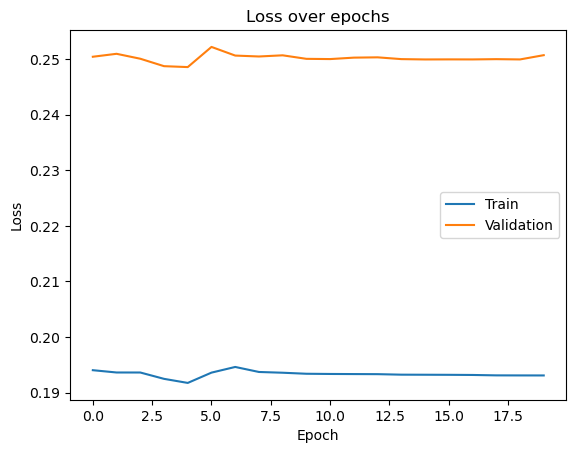

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

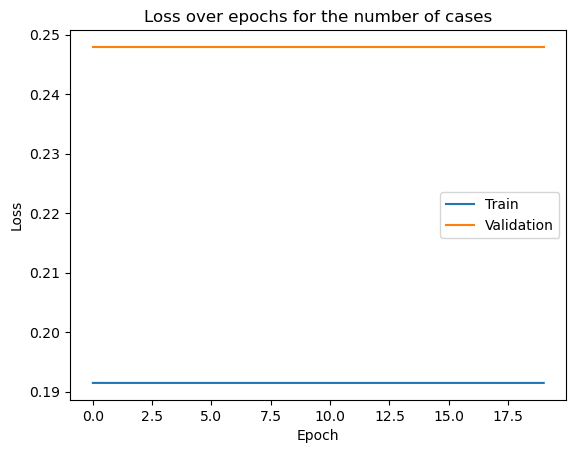

In [20]:
plt.plot(history.history['consumption_loss'])
plt.plot(history.history['val_consumption_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

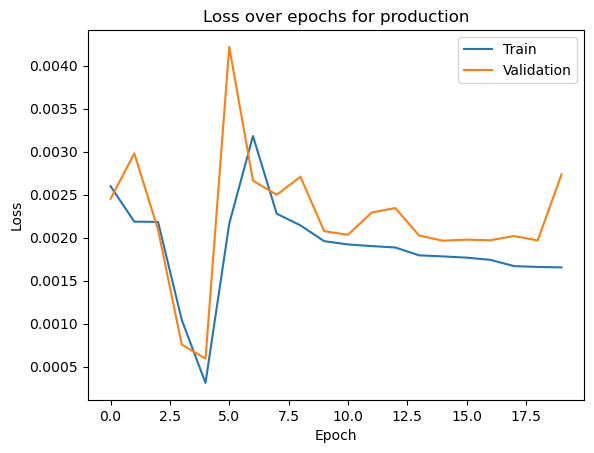

In [22]:
plt.plot(history.history['production_loss'])
plt.plot(history.history['val_production_loss'])
plt.title('Loss over epochs for production')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [23]:
model.load_weights("best_model.h5")


In [28]:
test_predictions = model.predict([X_test1])

3147/3147 [==============================] - 23s 7ms/step


In [30]:
print(test_predictions)

[array([[-0.5813555],
       [-0.5797432],
       [-0.5773315],
       ...,
       [-0.5605969],
       [-0.5536648],
       [-0.5472149]], dtype=float32), array([[0.5279727 ],
       [0.533389  ],
       [0.55086404],
       ...,
       [0.5767984 ],
       [0.59208375],
       [0.6222846 ]], dtype=float32)]


In [35]:
# Convierte la lista en un array de NumPy
test_predictions_array = np.array(test_predictions)

# Ahora puedes ver la forma del array
print(test_predictions_array.shape)

(2, 100675, 1)


In [43]:
test_predictions_array = test_predictions_array.T

In [44]:
test_predictions_array.shape

(1, 100675, 2)

In [46]:
print(y_test1.shape)

(100675,)


In [47]:
test_predictions_reshaped = np.reshape(test_predictions_array, (100675, 2))

In [48]:
# Calcula el RMSE para la primera salida
mse1 = mean_squared_error(y_test1, test_predictions_reshaped[:, 0])
rmse_consumption = np.sqrt(mse1)

print(f'RMSE: {rmse_consumption}')

RMSE: 0.5205837985722914


In [49]:
# Calcula el RMSE para la segunda salida
mse2 = mean_squared_error(y_test2, test_predictions_reshaped[:, 1])
rmse_production = np.sqrt(mse2)

print(f'RMSE para la primera salida: {rmse_production}')

RMSE para la primera salida: 0.025266894730048436


In [50]:
trainPredict = model.predict([X_train1])

20450/20450 [==============================] - 153s 7ms/step


# Grafiquemos

In [78]:
train_predictions = model.predict(X_train1)

20450/20450 [==============================] - 139s 7ms/step


In [84]:
train_predictions_array = np.array(train_predictions)
print(train_predictions_array.shape)

(2, 654385, 1)


In [87]:
train_predictions_reshaped = np.reshape(train_predictions_array, (654385, 2))

In [99]:
train_predictions_consumption = train_predictions_reshaped[:,0]
train_predictions_consumption

array([-0.5570341 , -0.5633815 , -0.57035244, ...,  0.36803544,
        0.3771479 ,  0.367054  ], dtype=float32)

In [100]:
train_results = pd.DataFrame(data={ 'Train Predictions Consumption':train_predictions_consumption, 'Actuals':y_train1})

In [101]:
train_results

,Train Predictions Consumption,Actuals
0,-0.557034,-0.181908
1,-0.563381,-0.195470
2,-0.570352,-0.186870
3,-0.575669,-0.188432
4,-0.579657,-0.185766
...,...,...
654380,0.377864,-0.102436
654381,0.372940,-0.093022
654382,0.368035,-0.097148
654383,0.377148,-0.095486


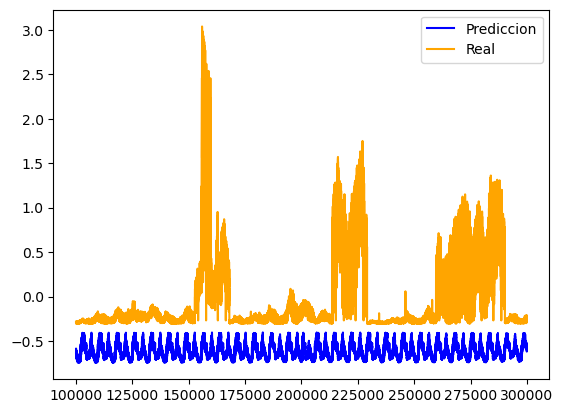

In [104]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions Consumption'][100000:300000],color='blue', label='Prediccion')
plt.plot(train_results['Actuals'][100000:300000],color='orange', label='Real')
plt.legend()

In [105]:
train_predictions_production = train_predictions_reshaped[:,1]
train_predictions_production

array([-0.56059736, -0.5671137 , -0.5738659 , ...,  0.37323684,
        0.36958155,  0.37113857], dtype=float32)

In [121]:
train_results['Train Predict Production'] = train_predictions_production
train_results['Actual_Production'] = y2_train

In [122]:
train_results

,Train Predictions Consumption,Actuals,Train Predict Production,Actual_Production,Train Predict Production,Actual_Production,Actual_Production
0,-0.557034,-0.181908,-0.560597,0.614565,-0.560597,0.614565,0.614565
1,-0.563381,-0.195470,-0.567114,0.612789,-0.567114,0.612789,0.612789
2,-0.570352,-0.186870,-0.573866,0.607460,-0.573866,0.607460,0.607460
3,-0.575669,-0.188432,-0.578048,0.602131,-0.578048,0.602131,0.602131
4,-0.579657,-0.185766,-0.576869,0.596803,-0.576869,0.596803,0.596803
...,...,...,...,...,...,...,...
654380,0.377864,-0.102436,0.374624,0.415631,0.374624,0.415631,0.415631
654381,0.372940,-0.093022,0.371486,0.412078,0.371486,0.412078,0.412078
654382,0.368035,-0.097148,0.373237,0.412078,0.373237,0.412078,0.412078
654383,0.377148,-0.095486,0.369582,0.412078,0.369582,0.412078,0.412078


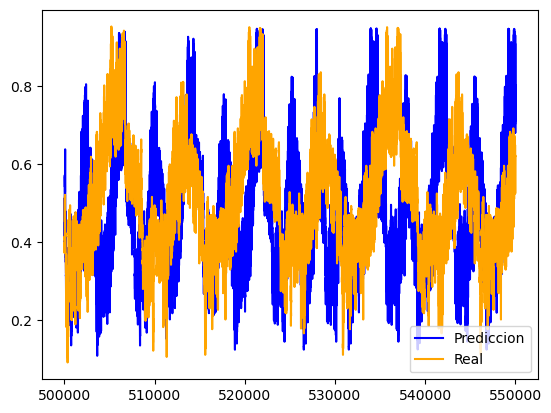

In [126]:
plt.plot(train_results['Train Predict Production'][500000:550000],color='blue', label='Prediccion')
plt.plot(train_results['Actual_Production'][500000:550000],color='orange', label='Real')
plt.legend()